# LMP All in One

## 0. To initialise:
* If run on Visual studio: Click "Run All" which is located right above this text
* If run on Jupter Hub: Click "Regional Deposition" the headline, From the "Run" menu, select "Run selected Cell and All Below"
* Initialisation should take about 2minutes, ready when the circle next to the "IPD Biopharm Shared Kernel" becomes white



In [1]:

#%matplotlib notebook
%matplotlib inline
from ipywidgets import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from functools import reduce
import sys
sys.path.insert(0, 'C:/Users/krvt084/OneDrive - AZCollaboration/Emerging_Tech_Program/ETP_V2/TPM_v2/')

#from TPM import *
#import Regional_Deposition as TPM
import ETP_CFD_Deposition as CFD
#import Parameters_Settings
import constructPSD
import Execute_Regional_Deposition
import Regional_Deposition
from Parameters_Settings import *

#import Lung_deposition_packageVariable_DN_edit as TPM

#from ETP_CFD_Deposition import MT_deposition

import seaborn as sns
from scipy import stats
#from constructPSD import constructPSD, trapezoid_waveform
#from Parameters_Settings import *
#from Calc_functions import *
import ipywidgets as widgets
from IPython.display import display, clear_output

from numba import jit, njit, prange

#from Regional_Deposition import * 

import time
#from numba import prange
#import bqplot as bq
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["KMP_WARNINGS"] = "FALSE"


import gopython

sys.path.insert(0, 'C:/Users/krvt084/OneDrive - AZCollaboration/Emerging_Tech_Program/ETP_V2/CFD/')
import ML_fitted_CFD

from scipy.integrate import simpson
from numpy import trapz
from sklearn.metrics import auc
from IPython.utils import io

sys.path.insert(0, 'C:/Users/krvt084/OneDrive - AZCollaboration/Emerging_Tech_Program/ETP_V2/Other_Functions/')
import Calculation_Functions
import Virtual_BE

import joblib
from scipy.stats import norm

sys.path.insert(0, 'C:/Users/krvt084/OneDrive - AZCollaboration/Emerging_Tech_Program/ETP_V2/DoseResponseModel/')
import DRModel

In [2]:
import sys, os, pickle
import time
import copy
import pandas as pd
import numpy as np
from multiprocessing import Pool, cpu_count


from lmp_apps.pbbm.lung_pbbm import PBPK_Model_Virtual_Trial
from lmp_apps.pbbm.main import run_pbbm_simulations, process_simulation_solutions

from lmp_apps.lung_deposition.main import run_deposition_simulations
from lmp_apps.population.attributes import SubjectPhysiology
from lmp_apps.population.variability import Variability
from lmp_apps.api.api import API
from lmp_apps.study.study import Product, Study
from lmp_apps.vbe.bioequivalence import BioequivalenceAssessor
from lmp_apps.efficacy.fev1model import COPD_FEV1
from lmp_apps.visualisation.plots import TrialVisualizer
from lmp_apps.utils.config import simulation_settings

import warnings
warnings.filterwarnings('ignore')



In [14]:

to_initialise_the_code = True
to_initialise_the_code_execute = True
to_initialise_the_code_post = True
to_initialise_preview_waveform = True
to_initialise_review_subsets = True
to_initialise_add_product_api = True
to_initialise_the_code_get_pbbm = True
to_initialise_the_code_pbbm_execute = True
to_initialise_the_code_post_pbbm = True
to_initialise_the_code_pkbe = True
to_initialise_the_code_PDbe = True
to_initialise_the_code_pbbm_preprocess = True
# Load the CSV file into a pandas DataFrame
#ref_df = pd.read_csv('/projects/op/se_op/scaleupsgrm/LungDeposition/Software/TPM/Ref_Lung_Physiology.csv')  # Replace 'your_file.csv' with the actual file name
#cols = ['Multiplicity','Alveoli Vol', 'Length', 'Diameter','Gravity Angle', 'Branching Angle', 'Expansion Fraction']
#ref_df.loc[0, 'Gravity Angle'] = 0.0
#ref_df.loc[0, 'Branching Angle'] = 0.0

#globals()['Scint_Keys'] = pd.read_csv('/projects/op/se_op/scaleupsgrm/LungDeposition/Software/TPM/scint_keys.csv').iloc[:,[2,3,4]].values
#pmdi_prob = pd.read_csv('/projects/op/se_op/scaleupsgrm/LungDeposition/Software/TPM/pMDI_prob.csv')

#ref_df = pd.read_csv('./../TPM/Ref_Lung_Physiology.csv')
#ref = pd.read_excel('./../TPM_v2/Ref_Lung_Physiology.xlsx', sheet_name='Healthy')
#cols = ['Multiplicity','Alveoli Vol', 'Length', 'Diameter','Gravity Angle', 'Branching Angle', 'Expansion Fraction']
#ref_df.loc[0, 'Gravity Angle'] = 0.0
#ref_df.loc[0, 'Branching Angle'] = 0.0

#globals()['Scint_Keys'] = pd.read_csv('./../TPM/scint_keys.csv').iloc[:,[2,3,4]].values
#pmdi_prob = pd.read_csv('./../TPM/pMDI_prob.csv')


## 1. Population

In [6]:
pop_options = ['Healthy', 'COPD_Opt_1','COPD_Opt_2','COPD_Opt_3','COPD_Opt_4','COPD_Opt_5' ]
ref_dict = {}
for pop in pop_options:
    ref = pd.read_excel('./lmp_apps/data/lung/Ref_Lung_Physiology.xlsx', sheet_name=pop)
    ref_dict[pop] = ref

population_dropdown = widgets.Dropdown(
    options=pop_options,
    value=pop_options[1],
    disabled=False,
    layout=widgets.Layout(width='200px')
)
population = widgets.HBox([population_dropdown])
display(widgets.HBox([widgets.Label(value='Select Population', layout=widgets.Layout(height='auto', width='200px')), population]))



## 2. Reference Lung Parameters
### Edit reference parameters

In [7]:

grid_box = widgets.HBox()

ngen = 25
nparams = 7
region = ['BB', 'bb', 'Al']
cols = ['Multiplicity', 'Alveoli Vol', 'Length', 'Diameter', 'Gravity Angle', 'Branching Angle', 'Expansion Fraction']

def update_grid(change):
    clear_output(wait=True)
    # Update the dataframe when the dropdown value changes
    ref_df = ref_dict[change['new']]
    
    
    
    ref_df.loc[0, 'Gravity Angle'] = 0.0
    ref_df.loc[0, 'Branching Angle'] = 0.0
    
    global physiology_df
    physiology_df = ref_df[cols]

    # Create a new grid
    global grid
    grid = widgets.GridspecLayout(nparams+1, ngen+1)

    # Set the column headers
    for j in range(1, ngen+1):
        grid[0, j] = widgets.Label(value=f"Gen {j-2}")

    # Set the row headers and create text boxes and numeric input boxes
    for i in range(nparams):
        for j in range(ngen):
            value = physiology_df.iloc[j, i]
            textbox = widgets.FloatText(value=value, layout=widgets.Layout(width='auto'))
            grid[i+1, 0] = widgets.Label(value=physiology_df.columns[i])
            grid[i+1, j+1] = widgets.VBox([textbox])

    # Create a box to contain the grid and automatically adjust its width
    #global grid_box
    #grid_box = widgets.HBox()
    
    grid_box.children = [widgets.VBox([ widgets.Label(value='Current Population: ' +  population_dropdown.value), grid])]
    #grid_box = widgets.HBox([grid])

    #globals()['grid_box'] = grid_box
    # Print a message indicating the update is done
    #display(grid_box)
# Initial display
update_grid({'new': population_dropdown.value})
population_dropdown.observe(update_grid, names='value')
display(grid_box)
#display(widgets.HBox([grid]))

## 3. Variability in Lung parameters
* Parameter = Reference Value * Scale factor, where Scale factor is sampled with Normal_Distribution(Mean, Std) with Mean and Std are input in this table
* Check tickbox to sample each generation separately

In [9]:

region = ['BB', 'bb', 'Al']
nregion = len(region)
# Create a 3x24 grid of text boxes and numeric input boxes
grid_dist = widgets.GridspecLayout(nparams+1, ngen+1)  # Increased by 1 row and 1 column for headers
# Set the column headers
for j in range(1, ngen+1):
    grid_dist[0, j] = widgets.Label(value=f"Gen {j-2}")
grid_dist[0, 0] = widgets.Label(value='Input Mean, Std %, and Select to')
# Set the row headers and create text boxes and numeric input boxes
for i in range(nparams):
    grid_dist[i+1, 0] = widgets.Label(value=physiology_df.columns[i])
    for j in range(ngen):
        input_mean = widgets.BoundedFloatText(value=1.0, min=0.2, max=1.8, step=0.001, layout=widgets.Layout(width='auto'))  # Set width to 'auto'
        input_std = widgets.BoundedFloatText(value=0.0, min=0, max=50, step=0.1, layout=widgets.Layout(width='auto'))  # Set width to 'auto'
        #checkbox = widgets.Checkbox(value=False, description='Sample Each Generation',  disabled=False,  indent=False)
        #grid_dist[i+1, j+1] = widgets.VBox([input_mean, input_std, checkbox])         
        grid_dist[i+1, j+1] = widgets.VBox([input_mean, input_std]) 
# Create a box to contain the grid and automatically adjust its width
grid_box_dist = widgets.HBox([grid_dist], layout=widgets.Layout(width='100%', height='auto'))

display(grid_box_dist)

## 4. Variability in FRC

* Input Mean and Std

In [10]:

input_mean = widgets.BoundedFloatText(value=3300, min=1000, max=5000, step=1, layout=widgets.Layout(width='auto'))  # Set width to 'auto'
input_std = widgets.BoundedFloatText(value=600, min=0, max=1000, step=1, layout=widgets.Layout(width='auto'))  # Set width to 'auto'

frc_grid = widgets.HBox([input_mean, input_std])  
display(widgets.VBox([widgets.Label(value='FRC Mean and Std, ml'),frc_grid]))

## 5. Inhalation Maneuover

* Input Mean and Std for flow variables
* PIFR, risetime is now tunned for both mean and std
* Inhaled Volume proportional to FRC
* The variables are only constrained > 0, so watch out

In [11]:




flow_params = ['Inhaled Volume, L', 'PIFR, Lpm', 'Rise Time, s', 'Hold Time [not-use], s']
ref_value = [2, 30, 0.4, 0.5]
ref_value_std = [0, 0.3, 0.1, 0.0]
# Create a 3x24 grid of text boxes and numeric input boxes
grid_flow_plot = widgets.GridspecLayout(1, 2)  # Increased by 1 row and 1 column for headers

flow_grid = widgets.GridspecLayout(len(flow_params)+1, 2) 
# Set the column headers

flow_grid[0, 1] = widgets.HBox([widgets.Label(value='Mean', layout=widgets.Layout(width='120px')), widgets.Label(value='Std', layout=widgets.Layout(width='auto'))])

# Set the row headers and create text boxes and numeric input boxes
for i in range(len(flow_params)):
    flow_grid[i+1, 0] = widgets.Label(value=flow_params[i])
    input_mean = widgets.BoundedFloatText(value=ref_value[i], min=0, max=1e6, step=0.1, layout=widgets.Layout(width='auto'))  # Set width to 'auto'
    input_std = widgets.BoundedFloatText(value=ref_value_std[i], min=0, max=1e6, step=0.1, layout=widgets.Layout(width='auto'))  # Set width to 'auto'
       
    flow_grid[i+1, 1] = widgets.HBox([input_mean, input_std])         
 
# Create a box to contain the grid and automatically adjust its width
grid_flow_plot[0,0] = flow_grid #widgets.HTML(value=grid_frc)
#widgets.HBox([grid_frc], layout=widgets.Layout(width='100%', height='auto'))


other_params = ['Breath Hold Time, s', 'Exhalation Constant Flow, Lpm', 'Bolus Volume, ml', 'Bolus_Delay, s']
ref_value_others = [30, 30, 200, 0]
# Create a 3x24 grid of text boxes and numeric input boxes

others_grid = widgets.GridspecLayout(len(other_params)+1, 2) 
# Set the column headers

others_grid[0, 1] = widgets.HBox([widgets.Label(value='Mean', layout=widgets.Layout(width='120px')), widgets.Label(value='Std', layout=widgets.Layout(width='auto'))])

# Set the row headers and create text boxes and numeric input boxes
for i in range(len(other_params)):
    others_grid[i+1, 0] = widgets.Label(value=other_params[i])
    input_mean_others = widgets.BoundedFloatText(value=ref_value_others[i], min=0, max=1e6, step=0.1, layout=widgets.Layout(width='auto'))  # Set width to 'auto'
    input_std_others = widgets.BoundedFloatText(value=0.0, min=0, max=1e6, step=0.1, layout=widgets.Layout(width='auto'))  # Set width to 'auto
       
    others_grid[i+1, 1] = widgets.HBox([input_mean_others, input_std_others ])  
#display(others_grid)
grid_flow_plot[0,1] = others_grid
   
display(grid_flow_plot)

GridspecLayout(children=(GridspecLayout(children=(HBox(children=(Label(value='Mean', layout=Layout(width='120p…

In [15]:



inh_flow_button = widgets.Button(
    description='Update WaveForm Preview',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Inhalation Flowrate',
    icon='', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(width='500px')
)

#number_subject = widgets.IntText(value=1,layout=widgets.Layout(width='auto'),  description='Number of Subjects',)


output_inh_flow = widgets.Output()

#def plot(flow_grid):


## %matplotlib inline
def plot(flow_grid):   
    clear_output(wait=True)
    Inhaled_Vol = flow_grid[1,1].children[0].value 
    PIFR = flow_grid[2,1].children[0].value
    Rise_Time  = flow_grid[3,1].children[0].value
    Hold_Time = flow_grid[4,1].children[0].value


    #flow = constructPSD.trapezoid_waveform(Inhaled_Vol, PIFR, Rise_Time, Hold_Time , N_Q_max - 1)

    flow = constructPSD.new_trapezoid_waveform_plot(Inhaled_Vol, PIFR, Rise_Time, N_Q_max - 2)
    #flow = new_trapezoid_waveform(Inhaled_Vol, PIFR, Rise_Time, N_Q_max - 1)

    fig, ax = plt.subplots(figsize = (8,4))

    ax.plot(flow[:,0], flow[:,1])
    ax.set_xlabel('Time, s')
    ax.set_ylabel('Flowrate, lpm')
    ax.set_title('Trapezoidal Inhalation waveformm')
    ax.set_xlim([0,6])
    ax.set_ylim([0,120])
    plt.show()

def on_inh_flow_button_clicked(b):
    with output_inh_flow:
        plot(flow_grid)
        


if to_initialise_preview_waveform:
    with output_inh_flow:
        plot(flow_grid)
        #plot(flow_grid)
        to_initialise_preview_waveform = False
        
display(inh_flow_button, output_inh_flow)
inh_flow_button.on_click(on_inh_flow_button_clicked)

#inh_flow_button.on_click(plot)
#display(inh_flow_button)


Button(button_style='success', description='Update WaveForm Preview', layout=Layout(width='500px'), style=Butt…

Output()

## 6. Products

In [ ]:

product_api_button = widgets.Button(
    description='Add Product Data',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Add Product Data',
    icon='', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(width='500px')
)

#number_product_field = widgets.IntText(value=1,layout=widgets.Layout(width='auto'),  description='Number of Products',)
#number_api_field = widgets.IntText(value=1,layout=widgets.Layout(width='auto'),  description='Number of APIs',)
number_product_field = widgets.IntText(value= 2 ,layout=widgets.Layout(width='auto'),  description='',)
number_api_field = widgets.IntText(value= 3,layout=widgets.Layout(width='auto'),  description='',)
output_product_api = widgets.Output()



## %matplotlib inline
def add_product_api(number_product_field, number_api_field):   
    clear_output(wait=True)
    number_product = number_product_field.value
    number_api = number_api_field.value
    product_params = ['Product Name', 'Propellant', 'Device', 'API','Dose, ug', 'USP Deposition Fraction', 'MMAD, um', 'GSD, um' ]
    dropdown_options = [[],['PT210', 'PT010'], ['DFP', 'nonDFP'], ['BD', 'GP', 'FF']]
    ref_value_dict_d5985c00004 = {'0':{'0':['Test',  'PT210', 'DFP', 'BD', 660.68/2, 41.08, 4.06, 1.67],
                            '1':['Test',  'PT210', 'DFP', 'GP', 28.84/2, 38.06, 3.94, 1.67],
                            '2':['Test',  'PT210', 'DFP', 'FF', 19.36 / 2, 39.50, 4.0, 1.69]}, 
                      '1':{'0': ['Reference',  'PT010', 'DFP', 'BD', 658.08/2, 41.26,	3.53,	1.61],
                            '1':['Reference',  'PT010', 'DFP', 'GP', 28.92/2, 38.18,	3.4,	1.62],
                            '2':['Reference',  'PT010', 'DFP', 'FF', 19.24 / 2, 38.28,	3.4,	1.66]} }     # '1':['Reference',  'Propellant', 'Device', 'API',320, 38, 3.50, 1.65]}
    
    ref_value_dict_d5985c00001 = {'0':{'0':['Test',  'PT210', 'DFP', 'BD', 331.4, 38.536, 3.76, 1.64],
                            '1':['Test',  'PT210', 'DFP', 'GP', 14.6, 38.08, 3.67, 1.64],
                            '2':['Test',  'PT210', 'DFP', 'FF', 10, 39.66, 3.87, 1.62]}, 
                      '1':{'0': ['Reference',  'PT010', 'DFP', 'BD', 318, 38.79, 3.43, 1.62],
                            '1':['Reference',  'PT010', 'DFP', 'GP', 14, 37.25,	3.27,	1.62],
                            '2':['Reference',  'PT010', 'DFP', 'FF', 9.6, 37.87,	3.41,	1.63]} } 
    #ref_value_dict = ref_value_dict_d5985c00001
    ref_value_dict = ref_value_dict_d5985c00004
    #ref_value = ['Product',  'Propellant', 'Device', 'API',320, 38, 3.50, 1.65]
    # Create a 3x24 grid of text boxes and numeric input boxes
    product_grid = widgets.GridspecLayout(1, number_product + 1)

    
    param_product_grid = widgets.GridspecLayout(len(product_params), 1) 

    for i in range(len(product_params)):
            param_product_grid[i, 0] = widgets.Label(value=product_params[i], layout=widgets.Layout(width='150px'))
    product_grid[0, 0]   = param_product_grid
    # Set the column headers
    header_product = widgets.GridspecLayout(1, number_product  +1)
    header_product[0, 0] = widgets.HBox([widgets.Label(value='Product Data', layout=widgets.Layout(width='150px'))])
    dict_product_grid = {}
    dict_header_grid = {}
    dict_api_grid = {}
    dict_api_header = {}
    for n_prod in range(number_product):
        #ref_value = ref_value_dict[str(n_prod)]
        
        dict_header_grid[str(n_prod + 1)] = widgets.GridspecLayout(1,number_api )
        for j in range(number_api):
            ref_value = ref_value_dict[str(n_prod)][str(j)]
            dict_api_grid[str(j)] = widgets.GridspecLayout(len(product_params),1 )
            dict_api_header[str(j)] = widgets.GridspecLayout(1,1 )
            dict_api_header[str(j)][0, 0] = widgets.HBox([widgets.Label(value='Product ' + str(n_prod + 1) + '| API ' + str(j+1), layout=widgets.Layout(width='125px'))])

            for i in range(len(product_params)):

            
                                
                #dict_header_grid[str(n_prod + 1)][0, j] = widgets.HBox([widgets.Label(value='Product ' + str(n_prod + 1) + '| API ' + str(j+1), layout=widgets.Layout(width='125px'))])

                if i < 1:
        
                    #dict_product_grid[str(n_prod + 1)][i, j] = widgets.HBox([widgets.Text(    value=ref_value[i],    placeholder=ref_value[i],       disabled=False, layout=widgets.Layout(width='125px')   )])
                    dict_api_grid[str(j)][i, 0] = widgets.HBox([widgets.Text(    value=ref_value[i],    placeholder=ref_value[i],       disabled=False, layout=widgets.Layout(width='125px')   )])
                elif i < 4:
                    #dict_api_grid[str(j)][i, 0] = widgets.HBox([widgets.Dropdown( options= dropdown_options[i],    value= dropdown_options[i][0],     disabled=False,layout=widgets.Layout(width='125px'))])
                    dict_api_grid[str(j)][i, 0] = widgets.HBox([widgets.Dropdown( options= dropdown_options[i],    value= ref_value[i],     disabled=False,layout=widgets.Layout(width='125px'))])

                else:
                    #dict_product_grid[str(n_prod + 1)][i, j] = widgets.HBox([widgets.FloatText(value=ref_value[i], step=0.01, layout=widgets.Layout(width='125px'))])
                    dict_api_grid[str(j)][i, 0] = widgets.HBox([widgets.FloatText(value=ref_value[i], step=0.01, layout=widgets.Layout(width='125px'))])
                
        dict_product_grid[str(n_prod + 1)] = widgets.HBox([dict_api_grid[str(j)] for j in range(number_api)])
        dict_header_grid[str(n_prod + 1)] = widgets.HBox([dict_api_header[str(j)] for j in range(number_api)])
        product_grid[0, n_prod+1]   = dict_product_grid[str(n_prod + 1)] #widgets.HBox([dict_product_grid[str(n_prod + 1)]])
        header_product[0, n_prod+1]   =  dict_header_grid[str(n_prod + 1)] #widgets.HBox([dict_header_grid[str(n_prod + 1)]])
    
    globals()['all_product_grid'] = product_grid
    display(widgets.VBox([header_product,product_grid]))



def on_product_api_button_clicked(b):
    with output_product_api:
        add_product_api(number_product_field, number_api_field)
        


if to_initialise_add_product_api:
    with output_product_api:
        add_product_api(number_product_field, number_api_field)
        #plot(flow_grid)
        to_initialise_add_product_api = False
        
display(widgets.HBox([widgets.Label(value='Number of Products', layout=widgets.Layout(width='auto', height = 'auto')), number_product_field]), 
        widgets.HBox([widgets.Label(value='Number of APIs', layout=widgets.Layout(width='auto', height = 'auto')), number_api_field]), product_api_button, output_product_api)
product_api_button.on_click(on_product_api_button_clicked)

#inh_flow_button.on_click(plot)
#display(inh_flow_button)


""" To implement
1. Inputs study and settings arguments to make those istances as in the script
2. Use something similar above as user inputs for product properties
1. Take unique APIs first products and Display the default API values in the API class as edittable table
3. Update API properties inputs and Create products as in the script
3. Adapt the following widgets to update the variability and subject instances


Button(button_style='success', description='Add Product Data', layout=Layout(width='500px'), style=ButtonStyle…

Output()

## 7. Variability in Lung Dose

* [MT, MMAD ex MT, GSD ex MT] = CFD_predicted [values] * Scaling Factors
where scaling factors = Lognormal (mean, std) with mean and std input here
* For MT, scale is derived from the ratio of CFD predicted vs Scint data

In [17]:

lungdose_params = ['MT Deposition', 'MMAD ex MT', 'GSD ex MT']
# Create a 3x24 grid of text boxes and numeric input boxes
lungdose_grid_plot = widgets.GridspecLayout(1, 2)  # Increased by 1 row and 1 column for headers

lungdose_grid = widgets.GridspecLayout(len(lungdose_params)+1, 3) 
# Set the column headers

lungdose_grid[0, 1] = widgets.HBox([widgets.Label(value='Mean', layout=widgets.Layout(width='120px')), widgets.Label(value='Std Inter', layout=widgets.Layout(width='120px')),  widgets.Label(value='Std Intra', layout=widgets.Layout(width='120px'))])
# Set the row headers and create text boxes and numeric input boxes

ref_scale_factor = [1.260, 1.0, 1.0]
ref_scale_factor_std = [0.235, 0.235/2, 0.01]
ref_scale_factor_std_intra = [0.15, 0.15/2, 0.01]
for i in range(len(lungdose_params)):
    lungdose_grid[i+1, 0] = widgets.Label(value=lungdose_params[i])
    
    input_mean = widgets.BoundedFloatText(value=ref_scale_factor[i], min=0, max=1e3, step=0.01, layout=widgets.Layout(width='auto'))  # Set width to 'auto'
    
    input_std = widgets.BoundedFloatText(value=ref_scale_factor_std[i], min=0, max=1e3, step=0.01, layout=widgets.Layout(width='auto'))  # Set width to 'auto'
    input_std_intra = widgets.BoundedFloatText(value=ref_scale_factor_std_intra[i], min=0, max=1e3, step=0.01, layout=widgets.Layout(width='auto'))  # Set width to 'auto'
    lungdose_grid[i+1, 1] = widgets.HBox([input_mean, input_std, input_std_intra])         
 
# Create a box to contain the grid and automatically adjust its width
lungdose_grid_plot[0,0] = lungdose_grid #widgets.HTML(value=grid_frc)
#widgets.HBox([grid_frc], layout=widgets.Layout(width='100%', height='auto'))
display(lungdose_grid_plot, widgets.Label(value = 'CFD -> Scint Data: Scaling COPD = 1.389, Scaling Healthy = 1.260, apply variability here, current: cv% around 45%'))

GridspecLayout(children=(GridspecLayout(children=(HBox(children=(Label(value='Mean', layout=Layout(width='120p…

Label(value='CFD -> Scint Data: Scaling COPD = 1.389, Scaling Healthy = 1.260, apply variability here, current…

In [ ]:
for cnt_prod in range(number_product_field.value):
    for cnt_api in range(number_api_field.value):
        product_name = all_product_grid.children[1 + cnt_prod].children[cnt_api].children[0].children[0].value
        propellant = all_product_grid.children[1 + cnt_prod].children[cnt_api].children[1].children[0].value
        device = all_product_grid.children[1 + cnt_prod].children[cnt_api].children[2].children[0].value.lower()
        api = all_product_grid.children[1 + cnt_prod].children[cnt_api].children[3].children[0].value
        dose = all_product_grid.children[1 + cnt_prod].children[cnt_api].children[4].children[0].value
        uspdepo = all_product_grid.children[1 + cnt_prod].children[cnt_api].children[5].children[0].value 
        uspMMAD = all_product_grid.children[1 + cnt_prod].children[cnt_api].children[6].children[0].value
        uspGSD = all_product_grid.children[1 + cnt_prod].children[cnt_api].children[7].children[0].value

In [159]:

# Function to create new dataframe with the product of display value and box input
sample_geometry_button = widgets.Button(
    description='Sample subject',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Sample subject parameters',
    icon='', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(width='500px')
)


number_subject = widgets.IntText(value= 1,layout=widgets.Layout(width='500px'),  description='Number of Subjects',)
number_pools = widgets.IntText()

output_sample = widgets.Output()



def create_new_dataframe(grid_dist , grid, frc_grid, flow_grid, others_grid, lungdose_grid, all_product_grid, number_product_field, number_api_field, number_subject ):
    
    number_pools.value = number_subject.value * 1.5
    
    
    geo_sub = {}
    frc_tmp = {}
    flow_sub = {}
    flow_sub_new = {}
    #nregion = len(region)
    breath_hold_time = {}
    Flow_Exh = {}
    BolusVolume  = {}
    Bolus_Delay = {}
    
    
    mtdepo = {}
    mtdepo_no_intra = {}
    psd = {}
    Rise_Time_sub = {}
    Hold_Time_sub = {}
    PIFR_sub = {}
    Inhaled_Vol_sub = {}
    
    for nsub in range(number_pools.value):
        sub_val = np.ones((nparams, ngen))
        data = []
        data_ref_locked = []
        for i in range(nparams):
            row = []
            row_ref_locked = []
            
            for k in range(ngen):
                mean_value = grid_dist[i+1, k+1].children[0].value
                std_value = grid_dist[i+1, k+1].children[1].value
                val_region = stats.norm.rvs(loc =  mean_value, scale = std_value , size = int(1))[0]
                sub_val[i, k] =  val_region
            for j in range(ngen):
                display_value = grid[i+1, j+1].children[0].value
                row.append(display_value * sub_val[i, j])
                row_ref_locked.append(display_value)
            data.append(row)
            data_ref_locked.append(row_ref_locked)
        new_df = pd.DataFrame(data)
        globals()['locked_ref_data'] = pd.DataFrame(data_ref_locked)
        geo_sub[str(nsub+1)] = new_df.T.values
        
        ### Sampling Lung volume
        FRC = stats.norm.rvs(loc =  frc_grid.children[0].value, scale = frc_grid.children[1].value, size = int(1))[0]
        frc_tmp[str(nsub+1)] = FRC
        
        ### Sampling Inhalation Flowrate
        flowparams = []
        for flow_idx in range(len(flow_params)):
    
            mean = flow_grid[flow_idx+1,1].children[0].value
            std = flow_grid[flow_idx+1,1].children[1].value
            if flow_idx == 1:
                sample_ratio = stats.lognorm(s = max(0.01, std), scale = mean).rvs(int(10000))
                sample_ratio = sample_ratio[(sample_ratio > 10) & (sample_ratio < 120) ]
                sub_val = np.random.choice(sample_ratio, int(1))[0]
            else: 
                sub_val = stats.norm.rvs(loc =  mean, scale = std, size = int(1))[0]
            flowparams.append(sub_val)

        Inhaled_Vol = flowparams[0]  * (FRC / frc_grid.children[0].value )  # proportional between inhaled vol AND  PFIE  # flowparams[0] 
        PIFR = flowparams[1]
        Rise_Time  = flowparams[2]
        Hold_Time = flowparams[3]
    
        flowrate = constructPSD.new_trapezoid_waveform_simulation(Inhaled_Vol, PIFR, Rise_Time, N_Q_max-1)
        flowrate_new = constructPSD.new_trapezoid_waveform_plot(Inhaled_Vol, PIFR, Rise_Time, N_Q_max-1)
 
        flow_sub[str(nsub+1)] = flowrate
        flow_sub_new[str(nsub+1)] = flowrate_new

        Rise_Time_sub[str(nsub+1)] = Rise_Time
        Hold_Time_sub[str(nsub+1)] = Hold_Time
        PIFR_sub[str(nsub+1)] = PIFR
        Inhaled_Vol_sub[str(nsub+1)] = Inhaled_Vol 


        otherparams = []
        for flow_idx in range(len(other_params)):
            mean = others_grid[flow_idx+1,1].children[0].value
            std = others_grid[flow_idx+1,1].children[1].value 
            sub_val = stats.norm.rvs(loc =  mean, scale = std, size = int(1))[0]
            otherparams.append(sub_val)
        
        breath_hold_time[str(nsub+1)] = otherparams[0] 
        Flow_Exh[str(nsub+1)] = otherparams[1] 
        BolusVolume[str(nsub+1)]  = otherparams[2]
        Bolus_Delay[str(nsub+1)] = otherparams[3]

        mtdepo[str(nsub+1)] = []  # this is no intra
        MMAD = []
        GSD = []
        
        psd[str(nsub+1)] = []
        
        # Strategy: for CFD, First apply the inter-subject to sample the scale, then use the sampled scale as mean, sample again with intra subject. apply the same to MMAD but not GSD (it is sensitive)
        lungdoseparams_inter = []
        for flow_idx in range(len(lungdose_params)):
            mean = lungdose_grid[flow_idx+1,1].children[0].value
            std = lungdose_grid[flow_idx+1,1].children[1].value 
            #sub_val = stats.norm.rvs(loc =  mean, scale = std, size = int(1))[0]
            sub_val = stats.lognorm(s = std, scale = mean).rvs(1)[0]
            if flow_idx < 1:
                if sub_val * 0.55 > 0.95:
                        
                        sub_val_resample = stats.lognorm(s = std, scale = mean).rvs(20) 
                        sub_val_resample = sub_val_resample * 0.6
                        sub_val_resample = sub_val_resample[(sub_val_resample > 0.05) & (sub_val_resample < 0.95) ]
                        sub_val = np.random.choice(sub_val_resample, 1)[0]
            lungdoseparams_inter.append(sub_val)
        
        # sample also the CL and Oral availability
        cl_inter = {}
        gi_avail_inter = {}
        for api in ['BD', 'GP', 'FF']:
            mean = CL_dist[api]
            std = variability_data['Inter']['CL'][api]
            cl_inter[api] = stats.norm.rvs(loc =  mean, scale = std, size = int(1))[0]
        for api in ['BD', 'GP', 'FF']:
            mean = 1 - gi_eh[api] / 100
            std = variability_data['Inter']['gi_avail'][api]
            gi_avail_inter[api] = stats.lognorm(s = std, scale = mean).rvs(1)[0]
        
        #intra_id = 0
        #no_intra_scale_factor = []
        mtdepo_no_intra[str(nsub+1)] = []
        
        for cnt_prod in range(number_product_field.value):
            for cnt_api in range(number_api_field.value):
                product_name = all_product_grid.children[1 + cnt_prod].children[cnt_api].children[0].children[0].value
                propellant = all_product_grid.children[1 + cnt_prod].children[cnt_api].children[1].children[0].value
                device = all_product_grid.children[1 + cnt_prod].children[cnt_api].children[2].children[0].value.lower()
                api = all_product_grid.children[1 + cnt_prod].children[cnt_api].children[3].children[0].value
                dose = all_product_grid.children[1 + cnt_prod].children[cnt_api].children[4].children[0].value
                uspdepo = all_product_grid.children[1 + cnt_prod].children[cnt_api].children[5].children[0].value 
                uspMMAD = all_product_grid.children[1 + cnt_prod].children[cnt_api].children[6].children[0].value
                uspGSD = all_product_grid.children[1 + cnt_prod].children[cnt_api].children[7].children[0].value

                #casttype = np.random.choice(['medium'] * 40 + ['large'] * 30 + ['small'] * 20, 1)[0]
                casttype = 'medium'
                mtdepo_loc, mmad_loc, gsd_loc = ML_fitted_CFD.ML_CFD_MT_deposition(uspMMAD, uspGSD, propellant, uspdepo, PIFR, casttype, device.lower())
                cfd_pred_cast = [mtdepo_loc / 100, mmad_loc, gsd_loc]
                
                # Now sample intra-subject
                n_sampling = 20
                lungdoseparams_with_intra = []
                lungdoseparams_nointra = []
                for flow_idx in range(len(lungdose_params)):
                    #mean = lungdose_grid[flow_idx+1,1].children[0].value
                    mean = lungdoseparams_inter[flow_idx]
                    std = lungdose_grid[flow_idx+1,1].children[2].value # intra-subject var
                    intra_val = stats.lognorm(s = std, scale = mean).rvs(n_sampling)
                    inter_val = mean
                    
                    
                    #sub_val = stats.norm.rvs(loc =  mean, scale = std, size = int(n_sampling))
                    #cfd_times_sub_val =  sub_val * cfd_pred_cast[flow_idx]
                    cfd_times_sub_val =  intra_val * cfd_pred_cast[flow_idx]
                    if flow_idx < 1:
                        cfd_times_sub_val = cfd_times_sub_val[(cfd_times_sub_val > 0.05) & (cfd_times_sub_val < 0.95) ]
                        sampled_value = np.random.choice(cfd_times_sub_val, 1)[0]
                        #scale = lungdose_grid[flow_idx+1,1].children[0].value
                        #if intra_id < 1:
                        #    no_intra_scale_factor.append(sampled_value / cfd_pred_cast[0])
                       
                    else:
                        sampled_value = np.random.choice(cfd_times_sub_val, 1)[0]
                    sampled_value_no_intra = inter_val *  cfd_pred_cast[flow_idx]
                    
                    lungdoseparams_with_intra.append(sampled_value)
                    lungdoseparams_nointra.append(sampled_value_no_intra)
                    
                #lungdoseparams_nointra.append(no_intra_scale_factor[cnt_api] * cfd_pred_cast[0] )
                    
                        
                #mtdepo[str(nsub+1)].append(min(0.95, max(0.05, lungdoseparams[0] * mtdepo_loc / 100)))
                #MMAD = lungdoseparams[1] * mmad_loc
                #GSD  = lungdoseparams[2] * gsd_loc
                
                #mtdepo[str(nsub+1)].append(lungdoseparams[0] )
                
                mtdepo[str(nsub+1)].append(lungdoseparams_with_intra[0] )    # with intra
                MMAD = lungdoseparams_with_intra[1] 
                GSD  = lungdoseparams_with_intra[2]
                # With intra MT
                #mtdepo_with_intra[str(nsub+1)].append([nsub+1,  product_name, api, lungdoseparams_nointra[0]] )
                mtdepo_no_intra[str(nsub+1)].append([nsub+1,  product_name, api, lungdoseparams_nointra[0]])
                
                # Sampled PSD
                
                N_bins = N_bins_max
                bins = np.linspace(min_bin_size, max_bin_size, N_bins)
                psd_tmp = np.zeros((N_bins, 3))
                d_a, d_g, v_f = constructPSD.constructPSD(MMAD, GSD, bins)
                psd_tmp[:,0] = d_a
                psd_tmp[:,1] = d_g
                psd_tmp[:,2] = v_f
                psd[str(nsub+1)].append(psd_tmp)
            #intra_id += 1
# post process as well, try multiply with (n_products * n_api)
    globals()['Rise_Time_all'] = [Rise_Time_sub[str(i+1)] for i in range(number_pools.value) for nprod in range(number_product_field.value) for napi in range(number_api_field.value)]
    globals()['Hold_Time_all'] = [Hold_Time_sub[str(i+1)] for i in range(number_pools.value) for nprod in range(number_product_field.value) for napi in range(number_api_field.value)]
    globals()['PIFR_all'] = [PIFR_sub[str(i+1)] for i in range(number_pools.value) for nprod in range(number_product_field.value) for napi in range(number_api_field.value)]
    globals()['Inhaled_Vol_all'] = [Inhaled_Vol_sub[str(i+1)] for i in range(number_pools.value) for nprod in range(number_product_field.value) for napi in range(number_api_field.value)]

    geometry_sub = [geo_sub[str(i+1)] for i in range(number_pools.value) for nprod in range(number_product_field.value) for napi in range(number_api_field.value)]
    globals()['mean_geometry'] = np.mean(geometry_sub, axis = 0)
    globals()['std_geometry'] = np.std(geometry_sub, axis = 0) #/ mean_geometry

    frc_sub = [frc_tmp[str(i+1)] for i in range(number_pools.value) for nprod in range(number_product_field.value) for napi in range(number_api_field.value)]
    flow_tmp = [flow_sub[str(i+1)] for i in range(number_pools.value) for nprod in range(number_product_field.value) for napi in range(number_api_field.value)]
    flowrate_sub = np.array(flow_tmp)

    flow_tmp_new = [flow_sub_new[str(i+1)] for i in range(number_pools.value) for nprod in range(number_product_field.value) for napi in range(number_api_field.value)]
    flowrate_sub_new = np.array(flow_tmp_new)


    breath_hold_time_sub = [breath_hold_time[str(i+1)] for i in range(number_pools.value) for nprod in range(number_product_field.value) for napi in range(number_api_field.value)]   
    Flow_Exh_sub = [Flow_Exh[str(i+1)] for i in range(number_pools.value) for nprod in range(number_product_field.value) for napi in range(number_api_field.value)]
    BolusVolume_sub = [BolusVolume[str(i+1)] for i in range(number_pools.value) for nprod in range(number_product_field.value) for napi in range(number_api_field.value)]
    Bolus_Delay_sub = [Bolus_Delay[str(i+1)] for i in range(number_pools.value) for nprod in range(number_product_field.value) for napi in range(number_api_field.value)]
    
    mtdepo_sub = [mt for i in range(number_pools.value) for mt in mtdepo[str(i+1)] ]

    psd_sub = [pp for i in range(number_pools.value) for pp in psd[str(i+1)]]
    # mt No intra
    globals()['MTDeposition_No_Intra_Variability'] = mtdepo_no_intra
    #  debug

    globals()['sub_lung_all'], globals()['v_lung_all'],globals()['psd_all'], globals()['mtdepo_all'], globals()['flowrate_all_new'], globals()['breath_hold_time_all'], globals()['Flow_Exh_all'], globals()['BolusVolume_all'], globals()['Bolus_Delay_all'] = Regional_Deposition.simulation_params_array(number_pools.value * number_product_field.value * number_api_field.value, geometry_sub, flowrate_sub_new, frc_sub, psd_sub, mtdepo_sub, breath_hold_time_sub, Flow_Exh_sub, BolusVolume_sub, Bolus_Delay_sub)

    globals()['sub_lung_all'], globals()['v_lung_all'],globals()['psd_all'], globals()['mtdepo_all'], globals()['flowrate_all'], globals()['breath_hold_time_all'], globals()['Flow_Exh_all'], globals()['BolusVolume_all'], globals()['Bolus_Delay_all'] = Regional_Deposition.simulation_params_array(number_pools.value * number_product_field.value * number_api_field.value, geometry_sub, flowrate_sub, frc_sub, psd_sub, mtdepo_sub, breath_hold_time_sub, Flow_Exh_sub, BolusVolume_sub, Bolus_Delay_sub)
    # Post process all lung geometries
    for sub_id in range(len(geometry_sub)):
        tempdf = pd.DataFrame(geometry_sub[sub_id]).reset_index()
        tempdf.columns = ['Generation'] + cols
        tempdf['Generation'] = tempdf['Generation'] - 1
        tempdf['Subject'] = sub_id + 1

        if sub_id < 1:
            sampled_geometry_all = tempdf.copy()
        else:
            sampled_geometry_all = pd.concat([sampled_geometry_all, tempdf])
    globals()['Sampled_Lung_Geometries'] = sampled_geometry_all

def on_button_clicked(b):
    with output_sample:

        create_new_dataframe(grid_dist, grid, frc_grid, flow_grid, others_grid, lungdose_grid, all_product_grid, number_product_field, number_api_field,  number_subject)

        print("Subject sampled")
display(number_subject, sample_geometry_button, output_sample)

if to_initialise_the_code:

    create_new_dataframe(grid_dist, grid, frc_grid, flow_grid, others_grid, lungdose_grid, all_product_grid, number_product_field, number_api_field, number_subject)
    to_initialise_the_code = False

sample_geometry_button.on_click(on_button_clicked)

IntText(value=1, description='Number of Subjects', layout=Layout(width='500px'))

Button(button_style='success', description='Sample subject', layout=Layout(width='500px'), style=ButtonStyle()…

Output()

In [161]:
1

1

## 9. Preview Subset
#### a. Lung Parameters
* Number of airways , (ii) Aveolar Volume, and (iii) Diameter
* Top: Mean and Std
* Bottom: Mean and Std normalised by Reference Values

In [13]:

lung_params_button = widgets.Button(
    description='Update Subset Lung Parameters Review',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to update the plots with sampled subjects',
    icon='', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(width='500px')
)


output_lung_params = widgets.Output()


## %matplotlib inline
def plot_lung_params(mean_geometry, std_geometry):   
    
    clear_output(wait=True)
    
    x = np.arange(len(mean_geometry))  # Create x values for the plot

    fig, axes = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(18,12))
    val = [0, 1, 3]
    params_plot = ['Multiplicity', 'Aveoli Volume', 'Diameter']
    colors = ['aqua', 'linen', 'lightgrey']
    for i in range(3):
        #print(i)
        if i == 1:
            n = 18
        if i == 2:
            n = 1
        else:
            n = 0
        axes[0,i].bar(x[n:], mean_geometry[n:,val[i]] , yerr=std_geometry[n:,val[i]] , capsize=5, color = colors[i])  # Create a bar plot with error bars
        axes[1,i].bar(x[n:], mean_geometry[n:,val[i]] / locked_ref_data.T.values[n:,val[i]], yerr=std_geometry[n:,val[i]] / locked_ref_data.T.values[n:,val[i]], capsize=5, color = colors[i])  # Create a bar plot with error bars
        axes[0,i].set_xlabel('Generation')
        axes[0,i].set_ylabel('Mean of ' + params_plot[i])
        axes[1,i].set_xlabel('Generation')
        axes[1,i].set_ylabel('Mean normalised by reference')
        
    #fig, axes = plt.subplots(1, 2, sharex=False, figsize=(16,4))
    axes[2, 0].scatter(x = np.arange(number_subject.value), y = v_lung_all[:number_subject.value*number_api_field.value*number_product_field.value][0::number_api_field.value*number_product_field.value])
    axes[2, 0].set_xlabel('Subjects')
    axes[2, 0].set_ylabel('FRC, ml')
    #axes[2, 0].set_title('Sampled FRC')
    

    axes[2, 1].scatter(x = np.arange(number_subject.value), y = Inhaled_Vol_all[:number_subject.value*number_api_field.value*number_product_field.value][0::number_api_field.value*number_product_field.value], color = 'green')
    axes[2, 1].set_xlabel('Subjects')
    axes[2, 1].set_ylabel('Inhaled Volume, ml')
    #axes[2, 1].set_title('Sampled Inhaled Volume')
    criteria = []
    for id in range(number_subject.value * number_product_field.value * number_api_field.value):
    #for id in range(number_subject.value):
        #number_subject.value * number_product_field.value * number_api_field.value
        axes[2,2].plot(flowrate_all_new[id*(N_Q_max-1):(id+1)*(N_Q_max-1), 0], flowrate_all_new[id*(N_Q_max-1):(id+1)*(N_Q_max-1), 1] * 1000 * 60)
        #axes[2,2].plot(flowrate_all_new[id*(N_Q_max-1):(id+1)*(N_Q_max-1), 0], flowrate_all_new[id*(N_Q_max-1):(id+1)*(N_Q_max-1), 1] * 1000 * 60)
        axes[2,2].set_xlabel('Time, s')
        axes[2,2].set_ylabel('Flowrate, Lpm')
        axes[2,2].set_xlim([0,12])
        axes[2,2].set_ylim([0,120])
        #axes[2,2].set_title('Sampled Inhaled Flowrate')
        time = flowrate_all_new[id*(N_Q_max-1):(id+1)*(N_Q_max-1), 0]
        flowrate = flowrate_all_new[id*(N_Q_max-1):(id+1)*(N_Q_max-1), 1] * 1000 * 60
        inside = len(flowrate[(flowrate > 15) & (flowrate < 50)]) / len(flowrate) * time[-1]
        if inside > 1.5:
            criteria.append(1)
        else:
            criteria.append(0)
    axes[2,2].text(x = 2, y = 100, s = '% Flowrate 15-50lpm in min 1.5s: ' + str(round(sum(criteria) / len(criteria) * 100,2)) )        
    plt.show()

def on_lung_params_button_clicked(b):
    with output_lung_params:
        plot_lung_params(mean_geometry, std_geometry)
        

if to_initialise_review_subsets:
    with output_lung_params:
        plot_lung_params(mean_geometry, std_geometry)
        #plot(flow_grid)
        to_initialise_review_subsets = False
        
display(lung_params_button, output_lung_params)
lung_params_button.on_click(on_lung_params_button_clicked)


Button(button_style='success', description='Update Subset Lung Parameters Review', layout=Layout(width='500px'…

Output()


## 10. Execute Regional Deposition
* After Sample subject
* Click the button to run

In [14]:

execute_button = widgets.Button(
    description='Run Deposition',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Predict regional deposition',
    icon='', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(width='500px')
)

#number_pools = widgets.IntText(value=1,layout=widgets.Layout(width='auto'),  description='Number of Subjects',)

output_execute = widgets.Output()

def postprocess(resultdata, deposition_generation):
    clear_output(wait=True)
    Deposition_Results  = pd.DataFrame(resultdata, columns = ['C', 'I', 'P', 'ET', 'BB', 'Bb', 'Al', 'Exhaled','Al/BB', 'C/P'])
    Deposition_Results['Lung Deposition Fraction'] = 1 - Deposition_Results['ET'] - Deposition_Results['Exhaled']
    Deposition_Results['API'] = [all_product_grid.children[1 + cnt_prod].children[cnt_api].children[3].children[0].value for nsub in range(number_pools.value) for cnt_prod in range(number_product_field.value) for cnt_api in range(number_api_field.value)] 
    Deposition_Results['Product'] = [all_product_grid.children[1 + cnt_prod].children[cnt_api].children[0].children[0].value for nsub in range(number_pools.value) for cnt_prod in range(number_product_field.value) for cnt_api in range(number_api_field.value)]
    Deposition_Results['USP Deposition Fraction'] = [all_product_grid.children[1 + cnt_prod].children[cnt_api].children[5].children[0].value for nsub in range(number_pools.value) for cnt_prod in range(number_product_field.value) for cnt_api in range(number_api_field.value)]
    Deposition_Results['MMAD'] = [all_product_grid.children[1 + cnt_prod].children[cnt_api].children[6].children[0].value for nsub in range(number_pools.value) for cnt_prod in range(number_product_field.value) for cnt_api in range(number_api_field.value)]
    Deposition_Results['GSD'] = [all_product_grid.children[1 + cnt_prod].children[cnt_api].children[7].children[0].value for nsub in range(number_pools.value) for cnt_prod in range(number_product_field.value) for cnt_api in range(number_api_field.value)]
    Deposition_Results['Propellant'] = [all_product_grid.children[1 + cnt_prod].children[cnt_api].children[1].children[0].value for nsub in range(number_pools.value) for cnt_prod in range(number_product_field.value) for cnt_api in range(number_api_field.value)]

    Deposition_Results['Subject'] = [nsub for nsub in np.arange(1,number_pools.value+1) for cnt_prod in range(number_product_field.value) for cnt_api in range(number_api_field.value)]
    Deposition_Results['Others'] = [nsub for nsub in np.arange(1,number_pools.value+1) for cnt_prod in range(number_product_field.value) for cnt_api in range(number_api_field.value)]
    Deposition_Results['FRC'] = v_lung_all
    Deposition_Results['Inhaled Volume'] = Inhaled_Vol_all
    Deposition_Results['Inhalation PIFR'] = PIFR_all
    Deposition_Results['Inhalation Rise Time'] = Rise_Time_all
    Deposition_Results['Inhalation Hold Time'] = Hold_Time_all
    Deposition_Results['Exhalation Flow'] = Flow_Exh_all * 1000 * 60
    Deposition_Results['Breath Hold'] = breath_hold_time_all
    Deposition_Results['Bolus Volume'] = BolusVolume_all * 1e6
    Deposition_Results['Bolus Delay'] = Bolus_Delay_all
    
    # Add generation data
    gen_depo = pd.DataFrame(deposition_generation[:,1:-1])
    gen_depo.columns = ['Gen_' + str(i) for i in range(1, N_GIcomps_LungGens_max)]
    
    Final_Results_loc = pd.concat([Deposition_Results, gen_depo], axis = 1)
    
    entries = [item for sublist in MTDeposition_No_Intra_Variability.values() for item in sublist]
    mt_no_intra_df = pd.DataFrame(entries, columns=['Subject', 'Product', 'API', 'MT_No_Intra'])

    Final_Results_loc = Final_Results_loc.merge(mt_no_intra_df, left_on = ['Subject', 'Product', 'API'], right_on = ['Subject', 'Product', 'API'] )
    
    globals()['Final_Results'] = Final_Results_loc #pd.concat([Deposition_Results, gen_depo], axis = 1)
    
    #globals()['Subjects_In_Study'] = Deposition_Results['Subject'].unique()[:number_subject.value] 
    globals()['Subjects_In_Study'] = np.random.choice(Deposition_Results['Subject'].unique(), number_subject.value)
    globals()['Subjects_In_Pools'] = Deposition_Results['Subject'].unique()
def on_execute_button_clicked(b):
    with output_execute:
        start = time.time()
        res_tmp, deposition_generation_tmp = Regional_Deposition.parallel_calculate_regional_deposition(number_pools.value * number_product_field.value * number_api_field.value, Scint_Keys, sub_lung_all, v_lung_all, psd_all, mtdepo_all, flowrate_all, breath_hold_time_all, Flow_Exh_all, BolusVolume_all, Bolus_Delay_all)
        postprocess(res_tmp, deposition_generation_tmp)
        end = time.time()
        print("Elapsed time, s = %s" % (end - start))

#display(execute_button, output_execute)

if to_initialise_the_code_execute:
    
    res_tmp, deposition_generation_tmp = Regional_Deposition.parallel_calculate_regional_deposition(number_pools.value * number_product_field.value * number_api_field.value, Scint_Keys, sub_lung_all, v_lung_all, psd_all, mtdepo_all, flowrate_all, breath_hold_time_all, Flow_Exh_all, BolusVolume_all, Bolus_Delay_all)
    postprocess(res_tmp, deposition_generation_tmp)

    to_initialise_the_code_execute = False
display(execute_button, output_execute)
execute_button.on_click(on_execute_button_clicked)

Button(button_style='success', description='Run Deposition', layout=Layout(width='500px'), style=ButtonStyle()…

Output()

In [163]:
1

1

## 11. Regional Deposition Results

In [ ]:

post_button = widgets.Button(
    description='Summarise Lung Deposition',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to plot figures related to regional Lung deposition',
    icon='', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(width='500px')
)


output_post = widgets.Output()




save_button = widgets.Button(
    description='Save Deposition Data',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to save simulation data',
    icon='', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(width='196px')
)
nametosave = widgets.HBox([widgets.Text(    value='Enter_FileName_To_Save_No_space_No_Extension',    placeholder='FileName',       disabled=False, layout=widgets.Layout(width='300px')   ), save_button])


save_lung_button = widgets.Button(
    description='Save Sampled Lung Geometries',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to save lung data',
    icon='', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(width='196px')
)
nametosave_lung = widgets.HBox([widgets.Text(    value='Enter_FileName_To_Save_No_space_No_Extension',    placeholder='FileName',       disabled=False, layout=widgets.Layout(width='300px')   ), save_lung_button])



def plot_results(Deposition_Results_Inputs):
    clear_output(wait=True)
    Deposition_Results = Deposition_Results_Inputs[Deposition_Results_Inputs['API'] == 'BD']
    fig, axes = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(15,10))

    sns.boxplot(ax = axes[0,0], data = Deposition_Results, x = 'Product', y = 'Lung Deposition Fraction',  legend = False)  #, bins = 10)
    sns.stripplot(ax = axes[0,0], data = Deposition_Results, x = 'Product', y = 'Lung Deposition Fraction', hue = pd.cut(Deposition_Results['Inhalation PIFR'], 5, precision = 1))  #, bins = 10)
    
    for cnt, val in enumerate(['C/P', 'Al/BB']):
    #sns.histplot(ax = axes[0], data = Deposition_Results, y = 'C/P', hue = pd.cut(Deposition_Results['FRC'], 5, precision = 1))  #, bins = 10)
        sns.boxplot(ax = axes[0, cnt+1], data = Deposition_Results, x = 'Product', y = val, legend = False)  #, bins = 10)
        sns.stripplot(ax = axes[0, cnt+1], data = Deposition_Results, x = 'Product',y = val, hue = pd.cut(Deposition_Results['FRC'], 5, precision = 1), legend = False)  #, bins = 10)
    
    for cnt, val in enumerate(['BB', 'Bb', 'Al']):
    #sns.histplot(ax = axes[0], data = Deposition_Results, y = 'C/P', hue = pd.cut(Deposition_Results['FRC'], 5, precision = 1))  #, bins = 10)
        sns.boxplot(ax = axes[1,cnt], data = Deposition_Results, x = 'Product',y = val,  legend = False)  #, bins = 10)
        sns.stripplot(ax = axes[1 , cnt], data = Deposition_Results, x = 'Product',y = val, hue = pd.cut(Deposition_Results['FRC'], 5, precision = 1), legend = False)  #, bins = 10)

    #sns.histplot(ax = axes[1], data = Deposition_Results, y = 'Al/BB', hue = pd.cut(Deposition_Results['FRC'], 5, precision = 1)) #,  bins = 10)
    axes[0, 0].set_title('Mean, Std, Min, Max of Lung Dose: ' + str(np.round(Deposition_Results['Lung Deposition Fraction'].describe()[['mean','std','min', 'max']].values,3)), fontsize = 8)
    axes[0, 1].set_title('Mean, Std, Min, Max of C/P: ' + str(np.round(Deposition_Results['C/P'].describe()[['mean','std','min', 'max']].values,3)), fontsize = 8)
    
    fig.tight_layout()
    plt.show()

def plot_results_not_used(Deposition_Results):
    fig, ax = plt.subplots(1,1, figsize=(5,5), sharey=True)
    sns.boxplot(data = all_scint_df[~all_scint_df['CFD Version'].isin( ['ETP_1'])] ,  ax = ax , x = 'Population', y =  'Lung dose (%)')
    sns.stripplot(data = all_scint_df[~all_scint_df['CFD Version'].isin( ['ETP_1'])],  ax = ax , x = 'Population', y =  'Lung dose (%)')

    ax.axhline(mean_ETP_1,   color='orange', linestyle='--', label = 'ETP_1 Pred' )
    ax.text(ax.get_xlim()[1] + 0.1, mean_ETP_1, f'ETP_1 Pred={mean_ETP_1}')

    ax.axhline(mean_ETP_2,   color='black', linestyle='--', label = 'ETP_2 Pred' )
    ax.text(ax.get_xlim()[1] + 0.1, mean_ETP_2, f'ETP_2 Pred={mean_ETP_2}')

def on_save_button_clicked(b):
    with output_post:
        Final_Results.to_csv('./Simulation_Results/'+nametosave.children[0].value+ '.csv')
        print('File is saved')
        #postprocess(Results)

def on_save_lung_clicked(b):
    with output_post:
        Sampled_Lung_Geometries.to_csv('./Simulation_Results/'+nametosave_lung.children[0].value+ '.csv')
        print('Lung Geometry data is saved')
        #postprocess(Results)


def on_post_button_clicked(b):
    with output_post:
        #plot_results(Final_Results[Final_Results['Subject'].isin(Subjects_In_Study)])
        
        plot_results(Final_Results[Final_Results['Subject'].isin(np.random.choice(Final_Results['Subject'].unique(), number_subject.value))])

if to_initialise_the_code_post:
    with output_post:
        plot_results(Final_Results[Final_Results['Subject'].isin(Subjects_In_Study)])
        to_initialise_the_code_post = False
        
display(post_button, output_post,nametosave, nametosave_lung)
post_button.on_click(on_post_button_clicked)
save_button.on_click(on_save_button_clicked)
save_lung_button.on_click(on_save_lung_clicked)


Button(button_style='success', description='Summarise Lung Deposition', layout=Layout(width='500px'), style=Bu…

Output()

## 12. PBBM

### 12.1 Settings

In [164]:

# For gProms connect
report_small_step, first_time_threshold,  report_medium_step, second_time_threshold, report_large_step, totaltime = 2 * 60, 20 * 60, 10*60, 2 * 3600, 3600, 24* 3600
timesetting = [report_small_step, first_time_threshold,  report_medium_step, second_time_threshold, report_large_step]
timelen = len(np.arange(report_small_step, first_time_threshold, report_small_step)) + len(np.arange(first_time_threshold - report_small_step, second_time_threshold, report_medium_step)) + len(np.arange(second_time_threshold - report_medium_step , totaltime, report_large_step))

CL_dist = {'BD': 94.79, 'GP': 35.64, 'FF':105.51 }
et_abs_pop = {'Healthy': {'BD': 125, 'GP': 10, 'FF':1750.0 },
              'COPD': {'BD': 125, 'GP': 10, 'FF':1750.0 }}
et_para_abs_pop = {'Healthy': {'BD': 0.0, 'GP': 3.8, 'FF':0.0 },
              'COPD': {'BD': 0.0, 'GP': 3.5, 'FF':0.0 }}
gi_eh = {'BD': 87.0, 'GP': 96.5, 'FF':76.0 }
molarmass = {'BD': 430.54, 'GP': 318.43, 'FF': 344.4  }


#pbbm_model_dict = {'BD': ["./../gProms_Connect/Models/input/Python_LMP_PBBM_General_BD_ETP_2","Python_LMP_PBBM_General_BD_ETP_2","Python_LMP_PBBM_General_BD_ETP_2"],
#                   'GP': ["./../gProms_Connect/Models/input/Python_LMP_PBBM_General_GP_ETP_2","Python_LMP_PBBM_General_GP_ETP_2","Python_LMP_PBBM_General_GP_ETP_2"],
#                   'FF': ["./../gProms_Connect/Models/input/Python_LMP_PBBM_General_FF_ETP_2","Python_LMP_PBBM_General_FF_ETP_2","Python_LMP_PBBM_General_FF_ETP_2"]}

get_pbbm_button = widgets.Button(
    description='Get Products',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to plot figures related to regional Lung deposition',
    icon='', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(width='500px')
)


output_get_pbbm = widgets.Output()
#output_input_pbbm = widgets.Output()
# Model
def pbbmgrid():
    clear_output(wait=True)
    number_product = number_product_field.value
    number_api = number_api_field.value


    product_params = ['Product Name', 'Propellant', 'Device', 'API','Dose, ug', 'Bucca Abs', 'First Pass Extraction', 'Clearance', 'CL CV% (fraction)']  #pscale_ET_in, pscale_ET_in, FRC, Eh = 0, 0, 3300, 87
    dropdown_options = [[],['PT210', 'PT010'], ['DFP', 'nonDFP'], ['BD', 'GP', 'FF']]
    ref_value = ['Product Name', 'Propellant', 'Device', 'API','Dose, ug',  1, 1]
    # Create a 3x24 grid of text boxes and numeric input boxes
    pbbm_product_grid = widgets.GridspecLayout(1, number_product + 1)
    param_product_grid = widgets.GridspecLayout(len(product_params), 1) 

    for i in range(len(product_params)):
            param_product_grid[i, 0] = widgets.Label(value=product_params[i], layout=widgets.Layout(width='150px'))
    pbbm_product_grid[0, 0]   = param_product_grid
    # Set the column headers
    pbbm_header_product = widgets.GridspecLayout(1, number_product  +1)
    pbbm_header_product[0, 0] = widgets.HBox([widgets.Label(value='Product Data', layout=widgets.Layout(width='150px'))])
    dict_product_grid = {}
    dict_header_grid = {}
    dict_api_grid = {}
    dict_api_header = {}
    for n_prod in range(number_product):

        dict_header_grid[str(n_prod + 1)] = widgets.GridspecLayout(1,number_api )
        for j in range(number_api):
            dict_api_grid[str(j)] = widgets.GridspecLayout(len(product_params),1 )
            dict_api_header[str(j)] = widgets.GridspecLayout(1,1 )
            dict_api_header[str(j)][0, 0] = widgets.HBox([widgets.Label(value='Product ' + str(n_prod + 1) + '| API ' + str(j+1), layout=widgets.Layout(width='125px'))])


            for i in range(len(product_params)):
                
                if i < 4:
                    
                    product_val = all_product_grid.children[1 + n_prod].children[j].children[i].children[0].value
                    dict_api_grid[str(j)][i, 0] = widgets.HBox([widgets.Label(    value = str(product_val),   layout=widgets.Layout(width='125px')   )])
                elif i == 4:
                    product_val = all_product_grid.children[1 + n_prod].children[j].children[i].children[0].value
                    dict_api_grid[str(j)][i, 0] = widgets.HBox([widgets.Label(value = str(product_val),  disable = True, layout=widgets.Layout(width='125px')   )])
            
                elif i == 7:
                    api_val = all_product_grid.children[1 + n_prod].children[j].children[3].children[0].value
                    dict_api_grid[str(j)][i, 0] = widgets.HBox([widgets.Label(value = str(CL_dist[api_val]),  disable = True, layout=widgets.Layout(width='125px')   )])
                elif i == 8:
                    api_val = all_product_grid.children[1 + n_prod].children[j].children[3].children[0].value
                    dict_api_grid[str(j)][i, 0] = widgets.HBox([widgets.FloatText(value = 0.25,  disable = True, layout=widgets.Layout(width='125px')   )])  
                else:
                    dict_api_grid[str(j)][i, 0] = widgets.HBox([widgets.FloatText(value=ref_value[i], step=0.01, layout=widgets.Layout(width='125px'))])
                
        dict_product_grid[str(n_prod + 1)] = widgets.HBox([dict_api_grid[str(j)] for j in range(number_api)])
        dict_header_grid[str(n_prod + 1)] = widgets.HBox([dict_api_header[str(j)] for j in range(number_api)])
        pbbm_product_grid[0, n_prod+1]   = dict_product_grid[str(n_prod + 1)] #widgets.HBox([dict_product_grid[str(n_prod + 1)]])
        pbbm_header_product[0, n_prod+1]   =  dict_header_grid[str(n_prod + 1)] #widgets.HBox([dict_header_grid[str(n_prod + 1)]])

    globals()['pbbm_product_grid'] = pbbm_product_grid
    globals()['pbbm_header_product'] = pbbm_header_product
    display(widgets.VBox([pbbm_header_product,pbbm_product_grid]))



# Dosing
dosing_grid = widgets.GridspecLayout(3, 1) 
dosing_grid[0, 0] = widgets.Label(value='Settings for Repeated Dosing', layout=widgets.Layout(width='auto'))
dosing_grid[1, 0] = widgets.HBox([widgets.Label(value='Dose per Day', layout=widgets.Layout(width='120px')), widgets.BoundedIntText(value=2, min=1, max=10, step=1, layout=widgets.Layout(width='60px'))])
dosing_grid[2, 0] = widgets.HBox([widgets.Label(value='Dosing Days', layout=widgets.Layout(width='120px')), widgets.BoundedIntText(value=30, min=1, max=1e3, step=1, layout=widgets.Layout(width='60px')) ]) # Set width to 'auto'

#display(dosing_grid)

def on_get_pbbm_button_clicked(b):
    with output_get_pbbm:
        pbbmgrid()
        display(dosing_grid)
if to_initialise_the_code_get_pbbm:
    with output_get_pbbm:
        pbbmgrid()
        display(dosing_grid)
        to_initialise_the_code_get_pbbm = False
        
display(get_pbbm_button, output_get_pbbm )
#display(widgets.VBox([pbbm_header_product,pbbm_product_grid]),output_input_pbbm)
get_pbbm_button.on_click(on_get_pbbm_button_clicked)


Button(button_style='success', description='Get Products', layout=Layout(width='500px'), style=ButtonStyle(), …

Output()

In [165]:
# POOLS: PBBM simulation Functions etc
CL_dist = {'BD': 94.79, 'GP': 35.64, 'FF':105.51 }
et_abs_pop = {'Healthy': {'BD': 125, 'GP': 10, 'FF':1750.0 },
              'COPD': {'BD': 125, 'GP': 10, 'FF':1750.0 }}
et_para_abs_pop = {'Healthy': {'BD': 0.0, 'GP': 3.8, 'FF':0.0 },
              'COPD': {'BD': 0.0, 'GP': 3.5, 'FF':0.0 }}
gi_eh = {'BD': 87.0, 'GP': 96.5, 'FF':76.0 }
molarmass = {'BD': 430.54, 'GP': 318.43, 'FF': 344.4  }

variability_data = {'Intra' : {'ET': {'BD': 0.150, 'GP': 0.150, 'FF':0.150 },
                                'CL': {'BD': 0.05, 'GP': 0.4, 'FF':0.1 },
                                'gi_avail': {'BD': 0.10, 'GP': 0.4, 'FF':0.2 }
                                },
                    'Inter' : {'ET': {'BD': 0.234, 'GP': 0.234, 'FF':0.234 },
                                'CL': {'BD': 0.26, 'GP': 0.5, 'FF': 0.3 },
                                'gi_avail': {'BD': 0.114, 'GP': 0.5, 'FF': 0.4 }
                                }
                    }


# For gProms connect
report_small_step, first_time_threshold,  report_medium_step, second_time_threshold, report_large_step, totaltime = 2 * 60, 20 * 60, 10*60, 2 * 3600, 3600, 24* 3600
timesetting = [report_small_step, first_time_threshold,  report_medium_step, second_time_threshold, report_large_step]
timelen = len(np.arange(report_small_step, first_time_threshold, report_small_step)) + len(np.arange(first_time_threshold - report_small_step, second_time_threshold, report_medium_step)) + len(np.arange(second_time_threshold - report_medium_step , totaltime, report_large_step))


pbbm_model_dict_5s = {'BD': ["./../gProms_Connect/Models/input/Python_Virtual_BD_5s","Python_Virtual_BD_5s","Python_Virtual_BD_5s"],
                   'GP': ["./../gProms_Connect/Models/input/Python_Virtual_GP_5s","Python_Virtual_GP_5s","Python_Virtual_GP_5s"],
                   'FF': ["./../gProms_Connect/Models/input/Python_Virtual_FF_5s","Python_Virtual_FF_5s","Python_Virtual_FF_5s"]}

pbbm_model_dict_2s = {'BD': ["./../gProms_Connect/Models/input/Python_Virtual_BD_2s","Python_Virtual_BD_2s","Python_Virtual_BD_2s"],
                   'GP': ["./../gProms_Connect/Models/input/Python_Virtual_GP_2s","Python_Virtual_GP_2s","Python_Virtual_GP_2s"],
                   'FF': ["./../gProms_Connect/Models/input/Python_Virtual_FF_2s","Python_Virtual_FF_2s","Python_Virtual_FF_2s"]}

pbbm_model_dict_1s = {'BD': ["./../gProms_Connect/Models/input/Python_Virtual_BD_1s","Python_Virtual_BD_1s","Python_Virtual_BD_1s"],
                   'GP': ["./../gProms_Connect/Models/input/Python_Virtual_GP_1s","Python_Virtual_GP_1s","Python_Virtual_GP_1s"],
                   'FF': ["./../gProms_Connect/Models/input/Python_Virtual_FF_1s","Python_Virtual_FF_1s","Python_Virtual_FF_1s"]}
modeldict = {'1': pbbm_model_dict_1s,
    '5': pbbm_model_dict_5s,
    '2': pbbm_model_dict_2s}

def find_subset(numsub):
    if numsub % 5 == 0:
        return 5
    elif numsub % 2 == 0:
        return 2
    else:
        return 1


# For gProms connect
def TimeSettingPBBM(Simulation_Type):
    # 'Times_Value_Report'
    # 'Dose_Interval_Value_Report'
    settings_dict = {}
    if Simulation_Type == 'Times_Value_Report':
        report_small_step, first_time_threshold,  report_medium_step, second_time_threshold, report_large_step, totaltime = 2 * 60, 20 * 60, 10*60, 2 * 3600, 3600, 24* 3600
        timesetting = [report_small_step, first_time_threshold,  report_medium_step, second_time_threshold, report_large_step]
        timelen = len(np.arange(report_small_step, first_time_threshold, report_small_step)) + len(np.arange(first_time_threshold - report_small_step, second_time_threshold, report_medium_step)) + len(np.arange(second_time_threshold - report_medium_step , totaltime, report_large_step))
        settings_dict['timesetting'] = timesetting
        settings_dict['timelen'] = timelen
    else:
        report_small_step, first_time_threshold,  report_medium_step, second_time_threshold, report_large_step, totaltime = 12 * 3600, 24 * 3602, 12 * 3600, 25 * 3600, 12 * 3600, 26* 3600
        timesetting = [report_small_step, first_time_threshold,  report_medium_step, second_time_threshold, report_large_step]
        timelen = len(np.arange(report_small_step, first_time_threshold, report_small_step)) # + len(np.arange(first_time_threshold - report_small_step, second_time_threshold, report_medium_step)) + len(np.arange(second_time_threshold - report_medium_step , totaltime, report_large_step))
        settings_dict['timesetting'] = timesetting
        settings_dict['timelen'] = timelen
    return settings_dict

def sampling_oral_bio(api, input, vartype, mean):
    std = variability_data[vartype]['gi_avail'][api]
    #mean = 1 - gi_eh[api] / 100
    dist_f = stats.lognorm(s = std, scale = mean )
    eh = (1 - dist_f.rvs(1)[0] ) * 100
    while (eh < 0) or (eh > 100):
        eh = (1 - dist_f.rvs(1)[0] ) * 100
    return eh

def sampling_cl(api, input, vartype, mean):
    std = variability_data[vartype]['CL'][api] * mean
    cl = stats.norm.rvs(loc =  mean, scale = std, size = int(1))[0]
    while cl < 0:
        cl = stats.norm.rvs(loc =  mean, scale = std, size = int(1))[0]
    #dist_cl = stats.lognorm(s = std, scale = 1 - gi_eh[api] / 100)
    #eh = (1 - dist_f.rvs(number) ) * 100 * input
    return cl

def pre_process_pbbm(Final_Results):
    clear_output(wait=True)
    
    pbbm_col = ['C', 'I', 'P', 'Al/BB', 'C/P', 'ET', 'BB', 'Bb', 'Al', 'Exhaled', 
       'API', 'Product', 'Subject', 'FRC', 'MT_No_Intra']
    PBBM_df = Final_Results[pbbm_col]
    PBBM_df['Dose'] = [all_product_grid.children[1 + cnt_prod].children[cnt_api].children[4].children[0].value for nsub in range(number_pools.value) for cnt_prod in range(number_product_field.value) for cnt_api in range(number_api_field.value)] 
    PBBM_df['Bucca_Abs_In'] = [pbbm_product_grid.children[1 + cnt_prod].children[cnt_api].children[5].children[0].value for nsub in range(number_pools.value) for cnt_prod in range(number_product_field.value) for cnt_api in range(number_api_field.value)] 
    PBBM_df['First Pass Extraction Inputs'] = [pbbm_product_grid.children[1 + cnt_prod].children[cnt_api].children[6].children[0].value for nsub in range(number_pools.value) for cnt_prod in range(number_product_field.value) for cnt_api in range(number_api_field.value)] 

    PBBM_df['Clearance Inputs'] = [pbbm_product_grid.children[1 + cnt_prod].children[cnt_api].children[7].children[0].value for nsub in range(number_pools.value) for cnt_prod in range(number_product_field.value) for cnt_api in range(number_api_field.value)] 

 
    
    if population_dropdown.value == 'Healthy':
        
        et_abs = et_abs_pop[population_dropdown.value]
        et_para_abs = et_para_abs_pop[population_dropdown.value]
    else:
        et_abs = et_abs_pop['COPD']
        et_para_abs = et_para_abs_pop['COPD']
        
    
    PBBM_df['pscale_ET_Model'] = PBBM_df['API'].apply(lambda x: et_abs[x])
    PBBM_df['pscale_ET_In'] = PBBM_df['Bucca_Abs_In'] * PBBM_df['pscale_ET_Model']
    PBBM_df['pscale_ET_Out'] = PBBM_df['Bucca_Abs_In'] * PBBM_df['pscale_ET_Model']
    
    PBBM_df['pscale_para_ET_Model'] = PBBM_df['API'].apply(lambda x: et_para_abs[x])
    PBBM_df['pscale_para_ET'] = PBBM_df['Bucca_Abs_In'] * PBBM_df['pscale_para_ET_Model']

    # BioAvailability
    # Inter
    #gi_bio_df = PBBM_df.groupby(['API', 'Subject']).apply(lambda x: sampling_oral_bio(x.name[0], x['First Pass Extraction Inputs'], 0.1, 1) ).reset_index()
    gi_bio_df = PBBM_df.groupby(['API', 'Subject']).apply(lambda x: sampling_oral_bio(x.name[0], x['First Pass Extraction Inputs'], 'Inter', 1 - gi_eh[x.name[0]] / 100) ).reset_index()
    
    gi_bio_df.columns = ['API', 'Subject', 'First Pass Extraction Inter']
    PBBM_df = pd.merge(PBBM_df, gi_bio_df[['API', 'Subject','First Pass Extraction Inter']].drop_duplicates(), left_on = ['API', 'Subject'], right_on = ['API', 'Subject'], how = 'inner')

    # Apply intra
    gi_bio_df_intra = PBBM_df.groupby(['API', 'Subject', 'Product']).apply(lambda x: sampling_oral_bio(x.name[0], x['First Pass Extraction Inter'], 'Intra', 1 - x['First Pass Extraction Inter'] / 100) ).reset_index()
    gi_bio_df_intra.columns = ['API', 'Subject', 'Product', 'First Pass Extraction Intra']
    PBBM_df = pd.merge(PBBM_df, gi_bio_df_intra[['API', 'Subject', 'Product','First Pass Extraction Intra']].drop_duplicates(), left_on = ['API', 'Subject', 'Product'], right_on = ['API', 'Subject', 'Product'], how = 'inner')
    
    # Clearance inter
    cl_bio_df = PBBM_df.groupby(['API', 'Subject']).apply(lambda x: sampling_cl(x.name[0], x['Clearance Inputs'], 'Inter', CL_dist[x.name[0]]) ).reset_index()  # firstpass here is dummy
    cl_bio_df.columns = ['API', 'Subject',  'Clearance Inter']
    PBBM_df = pd.merge(PBBM_df, cl_bio_df[['API', 'Subject','Clearance Inter']].drop_duplicates(), left_on = ['API', 'Subject'], right_on = ['API', 'Subject'], how = 'inner')

    # Clearance intra
    cl_df_intra = PBBM_df.groupby(['API', 'Subject', 'Product']).apply(lambda x: sampling_cl(x.name[0], x['Clearance Inter'], 'Intra', x['Clearance Inter']) ).reset_index()
    cl_df_intra.columns = ['API', 'Subject', 'Product', 'Clearance Intra']
    PBBM_df = pd.merge(PBBM_df, cl_df_intra[['API', 'Subject', 'Product','Clearance Intra']].drop_duplicates(), left_on = ['API', 'Subject', 'Product'], right_on = ['API', 'Subject', 'Product'], how = 'inner')
    #print(PBBM_df)
    PBBM_df['Clearance Inter'] =  PBBM_df['Clearance Inter'].astype('float64') / 1000 / 3600
    PBBM_df['Clearance Intra'] =  PBBM_df['Clearance Intra'].astype('float64') / 1000 / 3600
    PBBM_df['Clearance Inputs'] = PBBM_df['Clearance Inputs'].astype('float64')
    
    PBBM_df['Clearance'] =  PBBM_df['Clearance Intra']
    PBBM_df['First Pass Extraction'] =  PBBM_df['First Pass Extraction Intra']
    
    PBBM_df['BB_DF'] = PBBM_df['BB'] / (1 - PBBM_df['ET'] - PBBM_df['Exhaled'])
    PBBM_df['bb_b_DF'] = PBBM_df['Bb'] / (1 - PBBM_df['ET'] - PBBM_df['Exhaled'])
    PBBM_df['Al_DF'] = PBBM_df['Al'] / (1 - PBBM_df['ET'] - PBBM_df['Exhaled'])
    
    #PBBM_df['BB_DF'] = PBBM_df['BB'] / (1 - PBBM_df['MT_Intra'] - PBBM_df['Exhaled'])
    #PBBM_df['bb_b_DF'] = PBBM_df['Bb'] / (1 - PBBM_df['MT_Intra'] - PBBM_df['Exhaled'])
    #PBBM_df['Al_DF'] = PBBM_df['Al'] / (1 - PBBM_df['MT_Intra'] - PBBM_df['Exhaled'])
    
    time_value_input_df = PBBM_df.groupby(['API', 'Product']).agg('mean').reset_index()
    time_value_input_df['Simulation_Type'] = 'Times_Value_Report'
  
    time_value_input_df['Subject'] = 0
    PBBM_df['Simulation_Type'] = 'Dose_Interval_Value_Report'
    PBBM_df = pd.concat([PBBM_df,time_value_input_df ])
    nsub_type = {'Times_Value_Report': 1,
    'Dose_Interval_Value_Report': find_subset(number_pools.value)}
    
    
    globals()['PBBM_Inputs'] = PBBM_df.reset_index(drop=True)
    globals()['nsub_type'] = nsub_type
    print('Processed PBBM simulations')

def OLD_pre_process_pbbm(Final_Results):
    clear_output(wait=True)
    
    pbbm_col = ['C', 'I', 'P', 'Al/BB', 'C/P', 'ET', 'BB', 'Bb', 'Al', 'Exhaled', 
       'API', 'Product', 'Subject', 'FRC', 'MT_Intra']
    PBBM_df = Final_Results[pbbm_col]
    PBBM_df['Dose'] = [all_product_grid.children[1 + cnt_prod].children[cnt_api].children[4].children[0].value for nsub in range(number_pools.value) for cnt_prod in range(number_product_field.value) for cnt_api in range(number_api_field.value)] 
    PBBM_df['Bucca_Abs_In'] = [pbbm_product_grid.children[1 + cnt_prod].children[cnt_api].children[5].children[0].value for nsub in range(number_pools.value) for cnt_prod in range(number_product_field.value) for cnt_api in range(number_api_field.value)] 
    PBBM_df['First Pass Extraction Inputs'] = [pbbm_product_grid.children[1 + cnt_prod].children[cnt_api].children[6].children[0].value for nsub in range(number_pools.value) for cnt_prod in range(number_product_field.value) for cnt_api in range(number_api_field.value)] 

    no_use_sampled_array_with_intra_var = [stats.norm.rvs(loc =  float(pbbm_product_grid.children[1 + cnt_prod].children[cnt_api].children[7].children[0].value),
                                            scale = pbbm_product_grid.children[1 + cnt_prod].children[cnt_api].children[8].children[0].value * 
                                            float(pbbm_product_grid.children[1 + cnt_prod].children[cnt_api].children[7].children[0].value), 
                                            size = int(1))[0] / 1000 / 3600
                                            for nsub in range(number_pools.value) 
                                            for cnt_prod in range(number_product_field.value) 
                                            for cnt_api in range(number_api_field.value)]
    
    sampled_array_with_intra_var = [stats.norm.rvs(loc =  float(pbbm_product_grid.children[1 + cnt_prod].children[cnt_api].children[7].children[0].value),
                                            scale = pbbm_product_grid.children[1 + cnt_prod].children[cnt_api].children[8].children[0].value * 
                                            float(pbbm_product_grid.children[1 + cnt_prod].children[cnt_api].children[7].children[0].value), 
                                            size = int(1)).tolist() + [pbbm_product_grid.children[1 + cnt_prod].children[cnt_api].children[3].children[0].value] + [nsub] + [pbbm_product_grid.children[1 + cnt_prod].children[cnt_api].children[0].children[0].value]
                                            
                                            for nsub in range(number_pools.value)  
                                            for cnt_prod in range(number_product_field.value) 
                                            for cnt_api in range(number_api_field.value)]
    

    sampled_array_no_intra_var = [stats.norm.rvs(loc =  float(pbbm_product_grid.children[1 + 0].children[cnt_api].children[7].children[0].value),
                                            scale = pbbm_product_grid.children[1 + 0].children[cnt_api].children[8].children[0].value * 
                                            float(pbbm_product_grid.children[1 + 0].children[cnt_api].children[7].children[0].value), 
                                            size = int(1)).tolist() + [pbbm_product_grid.children[1 + 0].children[cnt_api].children[3].children[0].value] + [nsub]
                                            
                                            for nsub in range(number_pools.value)  
                                            for cnt_api in range(number_api_field.value)
                                            ]
    #PBBM_df['Clearance'] = [i / 1000 / 3600 * (random.uniform(1.001, 1.009)) for x in sampled_array_no_intra_var for i in x]
    no_intra_df_tmp = pd.DataFrame(sampled_array_no_intra_var, columns=['Clearance', 'API', 'Subject'])
    with_intra_df = pd.DataFrame(sampled_array_with_intra_var, columns=['Clearance', 'API', 'Subject', 'Product'])
    cl_dict = {}
    for cnt_prod in range(number_product_field.value):
        cnt_api = 0
        df = no_intra_df_tmp.copy()
        df['Product'] = pbbm_product_grid.children[1 + cnt_prod].children[cnt_api].children[0].children[0].value
        cl_dict[pbbm_product_grid.children[1 + cnt_prod].children[cnt_api].children[0].children[0].value] = df
    
    no_intra_df = pd.concat([cl_dict[key] for key in cl_dict.keys()])
    no_intra_df['Subject'] = no_intra_df['Subject'] + 1
    with_intra_df['Subject'] = with_intra_df['Subject'] + 1

    PBBM_df = PBBM_df.merge(no_intra_df, left_on = ['API', 'Subject', 'Product'], right_on = ['API', 'Subject', 'Product'], how = 'inner')
 
    PBBM_df['Clearance'] =  PBBM_df['Clearance'] / 1000 / 3600
    if population_dropdown.value == 'Healthy':
        
        et_abs = et_abs_pop[population_dropdown.value]
        et_para_abs = et_para_abs_pop[population_dropdown.value]
    else:
        et_abs = et_abs_pop['COPD']
        et_para_abs = et_para_abs_pop['COPD']
        
    
    PBBM_df['pscale_ET_Model'] = PBBM_df['API'].apply(lambda x: et_abs[x])
    PBBM_df['pscale_ET_In'] = PBBM_df['Bucca_Abs_In'] * PBBM_df['pscale_ET_Model']
    PBBM_df['pscale_ET_Out'] = PBBM_df['Bucca_Abs_In'] * PBBM_df['pscale_ET_Model']
    
    PBBM_df['pscale_para_ET_Model'] = PBBM_df['API'].apply(lambda x: et_para_abs[x])
    PBBM_df['pscale_para_ET'] = PBBM_df['Bucca_Abs_In'] * PBBM_df['pscale_para_ET_Model']

    # BioAvailability
    gi_bio_df = PBBM_df.groupby(['API', 'Subject']).apply(lambda x: sampling_oral_bio(x.name[0], x['First Pass Extraction Inputs'], 0.1, 1) ).reset_index()
    gi_bio_df.columns = ['API', 'Subject', 'level', 'First Pass Extraction']
    
    PBBM_df = pd.merge(PBBM_df, gi_bio_df[['API', 'Subject','First Pass Extraction']].drop_duplicates(), left_on = ['API', 'Subject'], right_on = ['API', 'Subject'], how = 'inner')

    #PBBM_df['BB_DF'] = PBBM_df['BB'] / (1 - PBBM_df['ET'] - PBBM_df['Exhaled'])
    #PBBM_df['bb_b_DF'] = PBBM_df['Bb'] / (1 - PBBM_df['ET'] - PBBM_df['Exhaled'])
    #PBBM_df['Al_DF'] = PBBM_df['Al'] / (1 - PBBM_df['ET'] - PBBM_df['Exhaled'])
    
    PBBM_df['BB_DF'] = PBBM_df['BB'] / (1 - PBBM_df['MT_Intra'] - PBBM_df['Exhaled'])
    PBBM_df['bb_b_DF'] = PBBM_df['Bb'] / (1 - PBBM_df['MT_Intra'] - PBBM_df['Exhaled'])
    PBBM_df['Al_DF'] = PBBM_df['Al'] / (1 - PBBM_df['MT_Intra'] - PBBM_df['Exhaled'])
    
    time_value_input_df = PBBM_df.groupby(['API', 'Product']).agg('mean').reset_index()
    time_value_input_df['Simulation_Type'] = 'Times_Value_Report'
  
    time_value_input_df['Subject'] = 0
    PBBM_df['Simulation_Type'] = 'Dose_Interval_Value_Report'
    PBBM_df = pd.concat([PBBM_df,time_value_input_df ])
    nsub_type = {'Times_Value_Report': 1,
    'Dose_Interval_Value_Report': find_subset(number_pools.value)}
    
    
    globals()['PBBM_Inputs'] = PBBM_df.reset_index(drop=True)
    globals()['nsub_type'] = nsub_type
    print('Processed PBBM simulations')

def export_to_gproms(PBBM_Inputs, simulation_id):
    clear_output(wait=True)
    PBBM_Inputs['Unique_id'] = PBBM_Inputs.index.values + 10000
    PBBM_Inputs['Unique_id'] = PBBM_Inputs['Unique_id'].astype('int64')
    PBBM_Inputs['Unique_index'] = PBBM_Inputs['Unique_id']
    
    gproms_cols = ['API','Product', 'Subject','Unique_index','Al_DF','bb_b_DF','BB_DF','ET', 'First Pass Extraction', 'Unique_id', 'FRC', 'Exhaled', 'Dose', 'pscale_para_ET', 'pscale_ET_In','pscale_ET_Out','Clearance', 'Simulation_Type']
    gProms_Inputs_tmp = PBBM_Inputs[gproms_cols]
    gProms_Inputs_tmp['Clearance'] = gProms_Inputs_tmp['Clearance'] * 1000 * 3600
    gProms_Inputs_tmp['Doses_Per_Day'] = dosing_grid.children[1].children[1].value
    gProms_Inputs_tmp['Dosing_Days'] = dosing_grid.children[2].children[1].value
    
    if population_dropdown.value != 'Healthy':
        gproms_cols_export = ['API','Product', 'Subject','Unique_index','Al_DF','bb_b_DF','BB_DF', 'Doses_Per_Day', 'ET', 'First Pass Extraction', 'Unique_id', 'FRC', 'Exhaled', 'Dosing_Days' ,'Dose', 'pscale_para_ET', 'pscale_ET_In','pscale_ET_Out','Clearance', 'Simulation_Type']
    else:
        gproms_cols_export = gproms_cols
    gProms_Inputs_loc = gProms_Inputs_tmp[gproms_cols_export]
    globals()['gProms_Inputs'] = gProms_Inputs_loc
    gProms_Inputs_loc.to_csv('./Simulation_Results/gProms_Inputs_' + simulation_id + '.csv')
    #globals()['gProms_Inputs'] = gProms_Inputs_tmp[gproms_cols]
    #gProms_Inputs_tmp.to_csv('./Simulation_Results/gProms_Inputs_' + simulation_id + '.csv')

def reg_cpt(type):
    for reg in ['BB', 'bb_b', 'Al']:
        
        for cpt in ['Epithelium_Tissue', 'Epithelium', 'Tissue' ]:
            if (reg + '_' + cpt + '_AUC' in type ) or (reg + '_' + cpt + '_Total' in type ):
            #if (reg in type) & (cpt in type):
                return reg, cpt
            
def postprocess_gProms(gProms_results, api_list):
    clear_output(wait=True)
    PBBM_Time_Res_loc = {}
    PBBM_12h_Res_loc = {}
    PBBM_gProms_Time_Results_Processed_loc = {}
    for api in api_list:

        gpromsoutputcolumns =  gProms_results[api].columns[['.' not in col for col in gProms_results[api].columns]]
        gpromstomergecolumns = ['Time',
        'Formulation_Id',
        'AUC_0_24_h',
            'AUC_0_t', 'Al_Epithelium_AUC', 'Al_Epithelium_Tissue_AUC',
            'Al_Tissue_AUC', 'BB_Epithelium_AUC', 'BB_Epithelium_Tissue_AUC',
            'BB_Tissue_AUC', 'Concentration_Th_Al_Epithelium_Tissue_Total',
            'Concentration_Th_Al_Epithelium_Total',
            'Concentration_Th_Al_Tissue_Total',
            'Concentration_Th_BB_Epithelium_Tissue_Total',
            'Concentration_Th_BB_Epithelium_Total',
            'Concentration_Th_BB_Tissue_Total',
            'Concentration_Th_bb_b_Epithelium_Tissue_Total',
            'Concentration_Th_bb_b_Epithelium_Total',
            'Concentration_Th_bb_b_Tissue_Total',
            'Maximum_plasma_concentration_Cmax', 'Plasma_concentration_Cp',
            'bb_b_Epithelium_AUC', 'bb_b_Epithelium_Tissue_AUC', 'bb_b_Tissue_AUC']
        if api != 'BD':
            dosingdays = 6 #dosing_grid.children[2].children[1].value - 1
        else:
            dosingdays = 1
        gProms_results[api] = gProms_results[api][gProms_results[api]['Time'] >= dosingdays * 3600 * 24]
        gProms_results[api]['Time'] = gProms_results[api]['Time'] - dosingdays * 3600 * 24
        
        gProms_results[api]['Formulation_Id'] = gProms_results[api]['Formulation_Id'].astype('int64')
        
        gproms_res_tmp = pd.merge(gProms_Inputs[gProms_Inputs['API'].isin([api])][['Subject', 'Product', 'API', 'Unique_id', 'Simulation_Type']],  gProms_results[api][gpromstomergecolumns], left_on='Unique_id', right_on='Formulation_Id', how= 'outer')
        gproms_res_tmp = gproms_res_tmp.dropna(subset=['Subject', 'Formulation_Id'])
        
        gproms_res_tmp['Subject'] = gproms_res_tmp['Subject'].astype('int64')
        
        gproms_res_tmp['Formulation_Id'] = gproms_res_tmp['Formulation_Id'].astype('int64')
        gproms_res_tmp['Unique_id'] = gproms_res_tmp['Unique_id'].astype('int64')
        gproms_res_tmp_systemic = gproms_res_tmp[['Subject', 'Product', 'API', 'Unique_id', 'Simulation_Type', 'Time', 'Formulation_Id', 
                                                'AUC_0_24_h', 'AUC_0_t', 'Maximum_plasma_concentration_Cmax', 'Plasma_concentration_Cp']]
        gproms_res_tmp_regional_conc = gproms_res_tmp[['Subject', 'Product', 'API', 'Unique_id', 'Simulation_Type', 'Time', 'Formulation_Id', 
                                                                        'Concentration_Th_Al_Epithelium_Tissue_Total',
                                    'Concentration_Th_Al_Epithelium_Total',
                                    'Concentration_Th_Al_Tissue_Total',
                                    'Concentration_Th_BB_Epithelium_Tissue_Total',
                                    'Concentration_Th_BB_Epithelium_Total',
                                    'Concentration_Th_BB_Tissue_Total',
                                    'Concentration_Th_bb_b_Epithelium_Tissue_Total',
                                    'Concentration_Th_bb_b_Epithelium_Total',
                                    'Concentration_Th_bb_b_Tissue_Total']]

        gproms_res_tmp_regional_auc = gproms_res_tmp[['Subject', 'Product', 'API', 'Unique_id', 'Simulation_Type', 'Time', 'Formulation_Id', 
                                                'Al_Epithelium_AUC',
                                        'Al_Epithelium_Tissue_AUC', 'Al_Tissue_AUC', 'BB_Epithelium_AUC',
                                        'BB_Epithelium_Tissue_AUC', 'BB_Tissue_AUC',
                                        'bb_b_Epithelium_AUC', 'bb_b_Epithelium_Tissue_AUC', 'bb_b_Tissue_AUC']]
        gproms_res_tmp_systemic.columns = ['Subject', 'Product', 'API', 'Unique_id', 'Simulation_Type', 'Time', 'Formulation_Id', 
                                                'AUC_0_24_h', 'AUC', 'Cmax', 'Concentration']
        gproms_res_tmp_systemic['Region'] = 'Systemic'
        gproms_res_tmp_systemic['Compartment'] = 'Plasma'
        gproms_res_tmp_systemic['Regional_AUC'] = gproms_res_tmp_systemic['AUC']
        gproms_res_tmp_systemic['Concentration'] = gproms_res_tmp_systemic['Concentration'] * 1e6
        gproms_res_tmp_systemic['AUC'] = gproms_res_tmp_systemic['AUC'] * 1e6
        gproms_res_tmp_systemic['Cmax'] = gproms_res_tmp_systemic['Cmax'] * 1e6
        gproms_res_tmp_systemic['AUC_0_24_h'] = gproms_res_tmp_systemic['AUC_0_24_h'] * 1e6

        melt_gproms_res_tmp_regional_conc = pd.melt(gproms_res_tmp_regional_conc, 
                                            id_vars = ['Subject', 'Product', 'API', 'Unique_id', 'Simulation_Type', 'Time', 'Formulation_Id' ],
                                                value_vars= ['Concentration_Th_Al_Epithelium_Tissue_Total',
                                                        'Concentration_Th_Al_Epithelium_Total',
                                                        'Concentration_Th_Al_Tissue_Total',
                                                        'Concentration_Th_BB_Epithelium_Tissue_Total',
                                                        'Concentration_Th_BB_Epithelium_Total',
                                                        'Concentration_Th_BB_Tissue_Total',
                                                        'Concentration_Th_bb_b_Epithelium_Tissue_Total',
                                                        'Concentration_Th_bb_b_Epithelium_Total',
                                                        'Concentration_Th_bb_b_Tissue_Total'],
                                                value_name = 'Concentration',
                                                var_name= 'Reg_Cpt' )
        melt_gproms_res_tmp_regional_auc = pd.melt(gproms_res_tmp_regional_auc,
                                                id_vars = ['Subject', 'Product', 'API', 'Unique_id', 'Simulation_Type', 'Time', 'Formulation_Id'],
                                                            
                                                    value_vars = ['Al_Epithelium_AUC',
                                                        'Al_Epithelium_Tissue_AUC', 'Al_Tissue_AUC', 'BB_Epithelium_AUC',
                                                        'BB_Epithelium_Tissue_AUC', 'BB_Tissue_AUC','bb_b_Epithelium_AUC', 'bb_b_Epithelium_Tissue_AUC', 'bb_b_Tissue_AUC'],
                                                    value_name = 'Regional_AUC',
                                                    var_name = 'Reg_Cpt'  )

                    
            
        melt_gproms_res_tmp_regional_conc[['Region', 'Compartment']] = melt_gproms_res_tmp_regional_conc.apply(lambda x: reg_cpt(x['Reg_Cpt']), axis = 1, result_type= "expand")
        melt_gproms_res_tmp_regional_auc[['Region', 'Compartment']] = melt_gproms_res_tmp_regional_auc.apply(lambda x: reg_cpt(x['Reg_Cpt']), axis = 1, result_type= "expand")
        merge_melt_gproms_res_tmp_regional = pd.merge(melt_gproms_res_tmp_regional_conc, melt_gproms_res_tmp_regional_auc, 
                left_on = ['Subject', 'Product', 'API', 'Unique_id', 'Simulation_Type', 'Time', 'Formulation_Id', 'Region', 'Compartment'],
                right_on = ['Subject', 'Product', 'API', 'Unique_id', 'Simulation_Type', 'Time', 'Formulation_Id', 'Region', 'Compartment'])
        merge_melt_gproms_res_tmp_regional['Concentration'] = merge_melt_gproms_res_tmp_regional['Concentration'].astype('float64') * 1e6  * molarmass[api]
        merge_melt_gproms_res_tmp_regional['Regional_AUC'] = merge_melt_gproms_res_tmp_regional['Regional_AUC'].astype('float64') * 1e6  / 3600
        merge_melt_gproms_res_tmp_regional_systemic = pd.merge(gproms_res_tmp_systemic[['Subject', 'Product', 'API', 'Unique_id', 'Simulation_Type', 'Time', 'Formulation_Id', 'AUC_0_24_h', 'AUC', 'Cmax' ]], merge_melt_gproms_res_tmp_regional, 
                            left_on = ['Subject', 'Product', 'API', 'Unique_id', 'Simulation_Type', 'Time', 'Formulation_Id'],
                            right_on = ['Subject', 'Product', 'API', 'Unique_id', 'Simulation_Type', 'Time', 'Formulation_Id'],
                            how = 'outer')
        gproms_res_intermidiate = pd.concat([merge_melt_gproms_res_tmp_regional_systemic, gproms_res_tmp_systemic ])[['Subject', 'Product', 'API', 'Unique_id', 'Simulation_Type', 'Time',
            'Formulation_Id', 'AUC_0_24_h', 'AUC', 'Cmax', 
            'Concentration', 'Region', 'Compartment', 'Regional_AUC']]
        gproms_res_intermidiate['Time'] = gproms_res_intermidiate['Time'].astype('float64') / 3600

        gproms_res_intermidiate['Time'] = gproms_res_intermidiate['Time'].astype('float64')
        gproms_res_intermidiate['AUC'] = gproms_res_intermidiate['AUC'].astype('float64')
        gproms_res_intermidiate['Concentration'] = gproms_res_intermidiate['Concentration'].astype('float64')
        gproms_res_intermidiate['Cmax'] = gproms_res_intermidiate['Cmax'].astype('float64')
        simtime = gproms_res_intermidiate['Time'].unique()
        timepoint = [simtime[simtime < 12.5][-1], simtime[simtime < 25][-1] ]
        
        regional_auc_api_12h = gproms_res_intermidiate[gproms_res_intermidiate['Time'].isin(timepoint)]
        
        #regional_auc_api_12h['Systemic_AUC'] = regional_auc_api_12h['AUC']
        regional_auc_api_12h['Systemic_AUC'] = regional_auc_api_12h['AUC_0_24_h']
        regional_auc_api_12h['Systemic_Cmax'] = regional_auc_api_12h['Cmax']
        
        PBBM_Time_Res_loc[api] = gproms_res_intermidiate[gproms_res_intermidiate['Simulation_Type'].isin(['Times_Value_Report'])]
        PBBM_12h_Res_loc[api] = regional_auc_api_12h
        PBBM_gProms_Time_Results_Processed_loc[api]= gproms_res_intermidiate[~gproms_res_intermidiate['Simulation_Type'].isin(['Times_Value_Report'])]
        #pd.concat([PBBM_Time_Res_loc[key] for key in PBBM_Time_Res_loc.keys()])
    globals()['PBBM_Time_Res'] = pd.concat([PBBM_Time_Res_loc[key] for key in PBBM_Time_Res_loc.keys()])
    globals()['PBBM_12h_Res'] = pd.concat([PBBM_12h_Res_loc[key] for key in PBBM_12h_Res_loc.keys()])
    globals()['PBBM_gProms_Time_Results_Processed'] = pd.concat([PBBM_gProms_Time_Results_Processed_loc[key] for key in PBBM_gProms_Time_Results_Processed_loc.keys()])

    #return gproms_res_intermidiate

def calculate_stats(group):
    log_conc = np.log(group['Concentration'])
    gmean = stats.gmean(group['Concentration'])
    gstd = np.exp(np.std(log_conc))
    
    
    
    gcv = np.sqrt(np.exp((np.std(log_conc))**2)-1) * 100
    return pd.Series({
        'gmean': gmean,
        'gstd': gstd,
        'upper': gmean * gstd,
        'lower': gmean / gstd,
        'gcv':gcv
    })
def simulation_pbbm(input):
    clear_output(wait=True)
    
    pbbm_time_res = {}
    pbbm_12h_res = {}
    
    simindex = 0
    
    
    test_pbbm_debug = {}
    debugindex = 0  
    debug_ppbm_inputs = {}
    status = 0
    
    for type in input['Simulation_Type'].unique():
        
        for api in input['API'].unique():
            nsub = nsub_type[type]
            segment_df = input[(input['Simulation_Type'].isin([type])) 
                                & (input['API'].isin([api]))]
            sublist = segment_df['Subject'].unique()
            for cnt in np.arange(0, len(sublist), nsub):
                PBBM_df = segment_df[segment_df['Subject'].isin(sublist[cnt: cnt + nsub])]
                #PBBM_df = segment_df[segment_df['Subject'].isin(sublist[cnt*nsub: (cnt+1) * nsub])]
                PBBM_df = PBBM_df.sort_values(['Product'])                
                settings_dict = TimeSettingPBBM(type)
                timesetting = settings_dict['timesetting']
                timelen = settings_dict['timelen'] 

                with io.capture_output() as captured:
                    gopython.stop()
                
                
                #with io.capture_output() as captured:
                pbbm_status = gopython.start(modeldict[str(nsub)][api][0], modeldict[str(nsub)][api][1], modeldict[str(nsub)][api][2])
                
                #print(pbbm_status)
                status += (cnt+1) / ((len(np.arange(0, number_pools.value, nsub_type['Dose_Interval_Value_Report'])) + 2) * len(input['API'].unique()) )
                

                deposition = [x for xs in  PBBM_df[['Dose', 'MT_Intra', 'BB_DF', 'bb_b_DF', 'Al_DF', 'Exhaled']].values.T.tolist() for x in xs]

                physio =  [x for xs in  PBBM_df[['pscale_ET_In', 'pscale_ET_In', 'FRC', 'First Pass Extraction', 'pscale_para_ET', 'Clearance']].values.T.tolist() for x in xs]
                debug_ppbm_inputs[str(debugindex) + 'inputs'] = PBBM_df
                debug_ppbm_inputs[str(debugindex) + 'deposition'] = deposition
                debug_ppbm_inputs[str(debugindex) + 'physio'] = physio
                AUC = []
                Cmax = []
                Time = []
                Region = []
                Compartment = []
                Concentration = []
                Regional_AUC = []
                Subject = []
                Product = []
                API_l = []
                nprod = number_product_field.value
                for dt in range(timelen):
                    
                    with io.capture_output() as captured:
                        pbbm_status, allresult = gopython.evaluate(deposition + timesetting + physio)
                        debugindex += 1
                    #print(allresult)
                    test_pbbm_debug[str(debugindex)] = allresult    
                    test_pbbm_debug[str(debugindex) + 'inputs'] = PBBM_df 
                    for index in np.arange(nsub * nprod):
                        
                        #result = allresult[index::nsub * nprod]

                        result = allresult[:(4+9)*nsub * nprod][index::nsub * nprod]
                        exp_result = allresult[(4+9)*nsub * nprod:][index*9 : (index+1)*9]
                        
                        Concentration.append(result[0] * 1e6) # Cp, ug/ml -> pg/ml
                        Region.append('Systemic')
                        Compartment.append('Plasma')
                        AUC.append(result[1]* 1e6)
                        Cmax.append(result[2]* 1e6)
                        Time.append(result[3])
                        Regional_AUC.append(result[1]* 1e6)
                        Subject.append(PBBM_df['Subject'].values[index])
                        Product.append(PBBM_df['Product'].values[index])
                        API_l.append(PBBM_df['API'].values[index])
                        for cnt_reg, reg in enumerate(['BB', 'bb_b', 'Al']):
                            for cnt_cpt, cpt in enumerate(['Epithelium', 'Tissue', 'Epithelium_Tissue']):
                                AUC.append(result[1] * 1e6)  # ug/ml * h -> pg/ml
                                Cmax.append(result[2] * 1e6 )   # ug/ml -> pg/ml
                                Time.append(result[3])  # h
                                Region.append(reg)
                                Compartment.append(cpt)
                                Concentration.append(result[((cnt_reg+1) * 3 + 1) + cnt_cpt ] *  1e6 * molarmass[api]) # umol/ml -> pg/ml
                                #Regional_AUC.append(result[(cnt_reg+1) * 3 + 10 + cnt_cpt ] *  1e6 / 3600 ) # ug/ml * s -> pg/ml * h
                                Regional_AUC.append(exp_result[(cnt_reg) * 3 + cnt_cpt ] *  1e6 / 3600  ) # ug/ml * s -> pg/ml * h
                                Subject.append(PBBM_df['Subject'].values[index])
                                Product.append(PBBM_df['Product'].values[index])
                                API_l.append(PBBM_df['API'].values[index])
                            
                    #print('Done Time loop')
                df_api = pd.DataFrame(np.array([Time, Subject, Product, API_l, AUC, Cmax, Region, Compartment, Concentration, Regional_AUC]).T, columns=['Time','Subject', 'Product', 'API', 'AUC', 'Cmax', 'Region', 'Compartment', 'Concentration', 'Regional_AUC'])

                df_api['Time'] = df_api['Time'].astype('float64')
                df_api['AUC'] = df_api['AUC'].astype('float64')
                df_api['Concentration'] = df_api['Concentration'].astype('float64')
                df_api['Cmax'] = df_api['Cmax'].astype('float64')
                df_api['Simulation_Type'] = type # PBBM_df['Simulation_Type'].iloc[cnt]
                pbbm_time_res[str(simindex)] = df_api

                regional_12h_dict = {}
                for timepoint in [12.1, 24.1]:
                    regional_auc_api_12h = df_api[df_api['Time'] <= timepoint]
                    regional_auc_api_12h = regional_auc_api_12h[regional_auc_api_12h['Time'] == regional_auc_api_12h['Time'].unique()[-1]]
                    regional_auc_api_12h['Systemic_AUC'] = regional_auc_api_12h['AUC']
                    regional_auc_api_12h['Systemic_Cmax'] = regional_auc_api_12h['Cmax']
                    regional_auc_api_12h = regional_auc_api_12h.drop(columns=['AUC', 'Cmax'])
                    regional_12h_dict[str(timepoint)] = regional_auc_api_12h
                

                pbbm_12h_res[str(simindex)] = pd.concat([regional_12h_dict[i] for i in regional_12h_dict.keys() ])

                simindex += 1
            print('PBBM progress: ', round(status , 2) * 100 )
    print('PBBM simulation done')
    PBBM_Time_Results_loc = pd.concat([pbbm_time_res[str(cnt)] for cnt in range(len(pbbm_time_res))])
    PBBM_12h_Results_loc = pd.concat([pbbm_12h_res[str(cnt)] for cnt in range(len(pbbm_12h_res))])
    globals()['PBBM_Time_Res'] = PBBM_Time_Results_loc
    globals()['PBBM_12h_Res'] = PBBM_12h_Results_loc
    globals()['test_pbbm_debug'] = test_pbbm_debug
    globals()['debug_ppbm_inputs'] = debug_ppbm_inputs



In [166]:
def cal_CI(sample_ratio):
    confidence_level = 0.90
    z_score = stats.norm.ppf((1 + confidence_level) / 2)
    log_conc = np.log(sample_ratio)
    gmean = stats.gmean(sample_ratio)
    gstd = np.exp(np.std(log_conc))
    std_error = np.std(log_conc) / np.sqrt(len(sample_ratio))
    margin_of_error = z_score * std_error
    lower_ci = np.exp(np.log(gmean) - margin_of_error)
    upper_ci = np.exp(np.log(gmean) + margin_of_error)
    return lower_ci, upper_ci

def cal_gCV(sample_ratio):
    
    log_conc = np.log(sample_ratio)
    gmean = stats.gmean(sample_ratio)
    gstd = np.exp(np.std(log_conc))
    
    gcv = np.sqrt(np.exp((np.std(log_conc))**2)-1) * 100
  
    return gcv
    
def vBE_PK_LMP_fullPBBM_based_noregression_pools(auc_ratio_pools, cmax_ratio_pools, studysize, n_trials):
    # assume intra is same as inter
    largesize = 100000
    auc_ratio_mean = stats.gmean(auc_ratio_pools)
    cmax_ratio_mean = stats.gmean(cmax_ratio_pools)
    y_pred_mean = {'AUC_GLSM_Ratio': auc_ratio_mean ,'Cmax_GLSM_Ratio': cmax_ratio_mean}
    pools = {'AUC_GLSM_Ratio': np.array(auc_ratio_pools) ,'Cmax_GLSM_Ratio': np.array(cmax_ratio_pools)}
    CI_90_ind = {}
    geomean_ind = {}
    for trial in np.arange(n_trials):
        be = ['AUC_GLSM_Ratio','Cmax_GLSM_Ratio']
        sample_id = np.random.choice(np.arange(len(auc_ratio_pools)), int(studysize))
        
        for val in be:
            if trial < 1:
                CI_90_ind[val] = []
                geomean_ind[val] = []
            else:
                
                
                
                sample_ratio = pools[val][sample_id]
               
                #CI_90_log = stats.t.interval(0.90, len(sample_ratio)-1, loc=np.mean(np.log(sample_ratio), axis = 0), scale=stats.sem(np.log(sample_ratio), axis = 0))
                #CI_90 = [np.exp(CI_90_log[0]), np.exp(CI_90_log[1])]
                #CI_90_ind[val].append([CI_90[0]  , CI_90[1]  ])
                
                lower_ci, upper_ci = cal_CI(sample_ratio)
                CI_90_ind[val].append([lower_ci  , upper_ci  ])
                geomean_ind[val].append(stats.gmean(sample_ratio))
    geomean_df_raw = pd.DataFrame.from_dict(geomean_ind).reset_index()
    geomean_df = pd.melt(geomean_df_raw, id_vars= 'index', value_vars = ['AUC_GLSM_Ratio', 'Cmax_GLSM_Ratio' ], var_name= 	'In-Vivo BE Type', value_name= 'LMP Predicted')
    ci_df_raw = pd.DataFrame.from_dict(CI_90_ind).reset_index()
    ci_df = pd.melt(ci_df_raw, id_vars= 'index', value_vars = ['AUC_GLSM_Ratio', 'Cmax_GLSM_Ratio' ], var_name= 	'In-Vivo BE Type', value_name= 'CI90')
    geomean_df['CI_Low'] = ci_df['CI90'].apply(lambda x: x[0])
    geomean_df['CI_High'] = ci_df['CI90'].apply(lambda x: x[1])
    geomean_df['CI_Low_plot'] = geomean_df['LMP Predicted'] - geomean_df['CI_Low']
    geomean_df['CI_High_plot'] = geomean_df['CI_High'] - geomean_df['LMP Predicted']

    return y_pred_mean, geomean_df 


def calculate_PBBM_stats(pbbm_results):
    pbbm_res = pbbm_results[['Subject', 'API', 'Product', 'Systemic_AUC', 'Systemic_Cmax' ]].drop_duplicates()
    gMean = pbbm_res.groupby(['API', 'Product'])['Systemic_AUC'].apply(stats.gmean).reset_index()
    gCV = pbbm_res.groupby(['API', 'Product'])['Systemic_AUC'].apply(lambda x: np.sqrt(np.exp((np.std(np.log(x)))**2)-1) * 100).reset_index()
    res = gMean.merge(gCV, left_on = ['API', 'Product'], right_on = ['API', 'Product'], suffixes=('_gMean', '_gCV'))
    return res.dropna()

def calculate_PKBE_stats(pkbe_results):
    pkbe_res = pkbe_results[['Subject', 'API', 'Comparison', 'Systemic_PK_BE_Ratio', 'PKBEparams' ]].drop_duplicates()
    gMean = pkbe_res.groupby(['Comparison','API', 'PKBEparams' ])['Systemic_PK_BE_Ratio'].apply(stats.gmean).reset_index()
    gCV = pkbe_res.groupby(['Comparison','API', 'PKBEparams' ])['Systemic_PK_BE_Ratio'].apply(lambda x: np.sqrt(np.exp((np.std(np.log(x)))**2)-1) * 100).reset_index()
    res = gMean.merge(gCV, left_on = ['Comparison','API', 'PKBEparams'], right_on = ['Comparison','API', 'PKBEparams'], suffixes=('_gMean', '_gCV'))
    return res.dropna()

In [ ]:
## NEW

def bootstrap_ci(data, func, n_bootstrap=100, alpha=0.1):
    n = len(data)
    bootstraps = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        bootstraps.append(func(sample))
    bootstraps = np.array(bootstraps)
    lower = np.percentile(bootstraps, 100*alpha/2)
    upper = np.percentile(bootstraps, 100*(1-alpha/2))
    return func(data), lower, upper

def geometric_mean(x):
    x = np.array(x)
    x = x[x > 0]
    if len(x) == 0:
        return np.nan
    return np.exp(np.mean(np.log(x)))

def ratio_and_ci_parallel_groups(test, ref, func, n_bootstrap=100, alpha=0.1):
    if len(test) == 0 or len(ref) == 0 or np.all(ref == 0):
        return np.nan, np.nan, np.nan
    ratio = func(test) / func(ref)
    # Bootstrap inner CI
    n_test, n_ref = len(test), len(ref)
    boot = []
    for _ in range(n_bootstrap):
        boot_test = np.random.choice(test, size=n_test, replace=True)
        boot_ref = np.random.choice(ref, size=n_ref, replace=True)
        # Avoid divide by zero
        if func(boot_ref) != 0:
            boot.append(func(boot_test) / func(boot_ref))
        else:
            boot.append(np.nan)
    boot = np.array(boot)
    lower = np.nanpercentile(boot, 100*alpha/2)
    upper = np.nanpercentile(boot, 100*(1-alpha/2))
    return ratio, lower, upper

def ratio_and_ci(test, ref, func, n_bootstrap=100, alpha=0.1, non_parametric = True):
    if non_parametric:
        if len(test) == 0 or len(ref) == 0 or np.all(ref == 0):
            return np.nan, np.nan, np.nan
        # Calculate paired log-diff for each subject
        logdiff = np.log(test) - np.log(ref)
        # Point estimate: mean of log-diffs, exponentiated
        gmr = np.exp(np.mean(logdiff))
    
        n = len(logdiff)
        boot_gmr = []
        for _ in range(n_bootstrap):
            idx_boot = np.random.choice(np.arange(n), size=n, replace=True)
            boot_ldiff = logdiff[idx_boot]
            boot_gmr.append(np.exp(np.mean(boot_ldiff)))
        
        boot_gmr = np.array(boot_gmr)
        #lower = np.percentile(boot_gmr, 100*alpha/2)
    
        # Basic bootstrap CI
        delta = boot_gmr - gmr
        lo = np.nanpercentile(delta, 100*alpha/2)
        hi = np.nanpercentile(delta, 100*(1-alpha/2))
    
        lower_adj = gmr - hi
        upper_adj = gmr - lo
        return gmr, lower_adj, upper_adj
    else:
        if len(test) == 0 or len(ref) == 0 or np.all(ref == 0):
            return np.nan, np.nan, np.nan
        # Calculate paired log-diff for each subject
        logdiff = np.log(test) - np.log(ref)
        n = len(logdiff)
        mean_ld = np.mean(logdiff)
        std_ld = np.std(logdiff, ddof=1)

        # Standard error and t critical value
        se = std_ld / np.sqrt(n)
        t_crit = stats.t.ppf(1 - alpha/2, n - 1)

        ci_lo = mean_ld - t_crit * se
        ci_hi = mean_ld + t_crit * se

        gmr = np.exp(mean_ld)
        lower = np.exp(ci_lo)
        upper = np.exp(ci_hi)
        return gmr, lower, upper


def group_bioequiv(df, group_cols, trial_size=100, n_trials=100, inner_boot=100):
    trials = []
    for trial in range(n_trials):
        sampled_subjects = np.random.choice(df['Subject'].unique(), size=trial_size, replace=True)
        df_sample = df[df['Subject'].isin(sampled_subjects)]
        for group, group_df in df_sample.groupby(group_cols):
            test = group_df[group_df['Product'] == 'Test']
            ref = group_df[group_df['Product'] == 'Reference']

            # For each parameter
            inputs = [
                ('Regional_AUC', test['Regional_AUC'].values, ref['Regional_AUC'].values),
                ('Deposition', (test['Regional Deposition'] * test['Dose']).values, (ref['Regional Deposition'] * ref['Dose']).values),
            ]
            group_dict = {col: val for col, val in zip(group_cols, group if isinstance(group, tuple) else (group,))}
            for param, test_arr, ref_arr in inputs:
                m, m_low, m_up = ratio_and_ci(test_arr, ref_arr, np.mean, n_bootstrap=inner_boot)
                g, g_low, g_up = ratio_and_ci(test_arr, ref_arr, geometric_mean, n_bootstrap=inner_boot)
                trials.append({
                    'Trial': trial, **group_dict, 'Parameter': param,
                    'Mean_Ratio': m, 'Mean_CI_Lower': m_low, 'Mean_CI_Upper': m_up,
                    'GeoMean_Ratio': g, 'GeoMean_CI_Lower': g_low, 'GeoMean_CI_Upper': g_up
                })
    trial_df = pd.DataFrame(trials)

    # Now calc summary on means
    paramcols = group_cols + ['Parameter']
    summary = []
    for key, g in trial_df.groupby(paramcols):
        vals = g['Mean_Ratio'].values
        geo_vals = g['GeoMean_Ratio'].values
        mean, mean_low, mean_up = bootstrap_ci(vals, np.mean)
        geo, geo_low, geo_up = bootstrap_ci(geo_vals, np.mean)
        outrow = {col: val for col, val in zip(paramcols, key if isinstance(key, tuple) else (key,))}
        outrow.update({
            'Mean_Ratio': mean, 'Mean_CI_Lower': mean_low, 'Mean_CI_Upper': mean_up,
            'GeoMean_Ratio': geo, 'GeoMean_CI_Lower': geo_low, 'GeoMean_CI_Upper': geo_up
        })
        summary.append(outrow)
    summary_df = pd.DataFrame(summary)
    return summary_df, trial_df



def holistic_effect_ratio_and_ci(
        all_test_arrays, all_ref_arrays, func, calculate_effects, n_bootstrap=100, alpha=0.1, non_parametric = True):
    api_order = ['BD', 'FF', 'GP']  # to match the order of BD, FF, GP in the effects calculation func
    apis = [api for api in api_order if api in all_test_arrays.keys()]
    ratios = []
    for api in api_order:
        test_vals = all_test_arrays[api]
        ref_vals = all_ref_arrays[api]
        ratio = func(test_vals) / func(ref_vals) if len(ref_vals) > 0 and func(ref_vals)!=0 else np.nan
        ratios.append(ratio)
    effect_test, effect_ref = calculate_effects(n_arm = len(ref_vals) , n_sim = 1, ratio = ratios)
    effect_point_est = effect_test / effect_ref
    
    nsub = len(ref_vals)
    if non_parametric:
        # Bootstrap
        #n_dict = {api: len(all_test_arrays[api]) for api in api_order}
        effect_ratios = []
        for _ in range(n_bootstrap):
            idx_boot = np.random.choice(np.arange(nsub), size=nsub, replace=True)
            
            boot_test_arrays = {
                api: all_test_arrays[api][idx_boot]
                for api in api_order
            }
            boot_ref_arrays = {
                api: all_ref_arrays[api][idx_boot]
                for api in api_order
            }
            boot_ratios = []
            skip = False
            for api in api_order:
                if len(boot_ref_arrays[api]) == 0 or func(boot_ref_arrays[api]) == 0:
                    skip = True
                    break
                boot_ratios.append(func(boot_test_arrays[api]) / func(boot_ref_arrays[api]))
            if skip:
                continue
            e_test, e_ref = calculate_effects(n_arm = len(ref_vals), n_sim = 1, ratio = boot_ratios)
            effect_ratios.append(e_test / e_ref)
        effect_ratios = np.array(effect_ratios)
        # Classic bootstrap CI
        delta = effect_ratios - effect_point_est
        lo = np.nanpercentile(delta, 100*alpha/2)
        hi = np.nanpercentile(delta, 100*(1-alpha/2))
        
        lower_adj = effect_point_est - hi
        upper_adj = effect_point_est - lo
        return effect_point_est, lower_adj, upper_adj

    else:

        log_gmr_observed = np.log(effect_test) - np.log(effect_ref)
        n_arm = len(ref_vals)
        residual_var = residual_error_dose_response_model.value
        refsd = np.std(np.log(residual_with_error(arm_size=n_arm, add_error=residual_var)['res_person']))
        testsd = np.std(np.log(residual_with_error(arm_size=n_arm, add_error=residual_var)['res_person']))
        pooled_var = ((n_arm - 1) * refsd ** 2 + (n_arm - 1) * testsd ** 2) / (n_arm + n_arm - 2)
        se_diff = np.sqrt(pooled_var * (1/n_arm + 1/n_arm))
            # Find the critical t-value for the 90% confidence interval
        #alpha = 1 - CONFIDENCE_LEVEL
        t_val = stats.t.ppf(1 - alpha / 2, df=(n_arm + n_arm - 2))

        # Calculate the confidence interval on the log scale
        margin_of_error = t_val * se_diff
        lower_ci_log = log_gmr_observed - margin_of_error
        upper_ci_log = log_gmr_observed + margin_of_error

        # --- 3. Convert Results Back to Original Scale ---
        gmr_observed = np.exp(log_gmr_observed)
        lower_ci = np.exp(lower_ci_log)
        upper_ci = np.exp(upper_ci_log)
        return gmr_observed, lower_ci, upper_ci
    

def holistic_effect_ratio_and_ci_wrong(
        all_test_arrays, all_ref_arrays, func, calculate_effects, n_bootstrap=100, alpha=0.1, non_parametric = True):
    api_order = ['BD', 'FF', 'GP']  # to match the order of BD, FF, GP in the effects calculation func
    apis = [api for api in api_order if api in all_test_arrays.keys()]
    ratios = []
    for api in api_order:
        test_vals = all_test_arrays[api]
        ref_vals = all_ref_arrays[api]
        ratio = func(test_vals) / func(ref_vals) if len(ref_vals) > 0 and func(ref_vals)!=0 else np.nan
        ratios.append(ratio)
    effect_test, effect_ref = calculate_effects(n_arm = len(ref_vals) , n_sim = 1, ratio = ratios)
    effect_point_est = effect_test / effect_ref

    if non_parametric:
        # Bootstrap
        n_dict = {api: len(all_test_arrays[api]) for api in api_order}
        effect_ratios = []
        for _ in range(n_bootstrap):
            boot_test_arrays = {
                api: np.random.choice(all_test_arrays[api], size=n_dict[api], replace=True)
                for api in api_order
            }
            boot_ref_arrays = {
                api: np.random.choice(all_ref_arrays[api], size=n_dict[api], replace=True)
                for api in api_order
            }
            boot_ratios = []
            skip = False
            for api in api_order:
                if len(boot_ref_arrays[api]) == 0 or func(boot_ref_arrays[api]) == 0:
                    skip = True
                    break
                boot_ratios.append(func(boot_test_arrays[api]) / func(boot_ref_arrays[api]))
            if skip:
                continue
            e_test, e_ref = calculate_effects(n_arm = len(ref_vals), n_sim = 1, ratio = boot_ratios)
            effect_ratios.append(e_test / e_ref)
        effect_ratios = np.array(effect_ratios)
        # Classic bootstrap CI
        
        delta = effect_ratios - effect_point_est
        lo = np.nanpercentile(delta, 100*alpha/2)
        hi = np.nanpercentile(delta, 100*(1-alpha/2))

        lower_adj = effect_point_est - hi
        upper_adj = effect_point_est - lo
        return effect_point_est, lower_adj, upper_adj

    else:

        log_gmr_observed = np.log(effect_test) - np.log(effect_ref)
        n_arm = len(ref_vals)
        residual_var = residual_error_dose_response_model.value
        refsd = np.std(np.log(residual_with_error(arm_size=n_arm, add_error=residual_var)['res_person']))
        testsd = np.std(np.log(residual_with_error(arm_size=n_arm, add_error=residual_var)['res_person']))
        pooled_var = ((n_arm - 1) * refsd ** 2 + (n_arm - 1) * testsd ** 2) / (n_arm + n_arm - 2)
        se_diff = np.sqrt(pooled_var * (1/n_arm + 1/n_arm))
            # Find the critical t-value for the 90% confidence interval
        #alpha = 1 - CONFIDENCE_LEVEL
        t_val = stats.t.ppf(1 - alpha / 2, df=(n_arm + n_arm - 2))

        # Calculate the confidence interval on the log scale
        margin_of_error = t_val * se_diff
        lower_ci_log = log_gmr_observed - margin_of_error
        upper_ci_log = log_gmr_observed + margin_of_error

        # --- 3. Convert Results Back to Original Scale ---
        gmr_observed = np.exp(log_gmr_observed)
        lower_ci = np.exp(lower_ci_log)
        upper_ci = np.exp(upper_ci_log)
        return gmr_observed, lower_ci, upper_ci
    
def bootstrap_ci_fixed_effects(effects, lowers, uppers, alpha=0.1, logscale=True):
    """
    effects: array-like, effect estimates per trial (e.g., ratio or log(ratio))
    lowers: per-trial lower CI bound
    uppers: per-trial upper CI bound
    alpha: significance for CI (default 0.05 for 95% CI)
    logscale: if True, analysis on log scale (for ratios recommended!)
    Returns
    -------
    summary: pooled fixed-effect mean, lower, upper
    """
    effects = np.asarray(effects)
    lowers = np.asarray(lowers)
    uppers = np.asarray(uppers)
    if logscale:
        effects = np.log(effects)
        lowers = np.log(lowers)
        uppers = np.log(uppers)
    # Approximate variance per effect estimate from CI width (symmetric):
    z = 1.96 if alpha == 0.05 else 1.645  # adjust as needed
    variances = ((uppers - lowers) / (2 * z))**2
    # Clip very small variances to avoid division by zero
    variances = np.clip(variances, 1e-12, None)
    weights = 1 / variances
    theta_FE = np.sum(weights * effects) / np.sum(weights)
    se_FE = np.sqrt(1 / np.sum(weights))
    ci_low = theta_FE - z * se_FE
    ci_upp = theta_FE + z * se_FE
    if logscale:
        return np.exp(theta_FE), np.exp(ci_low), np.exp(ci_upp)
    else:
        return theta_FE, ci_low, ci_upp

def regional_bioequiv(df, calculate_effects, alpha_pk, alpha_pd, trial_size=100, n_trials=100, inner_boot=100, non_parametric = False, non_parametric_pk = True ):
    """
    calculate_effects: function taking in (ratio1, ratio2, ratio3) for a region/compartment/parameter/trial
    """
    df = df.dropna(subset=['Regional_AUC', 'Regional_AUC'])
    df = df.dropna(subset=['Regional Deposition', 'Regional Deposition'])
    trials = []
    
    
    # Define required values for APIs and Products
    required_apis = {"BD", "GP", "FF"}
    required_prod = {"Test", "Reference"}
    
    # Determine subjects with all required APIs
    subject_api_sets = df.groupby("Subject")["API"].agg(set)
    subjects_with_all_apis = subject_api_sets[subject_api_sets.apply(lambda apis: required_apis.issubset(apis))].index
    
    # Determine subjects with both required Products
    subject_prod_sets = df.groupby("Subject")["Product"].agg(set)
    subjects_with_all_products = subject_prod_sets[subject_prod_sets.apply(lambda prods: required_prod.issubset(prods))].index
    
    # Find subjects who meet both criteria
    eligible_subjects = set(subjects_with_all_apis).intersection(subjects_with_all_products)
    
    # Filter DataFrame to include only eligible subjects
    df = df[df["Subject"].isin(eligible_subjects)]
    
    subjects = df['Subject'].unique()
    apis = sorted(df['API'].unique())
    
    for trial in range(n_trials):
        sampled_subjects = np.random.choice(subjects, size=trial_size, replace=True)
        df_sample = df[df['Subject'].isin(sampled_subjects)]
        
        df_sample = df_sample.sort_values(['Subject'])
        # --- Regional_AUC (with Compartment) ---
        for (region, compartment), group_df in df_sample.groupby(['Region', 'Compartment']):
            
    
            # get arrays per API for this group
            all_test = {} # {api: group_df[(group_df['API']==api)&(group_df['Product']=='Test')]['Regional_AUC'].values for api in apis}
            all_ref  = {} #{api: group_df[(group_df['API']==api)&(group_df['Product']=='Reference')]['Regional_AUC'].values for api in apis}
            # Individual API ratios and CIs
            for api in apis:
                
                dfp = pd.merge(group_df[(group_df['API']==api)&(group_df['Product']=='Test')][['Subject','Regional_AUC']],
                        group_df[(group_df['API']==api)&(group_df['Product']=='Reference')][['Subject','Regional_AUC']], left_on='Subject', right_on='Subject', how = 'inner')
                dfp.columns = ['Subject', 'Test', 'Reference']
                all_test[api] = dfp['Test'].values
                all_ref[api] = dfp['Reference'].values
                
                tvals = all_test[api]
                rvals = all_ref[api]
                m, m_low, m_up = ratio_and_ci(tvals, rvals, np.mean, inner_boot, alpha_pk, non_parametric_pk)
                g, g_low, g_up = ratio_and_ci(tvals, rvals, geometric_mean, inner_boot, alpha_pk, non_parametric_pk)
                trials.append({
                    'Trial': trial, 'API': api, 'Region': region, 'Compartment': compartment, 'Parameter': 'Regional_AUC',
                    'Mean_Ratio': m, 'Mean_CI_Lower': m_low, 'Mean_CI_Upper': m_up,
                    'GeoMean_Ratio': g, 'GeoMean_CI_Lower': g_low, 'GeoMean_CI_Upper': g_up,
                })
            # Holistic effect ratio for this group (same for all APIs)
            e_m, e_mlow, e_mup = holistic_effect_ratio_and_ci(
                all_test, all_ref, np.mean, calculate_effects, inner_boot, alpha= alpha_pd, non_parametric = non_parametric
            )
            e_g, e_glow, e_gup = holistic_effect_ratio_and_ci(
                all_test, all_ref, geometric_mean, calculate_effects, inner_boot, alpha=alpha_pd, non_parametric = non_parametric
            )
            trials.append({
                'Trial': trial, 'API': 'all', 'Region': region, 'Compartment': compartment, 'Parameter': 'Regional_AUC_Effect',
                'Mean_Effect': e_m, 'Mean_Effect_CI_Lower': e_mlow, 'Mean_Effect_CI_Upper': e_mup,
                'GeoMean_Effect': e_g, 'GeoMean_Effect_CI_Lower': e_glow, 'GeoMean_Effect_CI_Upper': e_gup,
            })

        # --- Deposition (with Compartment='ELF') ---
        dedup = df_sample.drop_duplicates(subset=['Subject', 'Product', 'API', 'Region'])
        dedup['DepositionDose'] = dedup['Regional Deposition'] * dedup['Dose']
        for region_val, group_df in dedup.groupby(['Region']):
            region = region_val[0] if isinstance(region_val, tuple) else region_val
            d = {'Region': region}
            # Deposition per API
            all_test = {} #{api: group_df[(group_df['API']==api)&(group_df['Product']=='Test')]['DepositionDose'].values for api in apis}
            all_ref  = {} #{api: group_df[(group_df['API']==api)&(group_df['Product']=='Reference')]['DepositionDose'].values for api in apis}
            # Individual API ratios and CIs
            for api in apis:
                
                dfp = pd.merge(group_df[(group_df['API']==api)&(group_df['Product']=='Test')][['Subject','DepositionDose']],
                        group_df[(group_df['API']==api)&(group_df['Product']=='Reference')][['Subject','DepositionDose']], left_on='Subject', right_on='Subject', how = 'inner')
                dfp.columns = ['Subject', 'Test', 'Reference']
                all_test[api] = dfp['Test'].values
                all_ref[api] = dfp['Reference'].values
                
                
                tvals = all_test[api]
                rvals = all_ref[api]
                m, m_low, m_up = ratio_and_ci(tvals, rvals, np.mean, inner_boot, alpha_pk, non_parametric_pk)
                g, g_low, g_up = ratio_and_ci(tvals, rvals, geometric_mean, inner_boot, alpha_pk, non_parametric_pk)
                trials.append({
                    'Trial': trial, 'API': api, 'Region': region, 'Compartment': 'ELF', 'Parameter': 'Deposition',
                    'Mean_Ratio': m, 'Mean_CI_Lower': m_low, 'Mean_CI_Upper': m_up,
                    'GeoMean_Ratio': g, 'GeoMean_CI_Lower': g_low, 'GeoMean_CI_Upper': g_up,
                })
            # Holistic effect ratio for this group (same for all APIs)
            e_m, e_mlow, e_mup = holistic_effect_ratio_and_ci(
                all_test, all_ref, np.mean, calculate_effects, inner_boot,  alpha= alpha_pd, non_parametric = non_parametric
            )
            e_g, e_glow, e_gup = holistic_effect_ratio_and_ci(
                all_test, all_ref, geometric_mean, calculate_effects, inner_boot,  alpha= alpha_pd, non_parametric = non_parametric
            )
            trials.append({
                'Trial': trial, 'API': 'all', 'Region': region, 'Compartment': 'ELF', 'Parameter': 'Deposition_Effect',
                'Mean_Effect': e_m, 'Mean_Effect_CI_Lower': e_mlow, 'Mean_Effect_CI_Upper': e_mup,
                'GeoMean_Effect': e_g, 'GeoMean_Effect_CI_Lower': e_glow, 'GeoMean_Effect_CI_Upper': e_gup,
            })
    trial_df = pd.DataFrame(trials)

    # --- Summary ---
    effect_params = ['Regional_AUC_Effect', 'Deposition_Effect']
    all_params = ['Regional_AUC', 'Deposition']
    groupers = ['API', 'Region', 'Compartment', 'Parameter']
    summary = []
    for key, g in trial_df.groupby(groupers):
        row = dict(zip(groupers, key))
        if key[-1] in all_params:  # per-API (standard)
            for p, c_low, c_up in [
                ('Mean_Ratio', 'Mean_CI_Lower', 'Mean_CI_Upper'),
                ('GeoMean_Ratio', 'GeoMean_CI_Lower', 'GeoMean_CI_Upper')
            ]:
                vals = g[p].values
                #m, m_low, m_up = bootstrap_ci(vals, np.mean)
                m, m_low, m_up = bootstrap_ci_fixed_effects(vals, g[c_low].values, g[c_up].values, alpha=alpha_pk, logscale=True)
                row[p] = m; row[c_low] = m_low; row[c_up] = m_up
                
                
        if key[-1] in effect_params:  # only for API=="all"
            for p, c_low, c_up in [
                ('Mean_Effect', 'Mean_Effect_CI_Lower', 'Mean_Effect_CI_Upper'),
                ('GeoMean_Effect', 'GeoMean_Effect_CI_Lower', 'GeoMean_Effect_CI_Upper')
            ]:
                vals = g[p].values
                #m, m_low, m_up = bootstrap_ci(vals, np.mean)
                m, m_low, m_up = bootstrap_ci_fixed_effects(vals, g[c_low].values, g[c_up].values, alpha=alpha_pd, logscale=True)
                row[p] = m; row[c_low] = m_low; row[c_up] = m_up
        summary.append(row)
    summary_df = pd.DataFrame(summary)
    return summary_df, trial_df


def OLD_regional_bioequiv(df, trial_size=100, n_trials=100, inner_boot=100):
    trials = []
    subjects = df['Subject'].unique()
    for trial in range(n_trials):
        sampled_subjects = np.random.choice(subjects, size=trial_size, replace=True)
        df_sample = df[df['Subject'].isin(sampled_subjects)]
        # --- Regional_AUC (with Compartment) ---
        for group, group_df in df_sample.groupby(['API', 'Region', 'Compartment']):
            test = group_df[group_df['Product'] == 'Test']
            ref = group_df[group_df['Product'] == 'Reference']
            m, m_low, m_up = ratio_and_ci(test['Regional_AUC'].values, ref['Regional_AUC'].values, np.mean, inner_boot)
            g, g_low, g_up = ratio_and_ci(test['Regional_AUC'].values, ref['Regional_AUC'].values, geometric_mean, inner_boot)
            d = dict(zip(['API', 'Region', 'Compartment'], group))
            trials.append({
                'Trial': trial, **d, 'Parameter': 'Regional_AUC',
                'Mean_Ratio': m, 'Mean_CI_Lower': m_low, 'Mean_CI_Upper': m_up,
                'GeoMean_Ratio': g, 'GeoMean_CI_Lower': g_low, 'GeoMean_CI_Upper': g_up
            })
        # --- Deposition (without Compartment!) ---
        # Deduplicate per Subject/Product/API/Region for Regional Deposition
        dedup = df_sample.drop_duplicates(subset=['Subject', 'Product', 'API', 'Region'])
        dedup['DepositionDose'] = dedup['Regional Deposition'] * dedup['Dose']
        for group, group_df in dedup.groupby(['API','Region']):
            test = group_df[group_df['Product'] == 'Test']['DepositionDose'].values
            ref = group_df[group_df['Product'] == 'Reference']['DepositionDose'].values
            m, m_low, m_up = ratio_and_ci(test, ref, np.mean, inner_boot)
            g, g_low, g_up = ratio_and_ci(test, ref, geometric_mean, inner_boot)
            d = dict(zip(['API', 'Region'], group))
            trials.append({
                'Trial': trial, **d, 'Compartment': np.nan, 'Parameter': 'Deposition',
                'Mean_Ratio': m, 'Mean_CI_Lower': m_low, 'Mean_CI_Upper': m_up,
                'GeoMean_Ratio': g, 'GeoMean_CI_Lower': g_low, 'GeoMean_CI_Upper': g_up
            })
    trial_df = pd.DataFrame(trials)
    # Summary
    groupers = ['API', 'Region', 'Compartment', 'Parameter']
    summary = []
    for key, g in trial_df.groupby(groupers):
        vals = g['Mean_Ratio'].values
        geo_vals = g['GeoMean_Ratio'].values
        mean, mean_low, mean_up = bootstrap_ci(vals, np.mean)
        geo, geo_low, geo_up = bootstrap_ci(geo_vals, np.mean)
        row = dict(zip(groupers, key))
        row.update({
            'Mean_Ratio': mean, 'Mean_CI_Lower': mean_low, 'Mean_CI_Upper': mean_up,
            'GeoMean_Ratio': geo, 'GeoMean_CI_Lower': geo_low, 'GeoMean_CI_Upper': geo_up
        })
        summary.append(row)
    summary_df = pd.DataFrame(summary)
    return summary_df, trial_df

# Example usage:
# regional_summary, regional_trials = regional_bioequiv(df)

def systemic_bioequiv(df, alpha_pk, n_trials=100, trial_size=100, inner_boot=100):
    systemic = df[['Subject', 'Product', 'API', 'Systemic_AUC', 'Systemic_Cmax']].drop_duplicates()
    trials = []
    for trial in range(n_trials):
        sampled_subjects = np.random.choice(systemic['Subject'].unique(), size=trial_size, replace=True)
        sys_sample = systemic[systemic['Subject'].isin(sampled_subjects)]
        for api, gdf in sys_sample.groupby('API'):
            dfp = pd.merge(gdf[(gdf['API']==api)&(gdf['Product']=='Test')][['Subject','Systemic_AUC', 'Systemic_Cmax']],
                        gdf[(gdf['API']==api)&(gdf['Product']=='Reference')][['Subject','Systemic_AUC', 'Systemic_Cmax']], left_on='Subject', right_on='Subject', how = 'inner')
            dfp.columns = ['Subject', 'Systemic_AUC_Test', 'Systemic_Cmax_Test', 'Systemic_AUC_Reference', 'Systemic_Cmax_Reference']
            test =  dfp[['Subject', 'Systemic_AUC_Test', 'Systemic_Cmax_Test']]
            test.columns = ['Subject', 'Systemic_AUC', 'Systemic_Cmax']
            ref = dfp[['Subject', 'Systemic_AUC_Reference', 'Systemic_Cmax_Reference']]
            ref.columns = ['Subject', 'Systemic_AUC', 'Systemic_Cmax']
            #test = gdf[gdf['Product'] == 'Test']
            #ref = gdf[gdf['Product'] == 'Reference']
            auc_m, auc_m_low, auc_m_up = ratio_and_ci(test['Systemic_AUC'].values, ref['Systemic_AUC'].values, np.mean, inner_boot, alpha= alpha_pk)
            auc_g, auc_g_low, auc_g_up = ratio_and_ci(test['Systemic_AUC'].values, ref['Systemic_AUC'].values, geometric_mean, inner_boot, alpha= alpha_pk)
            cmax_m, cmax_m_low, cmax_m_up = ratio_and_ci(test['Systemic_Cmax'].values, ref['Systemic_Cmax'].values, np.mean, inner_boot, alpha= alpha_pk)
            cmax_g, cmax_g_low, cmax_g_up = ratio_and_ci(test['Systemic_Cmax'].values, ref['Systemic_Cmax'].values, geometric_mean, inner_boot, alpha= alpha_pk)
            trials.append({'Trial': trial, 'API': api, 'Parameter': 'AUC',
                           'Mean_Ratio': auc_m, 'Mean_CI_Lower': auc_m_low, 'Mean_CI_Upper': auc_m_up,
                           'GeoMean_Ratio': auc_g, 'GeoMean_CI_Lower': auc_g_low, 'GeoMean_CI_Upper': auc_g_up})
            trials.append({'Trial': trial, 'API': api, 'Parameter': 'Cmax',
                           'Mean_Ratio': cmax_m, 'Mean_CI_Lower': cmax_m_low, 'Mean_CI_Upper': cmax_m_up,
                           'GeoMean_Ratio': cmax_g, 'GeoMean_CI_Lower': cmax_g_low, 'GeoMean_CI_Upper': cmax_g_up})
    trial_df = pd.DataFrame(trials)

    summary = []
    for key, g in trial_df.groupby(['API', 'Parameter']):
        vals = g['Mean_Ratio'].values
        geo_vals = g['GeoMean_Ratio'].values
        #mean, mean_low, mean_up = bootstrap_ci(vals, np.mean)
        #geo, geo_low, geo_up = bootstrap_ci(geo_vals, np.mean)
        mean, mean_low, mean_up  = bootstrap_ci_fixed_effects(vals, g['Mean_CI_Lower'].values, g['Mean_CI_Upper'].values, alpha=alpha_pk, logscale=True)
        geo, geo_low, geo_up  = bootstrap_ci_fixed_effects(geo_vals, g['GeoMean_CI_Lower'].values, g['GeoMean_CI_Upper'].values, alpha=alpha_pk, logscale=True)
        summary.append({'API': key[0], 'Parameter': key[1],
                        'Mean_Ratio': mean, 'Mean_CI_Lower': mean_low, 'Mean_CI_Upper': mean_up,
                        'GeoMean_Ratio': geo, 'GeoMean_CI_Lower': geo_low, 'GeoMean_CI_Upper': geo_up})
    summary_df = pd.DataFrame(summary)
    return summary_df, trial_df

# Usage example:
# regional_summary, regional_trials = group_bioequiv(df, group_cols=['API', 'Region', 'Compartment'])
# systemic_summary, systemic_trials = systemic_bioequiv(df)


def plot_trials(
    trials_df,
    parameter,
    mean_type='Mean',
    apis=None,
    regions=None,
    compartment=None,
    ref_interval=(0.8, 1.25),
    xlim=(0.4, 1.6),
    figsize_per_subplot=(4, 8)
):
    """
    Plot trial ratios with region color and API marker shape (9 cols: API x Region).
    """
    clear_output(wait=True)
    plot_df = trials_df.copy()
    plot_df = plot_df[plot_df['Parameter'] == parameter]

    if compartment is not None and 'Compartment' in plot_df.columns:
        plot_df = plot_df[plot_df['Compartment'] == compartment]
    if apis is None:
        apis = plot_df['API'].unique()
    if regions is None and 'Region' in plot_df.columns:
        regions = plot_df['Region'].unique()
    if regions is None:
        regions = [None]
    plot_df = plot_df[plot_df['API'].isin(apis)]
    if 'Region' in plot_df.columns:
        plot_df = plot_df[plot_df['Region'].isin(regions)]

    # Assign color for regions and marker style for APIs
    region_palette = dict(zip(regions, sns.color_palette("Set1", n_colors=len(regions))))
    api_markers = ['o', 's', '^', 'D', 'X', 'P', '*', 'v', '<', '>']
    api_marker_dict = {api: api_markers[i % len(api_markers)] for i, api in enumerate(apis)}

    n_api = len(apis)
    n_reg = len(regions)
    ncols = n_api * n_reg
    fig, axes = plt.subplots(1, ncols, figsize=(figsize_per_subplot[0]*ncols, figsize_per_subplot[1]), sharey=True)
    if ncols == 1:
        axes = [axes]

    mean_col = f'{mean_type}{"_" if not mean_type.endswith("_") else ""}Ratio'
    lower_col = f'{mean_type}{"_" if not mean_type.endswith("_") else ""}CI_Lower'
    upper_col = f'{mean_type}{"_" if not mean_type.endswith("_") else ""}CI_Upper'

    for ia, api in enumerate(apis):
        for ir, region in enumerate(regions):
            idx = ia * n_reg + ir
            ax = axes[idx]
            if 'Region' in plot_df.columns:
                df_sp = plot_df[(plot_df['API'] == api) & (plot_df['Region'] == region)]
            else:
                df_sp = plot_df[plot_df['API'] == api]
            df_sp = df_sp.sort_values('Trial')
            df_sp['y'] = df_sp['Trial'].rank(method='first') - 1

            color = region_palette[region]
            marker = api_marker_dict[api]

            # Plot error bars
            ax.errorbar(
                x=df_sp[mean_col], y=df_sp['y'],
                xerr=[df_sp[mean_col] - df_sp[lower_col], df_sp[upper_col] - df_sp[mean_col]],
                fmt=marker, color=color, ecolor=color, capsize=2, markersize=5, linestyle='none', label=f'{api}, {region}'
            )
            if 'Region' in plot_df.columns:
                title = f'{api}\nRegion: {region}'
            else:
                title = api
            ax.set_title(title, fontsize=13)
            ax.set_xlabel('Ratio')
            ax.set_xlim(*xlim)
            ax.axvline(ref_interval[0], color='red', ls='dashed')
            ax.axvline(ref_interval[1], color='red', ls='dashed')
            if idx == 0:
                ax.set_ylabel('Trials')
            else:
                ax.set_ylabel('')
            ax.invert_yaxis()
            ax.grid(axis='x', linestyle=':', alpha=0.5)

    # Create custom legends for color (region) and marker (API)
    from matplotlib.lines import Line2D

    region_handles = [Line2D([0], [0], color=region_palette[r], lw=4, label=f'Region: {r}') for r in regions]
    api_handles = [Line2D([0], [0], color='gray', marker=api_marker_dict[a], linestyle='None', markersize=8, label=f'API: {a}') for a in apis]

    plt.gcf().legend(handles=region_handles + api_handles, bbox_to_anchor=(0.5, 1.03), loc='upper center', ncol=max(len(apis), len(regions)))
    plt.suptitle(f"{parameter} Bioequivalence Ratios by API and Region", fontsize=17, y=1.10)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

# Example usage:
# plot_trials(
#     regional_trials,
#     parameter="Deposition",
#     mean_type="Mean",
#     apis=['API1','API2','API3'],
#     regions=['Central', 'Peripheral', 'Alveolar']
# )


def plot_systemic_trials(
    systemic_trials,
    mean_type='Mean',
    apis=None,
    parameters=('AUC', 'Cmax'),
    ref_interval=(0.8, 1.25),
    clinical = None,
    studycode = None,
    xlim=(0.6, 1.4),
    figsize_per_subplot=(4, 8)
):
    """
    Create n_apis * 2 columns, one for each (API, Endpoint) pair; shape = API, color = Parameter.
    """
    clear_output(wait=True)
    plot_df = systemic_trials.copy()
    if apis is None:
        apis = plot_df['API'].unique()
    if parameters is None:
        parameters = plot_df['Parameter'].unique()
    plot_df = plot_df[plot_df['API'].isin(apis) & plot_df['Parameter'].isin(parameters)]

    # Assign color for Parameter and shape for API
    param_palette = dict(zip(parameters, sns.color_palette("Set1", n_colors=len(parameters))))
    api_markers = ['o', '^', 's', 'D', 'X', 'P', '*', 'v', '<', '>']
    api_marker_dict = {api: api_markers[i % len(api_markers)] for i, api in enumerate(apis)}

    n_api = len(apis)
    n_param = len(parameters)
    ncols = n_api * n_param
    fig, axes = plt.subplots(1, ncols, figsize=(figsize_per_subplot[0] * ncols, figsize_per_subplot[1]), sharey=True)
    if ncols == 1:
        axes = [axes]

    mean_col = f'{mean_type}{"_" if not mean_type.endswith("_") else ""}Ratio'
    lower_col = f'{mean_type}{"_" if not mean_type.endswith("_") else ""}CI_Lower'
    upper_col = f'{mean_type}{"_" if not mean_type.endswith("_") else ""}CI_Upper'

    for ia, api in enumerate(apis):
        for ip, param in enumerate(parameters):
            idx = ia * n_param + ip
            ax = axes[idx]
            df_sp = plot_df[(plot_df['API'] == api) & (plot_df['Parameter'] == param)].sort_values('Trial')
            df_sp = df_sp.copy()
            df_sp['y'] = df_sp['Trial'].rank(method='first') - 1

            color = param_palette[param]
            marker = api_marker_dict[api]

            ax.errorbar(
                x=df_sp[mean_col], y=df_sp['y'],
                xerr=[df_sp[mean_col] - df_sp[lower_col], df_sp[upper_col] - df_sp[mean_col]],
                fmt=marker, color=color, ecolor=color,
                capsize=2, markersize=5, linestyle='none'
            )
            ax.set_title(f'{api}\n{param}', fontsize=13)
            ax.set_xlabel('Ratio')
            ax.set_xlim(*xlim)
            ax.axvline(ref_interval[0], color='red', ls='dashed')
            ax.axvline(ref_interval[1], color='red', ls='dashed')
            if clinical is not None:
                ax.axvline(clinical[studycode][param][api][1], color='black', ls='dashed', lw=1, label="Clinical CI")
                ax.axvline(clinical[studycode][param][api][0], color='black', ls='-', lw=1, label="Clinical Obs")
                ax.axvline(clinical[studycode][param][api][2], color='black', ls='dashed', lw=1, label="Clinical CI")
            if idx == 0:
                ax.set_ylabel('Trials')
            else:
                ax.set_ylabel('')
            ax.invert_yaxis()
            ax.grid(axis='x', linestyle=':', alpha=0.5)

    # Legends
    from matplotlib.lines import Line2D
    param_handles = [Line2D([0], [0], color=param_palette[p], lw=4, label=p) for p in parameters]
    api_handles = [Line2D([0], [0], color='gray', marker=api_marker_dict[a], linestyle='None', markersize=8, label=a) for a in apis]
    clinical_handle = [Line2D([0], [0], color='black',ls='dashed', lw=1, label='Clinical CI'), Line2D([0], [0], color='black', ls='-', lw=1, label='Clinical Obs'), Line2D([0], [0], color='black',ls='dashed', lw=1, label='Clinical CI')]
    plt.gcf().legend(handles=param_handles + api_handles + clinical_handle, bbox_to_anchor=(0.5, 1.04), loc='upper center', ncol=max(len(parameters), len(apis)))
    plt.suptitle("Systemic Bioequivalence Ratios by API and Endpoint", fontsize=17, y=1.10)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

# Example usage:
# plot_systemic_trials_separate(systemic_trials, mean_type='Mean', apis=['API1','API2','API3'], parameters=['AUC', 'Cmax'])

def cv_percent(x):
    x = np.array(x)
    m = np.mean(x)
    s = np.std(x, ddof=1)  # sample std dev
    if m == 0:
        return np.nan
    return (s/m)*100

def cv_geometric_percent(x):
    x = np.array(x)
    x = x[x > 0]
    if len(x) == 0:
        return np.nan
    log_x = np.log(x)
    s = np.std(log_x, ddof=1)
    return (np.exp(s)-1)*100

def systemic_product_metrics(
    df, alpha_pk, n_trials=100, trial_size=100, inner_boot=100, seed=None
):
    if seed is not None:
        np.random.seed(seed)
    # Deduplicate for systemic metrics
    systemic = df[['Subject', 'Product', 'API', 'Systemic_AUC', 'Systemic_Cmax', 'ET', 'C/P']].drop_duplicates()
    systemic['Total_LungDeposition'] = 1 - systemic['ET']
    products = systemic['Product'].unique()
    apis = systemic['API'].unique()
    parameters = ['Systemic_AUC', 'Systemic_Cmax', 'Total_LungDeposition', 'C/P']
    trials = []
    for trial in range(n_trials):
        sampled_subjects = np.random.choice(systemic['Subject'].unique(), size=trial_size, replace=True)
        sys_sample = systemic[systemic['Subject'].isin(sampled_subjects)]

        for product in products:
            for api in apis:
                for param in parameters:
                    values = sys_sample[(sys_sample['Product'] == product) & (sys_sample['API'] == api)][param].values
                    val_mean, mean_low, mean_up = bootstrap_ci(values, np.mean, n_bootstrap=inner_boot, alpha=alpha_pk)
                    val_geo, geo_low, geo_up = bootstrap_ci(values, geometric_mean, n_bootstrap=inner_boot, alpha=alpha_pk)
                    
                    val_cv = cv_percent(values)
                    val_cvgeo = cv_geometric_percent(values)
                    trials.append({
                        'Trial': trial,
                        'Product': product,
                        'API': api,
                        'Parameter': 'AUC' if param == 'Systemic_AUC' else 'Cmax' if param == 'Systemic_Cmax' else param,
                        'Mean': val_mean, 'Mean_CI_Lower': mean_low, 'Mean_CI_Upper': mean_up,
                        'GeoMean': val_geo, 'GeoMean_CI_Lower': geo_low, 'GeoMean_CI_Upper': geo_up,
                        'CV_percent': val_cv,
                        'CV_Geo_percent': val_cvgeo
                    })
    trial_df = pd.DataFrame(trials)
    # summary across trials
    summary = []
    for (product, api, param), g in trial_df.groupby(['Product', 'API', 'Parameter']):
        means = g['Mean'].values
        geomeans = g['GeoMean'].values
        cvs = g['CV_percent'].values
        cvgeos = g['CV_Geo_percent'].values
        #mean, mean_low, mean_up = bootstrap_ci(means, np.mean)
        #geo, geo_low, geo_up = bootstrap_ci(geomeans, np.mean)
        cv, cv_low, cv_up = bootstrap_ci(cvs, np.mean, alpha=alpha_pk)
        cvgeo, cvgeo_low, cvgeo_up = bootstrap_ci(cvgeos, np.mean, alpha=alpha_pk)
        
        mean, mean_low, mean_up = bootstrap_ci_fixed_effects(means, g['Mean_CI_Lower'].values, g['Mean_CI_Upper'].values, alpha=alpha_pk, logscale=False)
        geo, geo_low, geo_up = bootstrap_ci_fixed_effects(geomeans, g['GeoMean_CI_Lower'].values, g['GeoMean_CI_Upper'].values,  alpha=alpha_pk, logscale=False)
        summary.append({
            'Product': product, 'API': api, 'Parameter': param,
            'Mean': mean, 'Mean_CI_Lower': mean_low, 'Mean_CI_Upper': mean_up,
            'GeoMean': geo, 'GeoMean_CI_Lower': geo_low, 'GeoMean_CI_Upper': geo_up,
            'CV_percent': cv, 'CV_percent_CI_Lower': cv_low, 'CV_percent_CI_Upper': cv_up,
            'CV_Geo_percent': cvgeo, 'CV_Geo_CI_Lower': cvgeo_low, 'CV_Geo_CI_Upper': cvgeo_up
        })
    summary_df = pd.DataFrame(summary)
    return summary_df, trial_df

# Example usage:
# summary_df, trial_df = systemic_product_metrics_with_cvs(df)



from matplotlib.lines import Line2D
from matplotlib.lines import Line2D

def plot_systemic_product_trials(
    trial_df,
    product,
    apis,
    mean_type='Mean',
    parameters=('AUC', 'Cmax'),
    ref_interval=None,
    clinical=None,       # dict: clinical[studycode][param][api] = [GeoMean, ..., gCV%]
    studycode=None,      # e.g., 'PT010018'
    xlim=None,
    figsize=(18, 10),
    plot_gsd=False
):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from IPython.display import clear_output
    from matplotlib.lines import Line2D
    import numpy as np

    def calc_gsd_interval(geomean, gcv_percent):
        sigma = np.log(1 + gcv_percent / 100.0)
        gm_low = geomean / np.exp(sigma)
        gm_high = geomean * np.exp(sigma)
        return gm_low, gm_high

    clear_output(wait=True)
    param_palette = dict(zip(parameters, sns.color_palette("Set1", n_colors=len(parameters))))
    api_markers = ['o', '^', 's', 'D', 'X', 'P', '*', 'v', '<', '>']
    api_marker_dict = {api: api_markers[i % len(api_markers)] for i, api in enumerate(apis)}

    n_api = len(apis)
    n_param = len(parameters)
    n_cols = n_api * n_param
    fig, axes = plt.subplots(1, n_cols, figsize=figsize, sharey=True)
    if n_cols == 1:
        axes = [axes]

    if mean_type == 'GeoMean' and plot_gsd:
        mean_col = 'GeoMean'
        lower_col = 'GeoMean-gSD'
        upper_col = 'GeoMean+gSD'
    else:
        mean_col = f"{mean_type}{'' if not mean_type.endswith('_') else ''}"
        lower_col = mean_col + '_CI_Lower'
        upper_col = mean_col + '_CI_Upper'

    for ia, api in enumerate(apis):
        for ip, param in enumerate(parameters):
            idx = ia * n_param + ip
            ax = axes[idx]
            df_sub = trial_df[
                (trial_df['Product'] == product) &
                (trial_df['API'] == api) &
                (trial_df['Parameter'] == param)
            ].sort_values('Trial')
            if df_sub.empty:
                continue
            y = df_sub['Trial']
            vals = df_sub[mean_col]
            lowers = df_sub[lower_col]
            uppers = df_sub[upper_col]

            color = param_palette[param]
            marker = api_marker_dict[api]

            ax.errorbar(
                x=vals, y=y,
                xerr=[vals - lowers, uppers - vals],
                fmt=marker, color=color, ecolor=color, capsize=2, markersize=5, linestyle='none'
            )
            ax.set_title(f'{api}\n{param}', fontsize=13)
            ax.set_xlabel(param)

            # --- xlim for this subplot: union of trial gSD and clinical interval
            clinical_min, clinical_max = np.inf, -np.inf
            if (
                clinical is not None
                and studycode is not None
                and param in clinical[studycode]
                and api in clinical[studycode][param]
            ):
                clinic_arr = clinical[studycode][param][api]
                clinic_gm = clinic_arr[0]
                clinic_gcv = clinic_arr[-1]
                gm_low, gm_high = calc_gsd_interval(clinic_gm, clinic_gcv)
                clinical_min, clinical_max = gm_low, gm_high

                # Plot clinical lines
                ax.axvline(clinic_gm, color='black', ls='-', lw=2, label='Clinical GeoMean')
                ax.axvline(gm_low, color='black', ls='dashed', lw=2, label='Clinical -gSD')
                ax.axvline(gm_high, color='black', ls='dashed', lw=2, label='Clinical +gSD')

            # Compute virtual trials range
            if plot_gsd and mean_type == 'GeoMean' and xlim is None:
                valid_lowers = lowers[lowers.notnull()]
                valid_uppers = uppers[uppers.notnull()]
                virtual_min = valid_lowers.min() if not valid_lowers.empty else np.inf
                virtual_max = valid_uppers.max() if not valid_uppers.empty else -np.inf

                # Union with clinical
                axis_min = min(virtual_min, clinical_min)
                axis_max = max(virtual_max, clinical_max)
                axis_range = axis_max - axis_min
                margin = 0.1 * axis_range if axis_range > 0 else 0.05 * (axis_max if axis_max > 0 else 1.0)
                ax.set_xlim(axis_min - margin, axis_max + margin)
            elif xlim:
                ax.set_xlim(*xlim)
            else:
                rng = vals.max() - vals.min()
                ax.set_xlim(vals.min() - 0.2 * rng, vals.max() + 0.2 * rng)

            if ref_interval is not None:
                ax.axvline(ref_interval[0], color='red', ls='dashed')
                ax.axvline(ref_interval[1], color='red', ls='dashed')
            if idx == 0:
                ax.set_ylabel('Trials')
            else:
                ax.set_ylabel('')
            ax.invert_yaxis()
            ax.grid(axis='x', linestyle=':', alpha=0.4)

    # Only show unique legend entries
    param_handles = [Line2D([0], [0], color=param_palette[p], lw=4, label=p) for p in parameters]
    api_handles = [Line2D([0], [0], color='gray', marker=api_marker_dict[a], linestyle='None', markersize=8, label=a) for a in apis]
    clinical_gm_handle = Line2D([0], [0], color='black', lw=2, ls='-', label='Clinical GeoMean')
    clinical_gsd_handle = Line2D([0], [0], color='black', lw=2, ls='dashed', label='Clinical ±gSD')
    handles = param_handles + api_handles + [clinical_gm_handle, clinical_gsd_handle]
    # Remove duplicates for legend clarity
    unique_handles = []
    unique_labels = set()
    for h in handles:
        if h.get_label() not in unique_labels:
            unique_handles.append(h)
            unique_labels.add(h.get_label())
    plt.gcf().legend(
        handles=unique_handles,
        bbox_to_anchor=(0.5, 1.04), loc='upper center', ncol=n_cols
    )
    plt.suptitle(f"{product}: {parameters[0]} & {parameters[1]} across Simulations (each API)", fontsize=16, y=1.10)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()


def plot_systemic_product_trials_cv(
    trial_df,
    product,
    apis,
    cv_type='CV_percent',  # or 'CV_Geo_percent'
    parameters=('AUC', 'Cmax'),
    ref_lines=None, #(20, 30, 50),  # Example CV% thresholds for context
    xlim=None,
    figsize=(18, 10)
):
    """
    Plot CV% per trial (no CI) for a product, for 3 APIs and both parameters (6 columns).
    Color = Parameter, marker = API.
    """
    clear_output(wait=True)
    param_palette = dict(zip(parameters, sns.color_palette("Set1", n_colors=len(parameters))))
    api_markers = ['o', '^', 's', 'D', 'X', 'P', '*', 'v', '<', '>']
    api_marker_dict = {api: api_markers[i % len(api_markers)] for i, api in enumerate(apis)}
    
    n_api = len(apis)
    n_param = len(parameters)
    n_cols = n_api * n_param
    fig, axes = plt.subplots(1, n_cols, figsize=figsize, sharey=True)

    if n_cols == 1:
        axes = [axes]

    for ia, api in enumerate(apis):
        for ip, param in enumerate(parameters):
            idx = ia * n_param + ip
            ax = axes[idx]
            df_sub = trial_df[
                (trial_df['Product'] == product) &
                (trial_df['API'] == api) &
                (trial_df['Parameter'] == param)
            ].sort_values('Trial')
            if df_sub.empty:
                continue
            y = df_sub['Trial']
            vals = df_sub[cv_type]

            color = param_palette[param]
            marker = api_marker_dict[api]

            ax.scatter(
                vals, y,
                color=color, marker=marker, s=40, label=f"{api}-{param}" if idx==0 else "",
                alpha=0.7
            )
            ax.set_title(f'{api}\n{param}', fontsize=13)
            ax.set_xlabel(f"{'Geometric ' if 'Geo' in cv_type else ''}CV%")
            if xlim:
                ax.set_xlim(xlim)
            else:
                rng = vals.max() - vals.min() if len(vals)>1 else 1
                ax.set_xlim(max(0, vals.min() - 0.2*rng), vals.max() + 0.2*rng)

            # Reference lines (optional and editable)
            for line in ref_lines:
                ax.axvline(line, color='red', ls='dashed', alpha=0.5)
            if idx == 0:
                ax.set_ylabel('Trials')
            else:
                ax.set_ylabel('')
            ax.invert_yaxis()
            ax.grid(axis='x', linestyle=':', alpha=0.4)

    # Legends
    param_handles = [Line2D([0], [0], color=param_palette[p], lw=4, label=p) for p in parameters]
    api_handles = [Line2D([0], [0], color='gray', marker=api_marker_dict[a], linestyle='None', markersize=8, label=a) for a in apis]
    plt.gcf().legend(handles=param_handles + api_handles, bbox_to_anchor=(0.5, 1.04), loc='upper center', ncol=n_cols)
    plt.suptitle(f"{product}: {cv_type.replace('_', ' ')} across Simulations (each API)", fontsize=16, y=1.10)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()
# Example usage:
# plot_systemic_product_trials_cv(
#     trial_df,
#     product='Test',
#     apis=['API1','API2','API3'],
#     cv_type='CV_percent',  # or 'CV_Geo_percent'
#     parameters=('AUC', 'Cmax'),
#     ref_lines=(20, 30, 50)  # for visual guide only
# )

In [168]:
#number_subject.value = 216
#number_pools.value = 324
# Read pre-run deposition
#Final_Results = pd.read_csv('./Simulation_Results/D5985C00002_Deposition_ETP_BDoc.csv')
#Final_Results = Final_Results[Final_Results['Subject'] <= 324]

In [169]:



pbbm_preprocess_button = widgets.Button(
    description='Preprocess PBBM',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Predict PK',
    icon='', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(width='500px')
)

#number_subject = widgets.IntText(value=1,layout=widgets.Layout(width='auto'),  description='Number of Subjects',)
nametoexportgProms = widgets.HBox([widgets.Text(    value='Enter_Simulation_Name',    placeholder='FileName',       disabled=False, layout=widgets.Layout(width='300px')   )])

output_pbbm_preprocess = widgets.Output()

def on_pbbm_preprocess_button_clicked(b):
    with output_pbbm_preprocess:
        pre_process_pbbm(Final_Results)
        export_to_gproms(PBBM_Inputs, nametoexportgProms.children[0].value)


#display(execute_button, output_execute)

if to_initialise_the_code_pbbm_preprocess:
    
    pre_process_pbbm(Final_Results)
    export_to_gproms(PBBM_Inputs, nametoexportgProms.children[0].value)
    to_initialise_the_code_pbbm_preprocess = False

display(nametoexportgProms, pbbm_preprocess_button, output_pbbm_preprocess)
pbbm_preprocess_button.on_click(on_pbbm_preprocess_button_clicked)

Button(button_style='success', description='Preprocess PBBM', layout=Layout(width='500px'), style=ButtonStyle(…

Output()

### 12.3(a) Simulation via goPython

In [170]:


pbbm_execute_button = widgets.Button(
    description='Run PBBM',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Predict PK',
    icon='', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(width='500px')
)



output_pbbm_execute = widgets.Output()

def on_pbbm_execute_button_clicked(b):
    with output_pbbm_execute:
        
        start = time.time()
        #pre_process_pbbm(Final_Results)
        simulation_pbbm(PBBM_Inputs)
        end = time.time()
        print("Elapsed PBBM time, s = %s" % (end - start))


to_initialise_the_code_pbbm_execute = False
if to_initialise_the_code_pbbm_execute:

    simulation_pbbm(PBBM_Inputs)
    to_initialise_the_code_pbbm_execute = False

display(pbbm_execute_button, output_pbbm_execute)
pbbm_execute_button.on_click(on_pbbm_execute_button_clicked)

Button(button_style='success', description='Run PBBM', layout=Layout(width='500px'), style=ButtonStyle(), tool…

Output()

### 12.3(b) Or read in Simulation results from gProms

In [171]:


# Function to list CSV files in a directory
def list_csv_files(folder_path):
    return [f for f in os.listdir(folder_path) if f.endswith('.csv') and f.startswith('LMP_Workflow_PBBM')]
    #return [f for f in os.listdir(folder_path) if f.endswith('.csv') and f.startswith('Breztri')]

# Function to read selected files into DataFrames
def read_selected_files(files, folder_path):
    dataframes = {}
    for file in files:
        file_path = os.path.join(folder_path, file)
        for api in ['BD', 'GP', 'FF']:
            if api in file:
                api_in_file = api
        df = pd.read_csv(file_path)
        
        dataframes[api_in_file] = df
        print(f"Loaded DataFrame for: {file}")
        
    globals()['gProms_results_glob'] = dataframes #pd.concat([dataframes[key] for key in dataframes.keys()])

# Specify the folder path containing CSV files
folder_path = './Simulation_Results/'

# Create a SelectMultiple widget
dropdown_gProms_files = widgets.SelectMultiple(
    options=[],
    description='Select CSVs',
    layout=widgets.Layout(width='50%')
)

# Button to refresh file list
refresh_button = widgets.Button(description="Refresh gProms Result Files", disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Refresh gProms Result Files',
    icon='', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(width='500px'))

# Refresh function to update dropdown options
def refresh_file_list(b):
    file_names = list_csv_files(folder_path)
    dropdown_gProms_files.options = file_names
    print("File list refreshed.")

# Attach event handler to refresh button
refresh_button.on_click(refresh_file_list)

# Display the refresh button and dropdown
display(refresh_button, dropdown_gProms_files)


# Button to confirm selection and read DataFrames
button_read_gproms_files = widgets.Button(description="Load gProms Result Files", disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Load gProms Result Files',
    icon='', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(width='500px'))

# Create an event handler for the button
def on_button_read_gproms_files_click(b):
    selected_files = list(dropdown_gProms_files.value)
    read_selected_files(selected_files, folder_path)

# Attach event handler to button
button_read_gproms_files.on_click(on_button_read_gproms_files_click)

# Display the button
display(button_read_gproms_files)

Button(button_style='success', description='Refresh gProms Result Files', layout=Layout(width='500px'), style=…

SelectMultiple(description='Select CSVs', layout=Layout(width='50%'), options=(), value=())

Button(button_style='success', description='Load gProms Result Files', layout=Layout(width='500px'), style=But…

In [191]:
gProms_Inputs = pd.read_csv('./Simulation_Results/gProms_Inputs_Breztri_BD_COPD_gProms_Inputs.csv')

In [192]:
gProms_results = gProms_results_glob.copy()

In [174]:


pbbm_read_res_button = widgets.Button(
    description='Post Process gProms PBBM',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Predict PK',
    icon='', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(width='500px')
)


output_pbbm_read_res = widgets.Output()

def on_pbbm_read_res_button_clicked(b):
    with output_pbbm_read_res:
        postprocess_gProms(gProms_results, list(gProms_results.keys()))
        


to_initialise_the_code_pbbm_read_res = False
if to_initialise_the_code_pbbm_read_res:
    postprocess_gProms(gProms_results, list(gProms_results.keys()))
   
    to_initialise_the_code_pbbm_read_res = False

display(pbbm_read_res_button, output_pbbm_read_res)
pbbm_read_res_button.on_click(on_pbbm_read_res_button_clicked)

Button(button_style='success', description='Post Process gProms PBBM', layout=Layout(width='500px'), style=But…

Output()

### 12.3 PBBM Results

In [ ]:
## POOLS
pbbm_post_button = widgets.Button(
    description='Visualise PK',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to plot figures related to PBBM',
    icon='', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(width='500px')
)


output_pbbm_post = widgets.Output()


compartment_options = ['Epithelium', 'Tissue', 'Epithelium_Tissue' ]
cpt_to_plot_regional_conc = widgets.HBox([widgets.Dropdown( options= compartment_options,    value=compartment_options[0],     disabled=False,layout=widgets.Layout(width='200px'))])


save_pbbm_time_button = widgets.Button(
    description='Save PK Time Data',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to save simulation data',
    icon='', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(width='196px')
)
nametosave_time_pbbm = widgets.HBox([widgets.Text(    value='Enter_FileName_To_Save_No_space_No_Extension',    placeholder='FileName',       disabled=False, layout=widgets.Layout(width='300px')   ), save_pbbm_time_button])


save_pbbm_post_button = widgets.Button(
    description='Save PK post data',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to save PBBM post data',
    icon='', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(width='196px')
)
nametosave_post_pbbm = widgets.HBox([widgets.Text(    value='Enter_FileName_To_Save_No_space_No_Extension',    placeholder='FileName',       disabled=False, layout=widgets.Layout(width='300px')   ), save_pbbm_post_button])



def postprocess_pbbm_results(PBBM_Time_Res, PBBM_12h_Res, PBBM_Inputs, PBBM_gProms_Time_Results_Processed):
    clear_output(wait=True)

    PBBM_Time_Results   = PBBM_Time_Res
    PBBM_Time_Results['Time'] = round(PBBM_Time_Results['Time'],1)
    PBBM_12h_Results = PBBM_12h_Res
    
    #random_subjects = rawdata['Subject'].drop_duplicates().sample(n=len(Subjects_In_Study), random_state=42)
    #data = rawdata[rawdata['Formulation_Id'].isin(random_subjects)]
    
    PBBM_12h_Results = PBBM_12h_Results[PBBM_12h_Results['Simulation_Type'].isin(['Dose_Interval_Value_Report'])]
    PBBM_12h_Results['Subject'] = PBBM_12h_Results['Subject'].astype('int64')
    PBBM_12h_Results['TimePoint'] = PBBM_12h_Results['Time'].astype('int64').astype('object')

    meltdf_in =  PBBM_Inputs[PBBM_Inputs['Simulation_Type'].isin(['Dose_Interval_Value_Report'])][['C', 'I', 'P', 'Al/BB', 'C/P', 'ET', 'BB', 'Bb', 'Al', 'Exhaled', 'API',
    'Product', 'Subject', 'FRC', 'Dose']]
    meltdf_in.columns = ['C', 'I', 'P', 'Al/BB', 'C/P', 'ET', 'BB', 'bb_b', 'Al', 'Exhaled', 'API',
        'Product', 'Subject', 'FRC', 'Dose']
    meltdf = pd.melt(meltdf_in, id_vars= ['Exhaled', 'API', 'Product', 'Subject', 'FRC', 'Dose', 'Al/BB', 'C/P', 'ET'], value_vars=['C', 'I', 'P','BB', 'bb_b', 'Al'], value_name= 'Regional Deposition', var_name= 'Region')
    Regional_Exposure_Deposition_Data = PBBM_12h_Results.merge(meltdf, how = 'inner', on = ['Subject', 'Product', 'API', 'Region'])

    Regional_Exposure_Deposition_Data['Regional_AUC'] = Regional_Exposure_Deposition_Data['Regional_AUC'].astype('float64')
    Regional_Exposure_Deposition_Data['Systemic_AUC'] = Regional_Exposure_Deposition_Data['Systemic_AUC'].astype('float64')
    Regional_Exposure_Deposition_Data['Systemic_Cmax'] = Regional_Exposure_Deposition_Data['Systemic_Cmax'].astype('float64')


    PBBM_Post_Data_loc = Regional_Exposure_Deposition_Data[Regional_Exposure_Deposition_Data['Simulation_Type'].isin(['Dose_Interval_Value_Report'])]
    PBBM_Post_Data_loc['Systemic_AUC'] = PBBM_Post_Data_loc.groupby(['Subject', 'API', 'Product'])['Systemic_AUC'].transform('max')
    PBBM_Post_Data_loc['Systemic_Cmax'] = PBBM_Post_Data_loc.groupby(['Subject', 'API', 'Product'])['Systemic_Cmax'].transform('max')    
    PBBM_Post_Data_loc = PBBM_Post_Data_loc[PBBM_Post_Data_loc['Time'] < 12.5]
    PBBM_Post_Data_loc.reset_index(drop=True, inplace=True)
    globals()['PBBM_Post_Data'] = PBBM_Post_Data_loc
    globals()['PK_BE_Inputs'] = PBBM_Post_Data_loc[['Subject', 'Product', 'API','Region', 'Compartment', 'Regional_AUC', 'Systemic_AUC', 'Systemic_Cmax', 'Dose', 'ET', 'C/P' ,'Regional Deposition']]
    #globals()['PBBM_Post_Data'] = Regional_Exposure_Deposition_Data[Regional_Exposure_Deposition_Data['Simulation_Type'].isin(['Dose_Interval_Value_Report'])]
    
    globals()['PBBM_Post_Time_Value_Results'] = Regional_Exposure_Deposition_Data[~Regional_Exposure_Deposition_Data['Simulation_Type'].isin(['Dose_Interval_Value_Report'])]
    globals()['PBBM_Time_Results'] = PBBM_Time_Results
    globals()['Regional_Exposure_Deposition_Data'] = Regional_Exposure_Deposition_Data
    
    
def plot_pbbm_results(PBBM_Time_Results, Regional_Exposure_Deposition_Data):
    
    clear_output(wait=True)
    
    PBBM_Time_Results_Study = PBBM_Time_Results # PBBM_Time_Results[PBBM_Time_Results['Subject'].isin(Subjects_In_Study)]
    Regional_Exposure_Deposition_Data_Study = Regional_Exposure_Deposition_Data[Regional_Exposure_Deposition_Data['Subject'].isin(Subjects_In_Study)]
    compartment = cpt_to_plot_regional_conc.children[0].value
    
    
    relfig = sns.relplot(data = PBBM_Time_Results_Study[PBBM_Time_Results_Study['Compartment'].isin(['Plasma', compartment])], 
        kind= 'line', x = 'Time', y = 'Concentration', row = 'Region', col = 'API', hue = 'Compartment', style = 'Product', 
        facet_kws={'sharey': False, 'sharex': True},
        height=4, aspect=1.2)
    relfig.set_titles(col_template="Concentration in " + compartment + " | {col_var} = {col_name} ", row_template="{row_var} = {row_name}")


    # Plot only 12h
    datatoplot = Regional_Exposure_Deposition_Data_Study[(Regional_Exposure_Deposition_Data_Study['Region'].isin(['BB', 'bb_b', 'Al'])) 
                                                   & (Regional_Exposure_Deposition_Data_Study['Compartment'].isin([compartment])) 
                                                   & (Regional_Exposure_Deposition_Data_Study['Simulation_Type'].isin(['Dose_Interval_Value_Report']))]
    datatoplot = datatoplot[datatoplot['TimePoint'] < 22]

    gfig = sns.catplot(data=datatoplot, 
        kind = 'box', x = 'Region', y =  'Regional_AUC', col = 'API', hue = 'Product', sharex=False, sharey=False, height=4, aspect=1.2)

    hfig = sns.catplot(data=datatoplot, 
        kind = 'box', x = 'Region', y =  'Regional Deposition', col = 'API', hue = 'Product', sharex=False, sharey=False, height=4, aspect=1.2)
    plt.show()
    
def plot_pbbm_results_stats(PBBM_Time_Results_With_Stats):
    
    #clear_output(wait=True)
    
    
    compartment = cpt_to_plot_regional_conc.children[0].value
    
    
    relfig = sns.relplot(data = PBBM_Time_Results_With_Stats[PBBM_Time_Results_With_Stats['Compartment'].isin(['Plasma', compartment])], 
        kind= 'line', x = 'Time', y = 'gmean', row = 'Region', col = 'API', style = 'Compartment', hue = 'Product', 
        facet_kws={'sharey': False, 'sharex': True},
        height=4, aspect=1.2)
    # Set the titles
    relfig.set_titles(col_template= " | {col_var} = {col_name} ", row_template="{row_var} = {row_name}")

    # Get the names of the row and column variables
    row_var = relfig.row_names[0]
    col_var = relfig.col_names[0]

    # Iterate through the FacetGrid
    for (row_val, col_val), ax in relfig.axes_dict.items():
        # Filter the dataframe for this subplot
        subplot_df = relfig.data[
            (relfig.data['Region'] == row_val) & 
            (relfig.data['API'] == col_val)
        ]
        
        # Get the lines in this subplot
        lines = ax.get_lines()
        
        # For each line in the subplot
        for line in lines:
            # Get the data and color for this line
            x_data, y_data = line.get_data()
            line_color = line.get_color()
            
            # Find the matching data in the subplot_df
            mask = (subplot_df['Time'].isin(x_data)) & (subplot_df['gmean'].isin(y_data))
            line_df = subplot_df[mask]
            
            # If we found matching data
            if not line_df.empty:
                # Sort the dataframe by Time to ensure correct order
                line_df = line_df.sort_values('Time')
                
                # Calculate upper and lower bounds
                upper = line_df['gmean'] * line_df['gstd']
                lower = line_df['gmean'] / line_df['gstd']
                
                # Add fill_between
                ax.fill_between(line_df['Time'], lower, upper, color=line_color, alpha=0.2)
    plt.show()
def on_save_pbbm_time_button_clicked(b):
    with output_pbbm_post:
        PBBM_Time_Results.to_csv('./Simulation_Results/'+ nametosave_time_pbbm.children[0].value+ '.csv')
        print('File is saved')
        #postprocess(Results)

def on_save_pbbm_post_button_clicked(b):
    with output_pbbm_post:
        PBBM_Post_Data.to_csv('./Simulation_Results/'+ nametosave_post_pbbm.children[0].value+ '.csv')
        print('Post data is saved')
        #postprocess(Results)


def on_pbbm_post_button_clicked(b):
    with output_pbbm_post:
        postprocess_pbbm_results(PBBM_Time_Res, PBBM_12h_Res, PBBM_Inputs, PBBM_gProms_Time_Results_Processed)
        plot_pbbm_results(PBBM_Time_Results, Regional_Exposure_Deposition_Data)
        #plot_pbbm_results_stats(PBBM_Time_Results_With_Stats)
if to_initialise_the_code_post_pbbm:
    with output_pbbm_post:
        postprocess_pbbm_results(PBBM_Time_Res, PBBM_12h_Res, PBBM_Inputs, PBBM_gProms_Time_Results_Processed)
        plot_pbbm_results(PBBM_Time_Results, Regional_Exposure_Deposition_Data)
        #plot_pbbm_results_stats(PBBM_Time_Results_With_Stats)
        to_initialise_the_code_post_pbbm = False
        
display(pbbm_post_button, 
        widgets.HBox([widgets.Label(value='Lung Compartment to Plot', layout=widgets.Layout(height='auto', width = '200px')), cpt_to_plot_regional_conc]),
        output_pbbm_post,nametosave_time_pbbm, nametosave_post_pbbm)
pbbm_post_button.on_click(on_pbbm_post_button_clicked)
save_pbbm_time_button.on_click(on_save_pbbm_time_button_clicked)
save_pbbm_post_button.on_click(on_save_pbbm_post_button_clicked)


Button(button_style='success', description='Visualise PK', layout=Layout(width='500px'), style=ButtonStyle(), …

Output()

In [177]:
studycode = 'D5985C00004'

### Bioequivalence

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm

# Color definitions (optional, for visualization)
colors = {
    'mulberry': (131/255, 0/255, 81/255),
    'limegreen': (196/255, 214/255, 0/255),
    'navy': (0/255, 56/255, 101/255),
    'graphite': (63/255, 68/255, 68/255),
    'lightblue': (104/255, 210/255, 223/255),
    'magenta': (208/255, 0/255, 111/255),
    'purple': (60/255, 16/255, 83/255),
    'gold': (240/255, 171/255, 0/255),
    'platinum': (157/255, 176/255, 172/255)
}

def baseline_fev1(arm_size=240, disease_cov=2, exacerbation_cov=0, age_cov=63.6):
    """
    Calculates the baseline FEV1 for a simulated patient.
    Parameters are based on the "Augmented data (1996-2021)" column of Table S2
    in the supplementary material.
    """
    typical_bl = 1.17
    bl_isv = 0.0099  # Inter-study variance
    eta_i = np.random.normal(0, np.sqrt(bl_isv))
    bl_iav = 0.0004  # Inter-arm variance
    kappa_i = np.random.normal(0, np.sqrt(bl_iav))
    
    # Covariate effects
    disease_baseline = -0.163
    exacerbation_baseline = -0.0397
    age_baseline = -0.0091
    
    # Baseline FEV1 calculation based on Eq. 3 from the paper
    baseline_i = (typical_bl *
                  (1 + disease_baseline * (disease_cov - 2)) *
                  (1 + exacerbation_baseline * (exacerbation_cov - 0)) *
                  (1 + age_baseline * (age_cov - 63.6)) *
                  np.exp(eta_i + kappa_i / np.sqrt(arm_size / 200))
                 )
    
    return baseline_i

# --- UPDATED FUNCTION ---
def disease_progression(baseline, time_weeks, eta_dp=0):
    """
    Calculates the change in FEV1 due to disease progression over time.
    Based on Eq. 4 from the paper and parameters from Table S2.
    Now includes inter-study variability (eta_dp).
    """
    # Typical progression is -32 mL/year.
    dp_slope_yearly = -0.032 
    dp_slope_weekly = dp_slope_yearly / 52.14 # Convert to weekly rate
    
    # The effect is proportional to the baseline FEV1, normalized to a typical 1.2L baseline.
    # The exp(eta_dp) term introduces random variability between studies.
    progression = dp_slope_weekly * (baseline / 1.2) * time_weeks * np.exp(eta_dp)
    return progression

# --- UPDATED FUNCTION ---
def placebo_effect(time_weeks, eta_pbo=0):
    """
    Calculates the placebo effect over time.
    Based on Eq. 5 from the paper and parameters from Table S2.
    This implements the gradual onset model and now includes inter-study
    variability (eta_pbo).
    """
    # From Table S2 (Data 1996-2013 column, as new value isn't specified directly)
    pbo_emax = 0.0359
    # From Table S2, log(PT50) = 3.0, so PT50 is ~20 weeks.
    pbo_et50 = 20 

    # The eta_pbo term introduces random variability to the max placebo effect between studies.
    effect = (pbo_emax + eta_pbo) * (time_weeks / (pbo_et50 + time_weeks))
    return effect

def drug_effect(baseline=1.17, bd_dose=320, ff_dose=9.6, gp_dose=14.4, eta_ai=0, eta_bd=0):
    """
    Calculates the combined drug effect from Budesonide (ICS), Formoterol (LABA),
    and Glycopyrronium (LAAC).
    """
    # Drug parameters from various sources in the paper, simplified for simulation
    formoterol = {
        'dref': ff_dose, 'e50': 1.5, 'emax': 82.3
    }
    glycopyrronium = {
        #'dref': gp_dose, 
        'dref': gp_dose * 2, # as discussed
        'e50': 10.1, 'emax': 144.3
    }
    budesonide = {
        #'dref': bd_dose * 2,  # bd is given as qd, hence the doubling in the model
        'dref': bd_dose * 1,  # Try without,
        'e50': 169.8, 'emax': 63.2
    }
    
    # Interaction term for LABA+LAAC combination from Table S2
    labalaacint = 1.35 
    
    # Baseline interaction effect (Eq. 9)
    stepb = int(baseline >= 1.20)
    theta_ai_bl = 0.638
    baseline_interaction_ai = (1 - stepb) * (1 + theta_ai_bl * (baseline - 1.20)) + stepb
    theta_bd_bl = 0.268
    baseline_interaction_bd = (1 - stepb) * (1 + theta_bd_bl * (baseline - 1.20)) + stepb
    
    # Individual drug effects (Emax model)
    bd = (budesonide['emax'] * budesonide['dref']) / (budesonide['dref'] + budesonide['e50'])
    gp = (glycopyrronium['emax'] * glycopyrronium['dref']) / (glycopyrronium['dref'] + glycopyrronium['e50'])
    ff = (formoterol['emax'] * formoterol['dref']) / (formoterol['dref'] + formoterol['e50'])

    # Combined effects including interactions and random effects
    broncho = (gp ** labalaacint + ff ** labalaacint) ** (1 / labalaacint) * baseline_interaction_bd * (1 + eta_bd)
    anti_inf = bd * baseline_interaction_ai * (1 + eta_ai)
    bgf = broncho + anti_inf
    
    return bgf / 1000  # Convert from mL to Liters

def residual_w(arm_size=204):
    """
    Generates residual error for a study arm.
    """
    # From Table S2, variance of additive residual error
    add_error_var = 0.042 
    res_person = np.random.normal(0, np.sqrt(add_error_var), size=arm_size)
    # The paper models error at the study-arm level, so we take the mean
    eta = np.mean(res_person)
    return {"Resid_i": eta, "res_person": res_person}

def residual_with_error(arm_size=204, add_error = 0.042):
    #add_error = 0.042
    res_person = np.random.normal(0, np.sqrt(add_error), size=arm_size)
    eta = np.mean(res_person)
    return pd.DataFrame({'Resid_i': eta, 'res_person': res_person})
# --- UPDATED SIMULATION FUNCTION ---
def run_trial_dose_prediction(n_arm=204, n_sim=200, trial_duration_weeks=24, bd_dose=320, gp_dose=14.4, ff_dose=9.6):
    """
    Runs a full trial simulation, incorporating all model components to predict
    the final FEV1 at the end of the trial duration.
    """
    # Distributions for patient characteristics
    disease_dist = np.random.choice([1, 2, 3, 4], size=n_sim)
    exacerbation_dist = np.random.choice([0, 1, 2, 3, 4], size=n_sim)
    
    #disease_dist = np.random.choice([2, 4], size=n_sim)
    #exacerbation_dist = np.random.choice([0, 0], size=n_sim)
    
    #age_dist = np.random.normal(65, 7.5, size=n_sim)
    age_dist = np.random.normal(61.8, 8.5, size=n_sim)   # PT009001
    
    # --- Inter-study variabilities (ISV) from Table S2 ---
    # ISV for drug effects
    isv_ai_cv = 0.405 # CV for anti-inflammatory
    isv_bd_cv = 0.185 # CV for bronchodilator
    # Variance for log-normal is log(CV^2+1)
    eta_ai = np.random.normal(0, np.sqrt(np.log(isv_ai_cv**2 + 1)), n_sim)
    eta_bd = np.random.normal(0, np.sqrt(np.log(isv_bd_cv**2 + 1)), n_sim)
    
    # ISV for disease progression (NEWLY ADDED)
    # From "Log of ISV CV for the disease progression slope" = -0.611
    isv_dp_cv = np.exp(-0.611) 
    var_dp = np.log(isv_dp_cv**2 + 1)
    eta_dp = np.random.normal(0, np.sqrt(var_dp), n_sim)
    
    # ISV for placebo effect (NEWLY ADDED)
    # From "ISV variance for the placebo Emax"
    var_pbo = 0.0021
    eta_pbo = np.random.normal(0, np.sqrt(var_pbo), n_sim)
    
    # --- SIMULATE EACH COMPONENT ---
    
    # 1. Simulate Baseline FEV1 for each trial
    baseline_simmed = np.array([baseline_fev1(n_arm, disease, exacerbation, age) 
                                for disease, exacerbation, age in zip(disease_dist, exacerbation_dist, age_dist)])
    
    # 2. Simulate Drug Effect for each trial
    ref_drug_effect_simmed = np.array([drug_effect(baseline, bd_dose, ff_dose, gp_dose, eta_ai_val, eta_bd_val)
                                       for baseline, eta_ai_val, eta_bd_val in zip(baseline_simmed, eta_ai, eta_bd)])
    
    # 3. Simulate Disease Progression for each trial (NOW WITH ISV)
    disease_prog_simmed = np.array([disease_progression(baseline, trial_duration_weeks, eta_dp_val) 
                                    for baseline, eta_dp_val in zip(baseline_simmed, eta_dp)])

    # 4. Calculate Placebo Effect for each trial (NOW WITH ISV)
    placebo_eff_simmed = np.array([placebo_effect(trial_duration_weeks, eta_pbo_val)
                                   for eta_pbo_val in eta_pbo])

    # 5. Simulate Residual Error for each trial
    RSR = [residual_w(n_arm) for _ in range(n_sim)]
    ref_residual_simmed = np.array([x['Resid_i'] for x in RSR])

    # --- COMBINE ALL COMPONENTS FOR FINAL FEV1 ---
    # Final FEV1 = Baseline + Drug Effect + Disease Progression + Placebo + Residual Error
    final_fev1_simmed = (baseline_simmed + 
                         ref_drug_effect_simmed + 
                         disease_prog_simmed + 
                         placebo_eff_simmed + 
                         ref_residual_simmed) - baseline_simmed
    
    # Convert to mL for output consistency with original code
    estimates_simmed_ml = final_fev1_simmed * 1000

    # Calculate confidence interval bounds
    refsd = np.array([np.std(x['res_person']) for x in RSR])
    pooled_sd = np.sqrt(np.mean((n_arm - 1) * refsd ** 2) / (n_arm - 1))
    bound_length = pooled_sd * np.sqrt(1/n_arm) * norm.ppf(0.975) * 1000  # in mL
    
    outcome = pd.DataFrame({
        'est': estimates_simmed_ml,
        'low': estimates_simmed_ml - bound_length,
        'high': estimates_simmed_ml + bound_length,
        'ntrials': np.arange(1, n_sim + 1)
    })
    
    return [np.mean(baseline_simmed), outcome['est'].mean(), outcome['low'].mean(), outcome['high'].mean(), outcome['est'].min(), outcome['est'].max()]

def calculate_effects(n_arm=204, n_sim=1,  ratio = [1,1,1], trial_duration_weeks=4, bd_dose=320, gp_dose=14.4, ff_dose=9.6):
    """
    Runs a full trial simulation, incorporating all model components to predict
    the final FEV1 at the end of the trial duration.
    """
    
    # Distributions for patient characteristics
    disease_dist = np.random.choice([1, 2, 3, 4], size=n_sim)
    exacerbation_dist = np.random.choice([0, 1, 2, 3, 4], size=n_sim)
    
    #disease_dist = np.random.choice([2, 4], size=n_sim)
    #exacerbation_dist = np.random.choice([0, 0], size=n_sim)
    
    #age_dist = np.random.normal(65, 7.5, size=n_sim)
    age_dist = np.random.normal(61.8, 8.5, size=n_sim)   # PT009001
    
    # --- Inter-study variabilities (ISV) from Table S2 ---
    # ISV for drug effects
    isv_ai_cv = 0.405 # CV for anti-inflammatory
    isv_bd_cv = 0.185 # CV for bronchodilator
    # Variance for log-normal is log(CV^2+1)
    eta_ai = np.random.normal(0, np.sqrt(np.log(isv_ai_cv**2 + 1)), n_sim)
    eta_bd = np.random.normal(0, np.sqrt(np.log(isv_bd_cv**2 + 1)), n_sim)
    
    # ISV for disease progression (NEWLY ADDED)
    # From "Log of ISV CV for the disease progression slope" = -0.611
    isv_dp_cv = np.exp(-0.611) 
    var_dp = np.log(isv_dp_cv**2 + 1)
    eta_dp = np.random.normal(0, np.sqrt(var_dp), n_sim)
    
    # ISV for placebo effect (NEWLY ADDED)
    # From "ISV variance for the placebo Emax"
    var_pbo = 0.0021
    eta_pbo = np.random.normal(0, np.sqrt(var_pbo), n_sim)
    
    # --- SIMULATE EACH COMPONENT ---
    
    # 1. Simulate Baseline FEV1 for each trial
    baseline_simmed = np.array([baseline_fev1(n_arm, disease, exacerbation, age) 
                                for disease, exacerbation, age in zip(disease_dist, exacerbation_dist, age_dist)])
    
    # 2. Simulate Drug Effect for each trial
    ref_drug_effect_simmed = np.array([drug_effect(baseline, bd_dose, ff_dose, gp_dose, eta_ai_val, eta_bd_val)
                                       for baseline, eta_ai_val, eta_bd_val in zip(baseline_simmed, eta_ai, eta_bd)])[0]
    
    if FLAG_GMR_ONE:
        bd_ratio, ff_ratio, gp_ratio = 1, 1, 1 #ratio[0], ratio[1], ratio[2]   # GMR = 1
    else:
        bd_ratio, ff_ratio, gp_ratio = ratio[0], ratio[1], ratio[2]
    
    
    

    test_drug_effect_simmed = np.array([drug_effect(baseline, 320 * bd_ratio, 9.6 * ff_ratio, 14.4 * gp_ratio, eta_ai_val, eta_bd_val)
                                       for baseline, eta_ai_val, eta_bd_val in zip(baseline_simmed, eta_ai, eta_bd)])[0]
    # 3. Simulate Disease Progression for each trial (NOW WITH ISV)
    disease_prog_simmed = np.array([disease_progression(baseline, trial_duration_weeks, eta_dp_val) 
                                    for baseline, eta_dp_val in zip(baseline_simmed, eta_dp)])

    # 4. Calculate Placebo Effect for each trial (NOW WITH ISV)
    placebo_eff_simmed = np.array([placebo_effect(trial_duration_weeks, eta_pbo_val)
                                   for eta_pbo_val in eta_pbo])

    # 5. Simulate Residual Error for each trial
    # Sample residual differently for T & R. Alternative is the same, as all other variability
    residual_var = residual_error_dose_response_model.value
    RSR = residual_with_error(arm_size = n_arm, add_error=residual_var )['Resid_i'].values[0] #/ np.sqrt(n_arm) # take the mean is correct statistics -> std error
    TSR = residual_with_error(arm_size = n_arm, add_error=residual_var )['Resid_i'].values[0] #/ np.sqrt(n_arm)

    # --- COMBINE ALL COMPONENTS FOR FINAL FEV1 ---
    # Final FEV1 = Baseline + Drug Effect + Disease Progression + Placebo + Residual Error
    ref_final_fev1_simmed = (baseline_simmed + 
                         ref_drug_effect_simmed + 
                         disease_prog_simmed + 
                         placebo_eff_simmed + 
                         RSR) - baseline_simmed
    test_final_fev1_simmed = (baseline_simmed + 
                         test_drug_effect_simmed + 
                         disease_prog_simmed + 
                         placebo_eff_simmed + 
                         TSR) - baseline_simmed
    
    
    return test_final_fev1_simmed, ref_final_fev1_simmed

def calculate_effects_ORG(n_arm=204, n_sim=1, ratio = [1,1,1]):

    bd_ratio, ff_ratio, gp_ratio = ratio[0], ratio[1], ratio[2]
    disease_dist = np.random.choice([1, 2, 3, 4], size=n_sim)
    exacerbation_dist = np.random.choice([0, 1, 2, 3, 4], size=n_sim)
    age_dist = np.random.normal(63.6, 3, size=n_sim)
    
    isv_ai = 0.405
    eta_ai = np.random.normal(0, np.sqrt(isv_ai), n_sim)
    isv_bd = 0.185
    eta_bd = np.random.normal(0, np.sqrt(isv_bd), n_sim)
    
    baseline_simmed = np.array([baseline_fev1(n_arm, disease, exacerbation, age) 
                                 for disease, exacerbation, age in zip(disease_dist, exacerbation_dist, age_dist)])
    
    ref_drug_effect_simmed = np.array([drug_effect(baseline, 320, 9.6, 14.4, eta_ai_val, eta_bd_val)
                                        for baseline, eta_ai_val, eta_bd_val in zip(baseline_simmed, eta_ai, eta_bd)])[0]
    
    test_drug_effect_simmed = np.array([drug_effect(baseline, 320 * bd_ratio, 9.6 * ff_ratio, 14.4 * gp_ratio, eta_ai_val, eta_bd_val)
                                        for baseline, eta_ai_val, eta_bd_val in zip(baseline_simmed, eta_ai, eta_bd)])[0]
    
    residua_v = 0.02
    # Sample residual differently for T & R. Alternative is the same, as all other variability
    residual_var = residual_error_dose_response_model.value
    RSR = residual_with_error(arm_size = n_arm, add_error=residual_var )['Resid_i'].values[0] #/ np.sqrt(n_arm) # take the mean is correct statistics -> std error
    TSR = residual_with_error(arm_size = n_arm, add_error=residual_var )['Resid_i'].values[0] #/ np.sqrt(n_arm)
    
    #RSR = np.std(residual(n_arm)['res_person']) / np.sqrt(n_arm)
    #TSR = np.std(residual(n_arm)['res_person']) / np.sqrt(n_arm)
    
    return test_drug_effect_simmed + TSR, ref_drug_effect_simmed + RSR
    #return test_drug_effect_simmed + TSR, ref_drug_effect_simmed + TSR

def run_trial_deposition_dist(n_arm=204, n_sim=200, bd_ratio_arm = np.ones(204), ff_ratio_arm = np.ones(204), gp_ratio_arm = np.ones(204)):
    disease_dist = np.random.choice([1, 2, 3, 4], size=n_sim)
    exacerbation_dist = np.random.choice([0, 1, 2, 3, 4], size=n_sim)
    age_dist = np.random.normal(63.6, 3, size=n_sim)
    
    isv_ai = 0.405
    eta_ai = np.random.normal(0, np.sqrt(isv_ai), n_sim)
    isv_bd = 0.185
    eta_bd = np.random.normal(0, np.sqrt(isv_bd), n_sim)
    
    baseline_simmed = np.array([baseline_fev1(n_arm, disease, exacerbation, age) 
                                 for disease, exacerbation, age in zip(disease_dist, exacerbation_dist, age_dist)])
    
    ref_drug_effect_simmed = np.array([drug_effect(baseline, 320, 9.6, 14.4, eta_ai_val, eta_bd_val)
                                        for baseline, eta_ai_val, eta_bd_val in zip(baseline_simmed, eta_ai, eta_bd)])
    
    #test_drug_effect_simmed = np.array([drug_effect(baseline, 320 * bd_ratio, 9.6 * ff_ratio, 14.4 * gp_ratio, eta_ai_val, eta_bd_val)
    #                                     for baseline, eta_ai_val, eta_bd_val in zip(baseline_simmed, eta_ai, eta_bd)]) 
    #test_drug_effect_simmed = np.array([drug_effect(baseline, 320 * bd_ratio, 9.6 * ff_ratio, 14.4 * gp_ratio, eta_ai_val, eta_bd_val)
    #                                    for bd_ratio, ff_ratio, gp_ratio, baseline, eta_ai_val, eta_bd_val in zip(bd_ratio_arm, ff_ratio_arm, gp_ratio_arm, baseline_simmed, eta_ai, eta_bd)]) 
    
    test_drug_effect_simmed = np.array([stats.gmean([drug_effect(baseline, 320 * bd_ratio, 9.6 * ff_ratio, 14.4 * gp_ratio, eta_ai_val, eta_bd_val)
                                    for bd_ratio, ff_ratio, gp_ratio in zip(bd_ratio_arm, ff_ratio_arm, gp_ratio_arm)]) for baseline, eta_ai_val, eta_bd_val in zip(baseline_simmed, eta_ai, eta_bd)]) 
    
    RSR = [residual(n_arm) for _ in range(n_sim)]
    TSR = [residual(n_arm) for _ in range(n_sim)]

    ref_residual_simmed = np.array([x['Resid_i'].values[0] for x in RSR])
    test_residual_simmed = np.array([x['Resid_i'].values[0] for x in TSR])
    
    estimates_simmed = ((ref_drug_effect_simmed + ref_residual_simmed) - (test_drug_effect_simmed + test_residual_simmed)) * 1000  # in mL

    refsd = np.array([np.std(x['res_person']) for x in RSR])
    testsd = np.array([np.std(x['res_person']) for x in TSR])
    pooled_sd = np.sqrt(((n_arm - 1) * refsd ** 2 + (n_arm - 1) * testsd ** 2) / (n_arm + n_arm - 2))
    bound_length = pooled_sd * np.sqrt(1/n_arm + 1/n_arm) * norm.ppf(0.975) * 1000  # Using norm.ppf for 95% CI bounds
    
    outcome = pd.DataFrame({
        'est': estimates_simmed,
        'low': estimates_simmed - bound_length,
        'high': estimates_simmed + bound_length,
        'ntrials': np.arange(1, n_sim + 1)
    })
    
    return outcome


In [207]:
PKDATA_BE = {'D5985C00004': {'AUC':{
    'BD': [1.0062 , 0.9695, 1.0443 ],
    'GP': [0.9574 ,0.8913, 1.0284 ],
    'FF': [1.0234 , 0.9820, 1.0666],
},
                'Cmax':{
    'BD': [0.9863 , 0.9211, 1.0561 ],
    'GP': [0.8541 ,0.7778, 0.9379 ],
    'FF': [0.9261 , 0.8753,0.9798],
} },
 'D5985C00005': {'AUC':{
    'BD': [1.0687 ,0.9930, 1.1501 ],
    'GP': [1.0202 , 0.8912, 1.1679 ],
    
    'FF': [1.0776 , 0.9491, 1.2236],
},
                'Cmax':{
    'BD': [1.0424 ,0.9578, 1.1344 ],
    'GP': [0.9345 , 0.8431, 1.0358 ],
    
    'FF': [1.0014 , 0.919, 1.0911],
} },
'D5985C00001': {'AUC':{
    'BD': [1.07 , 0.95, 1.22 ],
    'GP': [1.06 ,0.86, 1.31 ],
    'FF': [0.98 , 0.86, 1.11],
},
                'Cmax':{
    'BD': [1.07 , 0.95, 1.22 ],
    'GP': [1.06 ,0.86, 1.31 ],
    'FF': [0.98 , 0.86, 1.11],
} }
 }
PKDATA_Systemic = {'D5985C00004': {'AUC':{'BD': [4003.00, 0.9695, 1.0443, 40.66],
   'GP': [49.31, 0.8913, 1.0284, 84.38],
   'FF': [100.30, 0.982, 1.0666, 45.89]},
                'Cmax':{'BD': [1143.00, 0.9211, 1.0561, 60.79],
   'GP': [20.41, 0.7778, 0.9379, 87.46],
   'FF': [24.54, 0.8753, 0.9798, 62.22]} },
 'D5985C00005': {'AUC':{'BD': [2398.00, 0.993, 1.1501, 62.89],
   'GP': [20.34, 0.8912, 1.1679, 190.90],
   'FF': [35.68, 0.9491, 1.2236, 117.60]},
                'Cmax':{'BD': [1111.00, 0.9578, 1.1344, 63.42],
   'GP': [15.22, 0.8431, 1.0358, 96.13],
   'FF': [19.31, 0.919, 1.0911, 74.53]} },
 
 }

In [220]:
#globals()['residual_var'] = 0.005 #0.015
# aligned with GMR = 1 to power calculation
# 0.0085 for 90% CI


non_parametric_pd = False
non_parametric_pk = False

FLAG_GMR_ONE = False

In [209]:
#### Pools


residual_error_dose_response_model = widgets.BoundedFloatText(value=0.009, min=0, max=10, step=0.001,      disabled=False, layout=widgets.Layout(width='200px'))
num_pkbe_trials_inputs = widgets.IntText(value = 100,    placeholder= 30,       disabled=False, layout=widgets.Layout(width='200px'))

pkbe_post_button = widgets.Button(
    description='Evaluate BE',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Run Trials PK BE',
    icon='', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(width='500px')
)



output_pkbe_post = widgets.Output()
output_pkbe_save = widgets.Output()

save_pkbe_button = widgets.Button(
    description='Save PK BE Data',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to save simulation data',
    icon='', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(width='196px')
)
nametosave_pkbe = widgets.HBox([widgets.Text(    value='Enter_FileName_To_Save_No_space_No_Extension',    placeholder='FileName',       disabled=False, layout=widgets.Layout(width='300px')   ), save_pkbe_button])


def eval_pkbe_results(PK_BE_Inputs):
     
    clear_output(wait=True)
    
    n_trials = num_pkbe_trials_inputs.value
    trial_size = number_subject.value
    products_summary, products_trials = systemic_product_metrics(PK_BE_Inputs, trial_size=trial_size, n_trials=n_trials, alpha_pk=0.1)
    regional_summary, regional_trials = regional_bioequiv(PK_BE_Inputs, calculate_effects= calculate_effects,alpha_pk= 0.1 , alpha_pd= 0.1 , trial_size=trial_size, n_trials=n_trials, non_parametric = non_parametric_pd, non_parametric_pk = non_parametric_pk) 
    #regional_summary, regional_trials = regional_bioequiv(PK_BE_Inputs, calculate_effects= calculate_effects,alpha_pk= 0.1 , alpha_pd= 0.1 , trial_size=trial_size, n_trials=n_trials, non_parametric = True)                                 
    systemic_summary, systemic_trials = systemic_bioequiv(PK_BE_Inputs, alpha_pk = 0.1, trial_size=trial_size, n_trials=n_trials)
    globals()['Product_Results'] = {'Summary': products_summary, 'Trials': products_trials}
    globals()['PK_BE_Results'] = {'Regional': regional_summary, 'Systemic': systemic_summary}
    globals()['PK_BE_Trials'] = {'Regional': regional_trials, 'Systemic': systemic_trials}
    print('Post-Calculation Finished')

def on_save_pkbe_button_clicked(b):
    with output_pkbe_save:
        PK_BE_Results.to_csv('./Simulation_Results/'+ nametosave_pkbe.children[0].value+ '.csv')
        Product_Results['Summary'].to_csv('./Simulation_Results/'+ 'SystemicPK_'+nametosave_pkbe.children[0].value+ '.csv')
        print('File is saved')
        #postprocess(Results)

def on_pkbe_post_button_clicked(b):
    with output_pkbe_post:
        eval_pkbe_results(PK_BE_Inputs)


if to_initialise_the_code_pkbe:

    with output_pkbe_post:
        eval_pkbe_results(PBBM_Post_Data)
   
    to_initialise_the_code_pkbe = False
        
display(widgets.HBox([widgets.Label(value='Residual Error FEV1', layout=widgets.Layout(width='200px', height = 'auto')), residual_error_dose_response_model]),
        widgets.HBox([widgets.Label(value='Number of Trials', layout=widgets.Layout(width='200px', height = 'auto')), num_pkbe_trials_inputs]),
        pkbe_post_button, 
        output_pkbe_post,
        )  
pkbe_post_button.on_click(on_pkbe_post_button_clicked)
save_pkbe_button.on_click(on_save_pkbe_button_clicked)


Button(button_style='success', description='Evaluate BE', layout=Layout(width='500px'), style=ButtonStyle(), t…

Output()

In [222]:
1

1

#### PK Parameters

In [211]:



pkproducts_plot_button = widgets.Button(
    description='Plot PK Results',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='PK ',
    icon='', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(width='500px')
)
output_pkproducts_plot_systemic = widgets.Output()
output_pkproducts_plot_deposition = widgets.Output()

def on_pkproducts_plot_button_clicked(b):
    with output_pkproducts_plot_systemic:
        plot_systemic_product_trials(Product_Results['Trials'],product='Reference', apis = Product_Results['Trials']['API'].unique(), mean_type='GeoMean', parameters=('AUC', 'Cmax'))
    with output_pkproducts_plot_deposition:
        plot_systemic_product_trials(Product_Results['Trials'],product='Reference', apis = Product_Results['Trials']['API'].unique(), mean_type='GeoMean', parameters=('Total_LungDeposition', 'C/P'))

if to_initialise_the_code_pkbe:
    with output_pkproducts_plot_systemic:
        plot_systemic_product_trials(Product_Results['Trials'],product='Reference', apis = Product_Results['Trials']['API'].unique(), mean_type='GeoMean', parameters=('AUC', 'Cmax'))
    with output_pkproducts_plot_deposition:
        plot_systemic_product_trials(Product_Results['Trials'],product='Reference', apis = Product_Results['Trials']['API'].unique(), mean_type='Mean', parameters=('Total_LungDeposition', 'C/P'))
        to_initialise_the_code_pkbe = False
display(pkproducts_plot_button, 
        output_pkproducts_plot_systemic,
        output_pkproducts_plot_deposition,
)
pkproducts_plot_button.on_click(on_pkproducts_plot_button_clicked)

Button(button_style='success', description='Plot PK Results', layout=Layout(width='500px'), style=ButtonStyle(…

Output()

Output()

#### PK BE

In [ ]:


pkbe_plot_button = widgets.Button(
    description='Plot PK BE Results',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='PK BE',
    icon='', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(width='500px')
)

output_pkbe_plot_regional = widgets.Output()
output_pkbe_plot_systemic = widgets.Output()
output_pkbe_plot_deposition = widgets.Output()     

dropdown_options = PK_BE_Trials['Regional']['Compartment'].unique().tolist()
cpt_to_plot_exposure = widgets.HBox([widgets.Dropdown( options= dropdown_options,    value=dropdown_options[0],     disabled=False,layout=widgets.Layout(width='200px'))])

def on_pkbe_plot_button_clicked(b):
    with output_pkbe_plot_regional:
        plot_trials(PK_BE_Trials['Regional'], parameter = 'Regional_AUC', compartment= cpt_to_plot_exposure.children[0].value, mean_type="GeoMean")

    with output_pkbe_plot_deposition:
        plot_trials(PK_BE_Trials['Regional'], parameter = 'Deposition',  mean_type="GeoMean")
         
    with output_pkbe_plot_systemic:
        plot_systemic_trials(PK_BE_Trials['Systemic'], mean_type='GeoMean', clinical= PKDATA_BE, studycode=studycode)


if to_initialise_the_code_pkbe:

    with output_pkbe_plot_regional:
        plot_trials(PK_BE_Trials['Regional'], parameter = 'Regional_AUC', compartment= cpt_to_plot_exposure.children[0].value, mean_type="GeoMean")
    with output_pkbe_plot_deposition:
        plot_trials(PK_BE_Trials['Regional'], parameter = 'Deposition',  mean_type="GeoMean")
    with output_pkbe_plot_systemic:
        plot_systemic_trials(PK_BE_Trials['Systemic'], mean_type='GeoMean')

    to_initialise_the_code_pkbe = False
    
display(cpt_to_plot_exposure,
        pkbe_plot_button, 
        output_pkbe_plot_deposition,
        output_pkbe_plot_regional,
        output_pkbe_plot_systemic,
)
pkbe_plot_button.on_click(on_pkbe_plot_button_clicked)

Button(button_style='success', description='Plot PK BE Results', layout=Layout(width='500px'), style=ButtonSty…

Output()

Output()

Output()

In [224]:
regionalres = PK_BE_Results['Regional'].copy()
regionalres[(regionalres['Parameter'].isin(['Regional_AUC', 'Deposition', 'Regional_AUC_Effect'])) & (regionalres['Compartment'].isin(['Epithelium_Tissue']))]

,API,Region,Compartment,Parameter,Mean_Ratio,Mean_CI_Lower,Mean_CI_Upper,GeoMean_Ratio,GeoMean_CI_Lower,GeoMean_CI_Upper,Mean_Effect,Mean_Effect_CI_Lower,Mean_Effect_CI_Upper,GeoMean_Effect,GeoMean_Effect_CI_Lower,GeoMean_Effect_CI_Upper
2,BD,Al,Epithelium_Tissue,Regional_AUC,0.852338,0.847144,0.857532,0.852338,0.847144,0.857532,NaN,NaN,NaN,NaN,NaN,NaN
6,BD,BB,Epithelium_Tissue,Regional_AUC,1.229380,1.221080,1.237679,1.229380,1.221080,1.237679,NaN,NaN,NaN,NaN,NaN,NaN
10,BD,bb_b,Epithelium_Tissue,Regional_AUC,1.053249,1.046418,1.060080,1.053249,1.046418,1.060080,NaN,NaN,NaN,NaN,NaN,NaN
14,FF,Al,Epithelium_Tissue,Regional_AUC,0.789115,0.784188,0.794043,0.789115,0.784188,0.794043,NaN,NaN,NaN,NaN,NaN,NaN
18,FF,BB,Epithelium_Tissue,Regional_AUC,1.137826,1.130288,1.145365,1.137826,1.130288,1.145365,NaN,NaN,NaN,NaN,NaN,NaN
22,FF,bb_b,Epithelium_Tissue,Regional_AUC,1.014367,1.007913,1.020820,1.014367,1.007913,1.020820,NaN,NaN,NaN,NaN,NaN,NaN
26,GP,Al,Epithelium_Tissue,Regional_AUC,0.839399,0.834354,0.844444,0.839399,0.834354,0.844444,NaN,NaN,NaN,NaN,NaN,NaN
30,GP,BB,Epithelium_Tissue,Regional_AUC,1.217754,1.210055,1.225454,1.217754,1.210055,1.225454,NaN,NaN,NaN,NaN,NaN,NaN
34,GP,bb_b,Epithelium_Tissue,Regional_AUC,1.047144,1.040857,1.053431,1.047144,1.040857,1.053431,NaN,NaN,NaN,NaN,NaN,NaN
38,all,Al,Epithelium_Tissue,Regional_AUC_Effect,NaN,NaN,NaN,NaN,NaN,NaN,[0.9519335738306802],[0.9312098282194391],[0.9726573194419214],[0.9395525699918726],[0.9191526842920024],[0.9599524556917429]


### PD BE

In [214]:

def plot_trial_holistic_effect_multi(
    trial_df,
    regions=None,        # list of regions (or None for all unique)
    compartments=None,   # list of compartments (or None for all unique)
    param='Deposition_Effect',
    x_range=(0.2, 1.8),
    ref_interval=(0.7, 1.43),
    effect_col='GeoMean_Effect',
    ci_low_col='GeoMean_Effect_CI_Lower',
    ci_up_col='GeoMean_Effect_CI_Upper',
):
    clear_output(wait=True)
    n_reg = len(regions)
    n_comp = len(compartments)

    fig, axes = plt.subplots(nrows=n_comp, ncols=n_reg, 
                             figsize=(6*n_reg, 12*n_comp), 
                             sharey=True, squeeze=False)

    for j, region in enumerate(regions):
        for i, compartment in enumerate(compartments):
            ax = axes[i, j]
            dfp = trial_df[
                (trial_df['API'] == 'all') &  
                (trial_df['Region'] == region) &  
                (trial_df['Compartment'] == compartment) &  
                (trial_df['Parameter'] == param)
            ]
            if dfp.empty:
               
                ax.set_visible(False)
                continue

            y = dfp['Trial'].values
            mid = dfp[effect_col].values
            lo = dfp[ci_low_col].values
            hi = dfp[ci_up_col].values
    
            xerr_lower = mid - lo
            xerr_upper = hi - mid
            valid_mask = (xerr_lower >= 0) & (xerr_upper >= 0)

            y_valid = y[valid_mask]
            mid_valid = mid[valid_mask]
            lo_valid = lo[valid_mask]
            hi_valid = hi[valid_mask]
            xerr_lower_valid = xerr_lower[valid_mask]
            xerr_upper_valid = xerr_upper[valid_mask]

            ax.errorbar(mid_valid, y_valid,
                        xerr=[xerr_lower_valid, xerr_upper_valid],
                        fmt='o', ecolor='C0', color='C0')
            ax.axvline(ref_interval[0], color='red', ls='dashed')
            ax.axvline(ref_interval[1], color='red', ls='dashed')
            ax.set_xlim(*x_range)
            ax.set_title(f"Region: {region}\nCompartment: {compartment}", fontsize=11)
            if i == n_reg - 1:
                ax.set_xlabel("Holistic Effect Ratio")
            if j == 0:
                ax.set_ylabel('ntrials')
            ax.invert_yaxis()
            # Calculate % of trials whose CI is entirely inside the ref interval
            inside_mask = (lo_valid >= ref_interval[0]) & (hi_valid <= ref_interval[1])
            pct_inside = 100.0 * np.sum(inside_mask) / len(inside_mask) if len(inside_mask) else np.nan

            # Annotate at the top or in the corner
            ax.text(0.99, 0.98, f"{pct_inside:.1f}% within 0.7-1.43",
                    ha='right', va='top', transform=ax.transAxes,
                    fontsize=11, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    plt.suptitle(f'FEV1 T/R Ratio\n({param})', fontsize=15)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Example usage:
# plot_trial_holistic_effect_multi(
#     trial_df,
#     regions=['BB', 'bb_b', 'Al'],
#     compartments=['Epithelium_Tissue'],
#     param='Deposition_Effect'
# )


In [215]:


pdbe_plot_button = widgets.Button(
    description='Plot PD BE Results',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='PK BE',
    icon='', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(width='500px')
)

output_pdbe = widgets.Output()
   

dropdown_options = PK_BE_Trials['Regional']['Compartment'].unique().tolist()
cpt_to_plot_pd = widgets.HBox([widgets.Dropdown( options= dropdown_options,    value=dropdown_options[1],     disabled=False,layout=widgets.Layout(width='200px'))])
dropdown_options_param = ['Regional_AUC_Effect', 'Deposition_Effect']
cpt_to_plot_pd_param = widgets.HBox([widgets.Dropdown( options= dropdown_options_param,    value=dropdown_options_param[0],     disabled=False,layout=widgets.Layout(width='200px'))])
def on_pdbe_plot_button_clicked(b):
    with output_pdbe:
        #plot_trials(PK_BE_Trials['Regional'], parameter = 'Regional_AUC', compartment= cpt_to_plot_exposure.children[0].value, mean_type="GeoMean")
        plot_trial_holistic_effect_multi(trial_df = PK_BE_Trials['Regional'], regions= ['Al', 'BB', 'bb_b'], compartments=[cpt_to_plot_pd.children[0].value], param=cpt_to_plot_pd_param.children[0].value)
    
if to_initialise_the_code_pkbe:

    with output_pdbe:
        #plot_trials(PK_BE_Trials['Regional'], parameter = 'Regional_AUC', compartment= cpt_to_plot_exposure.children[0].value, mean_type="GeoMean")
        plot_trial_holistic_effect_multi(trial_df = PK_BE_Trials['Regional'], regions= ['Al', 'BB', 'bb_b'], compartments=[cpt_to_plot_pd.children[0].value], param=cpt_to_plot_pd_param.children[0].value)
    

    to_initialise_the_code_pkbe = False
    
display(cpt_to_plot_pd,
        cpt_to_plot_pd_param,
        pdbe_plot_button, 
        output_pdbe
)
pdbe_plot_button.on_click(on_pdbe_plot_button_clicked)

Button(button_style='success', description='Plot PD BE Results', layout=Layout(width='500px'), style=ButtonSty…

Output()

In [226]:
eff = PK_BE_Results['Regional']
eff[(eff['Parameter'] == 'Regional_AUC_Effect') & (eff['Compartment'] == 'Epithelium_Tissue')][['GeoMean_Effect',	'GeoMean_Effect_CI_Lower',	'GeoMean_Effect_CI_Upper', 	'Region',	'Compartment']]

,GeoMean_Effect,GeoMean_Effect_CI_Lower,GeoMean_Effect_CI_Upper,Region,Compartment
38,[0.9395525699918726],[0.9191526842920024],[0.9599524556917429],Al,Epithelium_Tissue
42,[1.026496856855607],[1.0040317928567122],[1.0489619208545018],BB,Epithelium_Tissue
46,[0.9891094554251829],[0.9671818283609845],[1.0110370824893813],bb_b,Epithelium_Tissue


### Scintigraphy

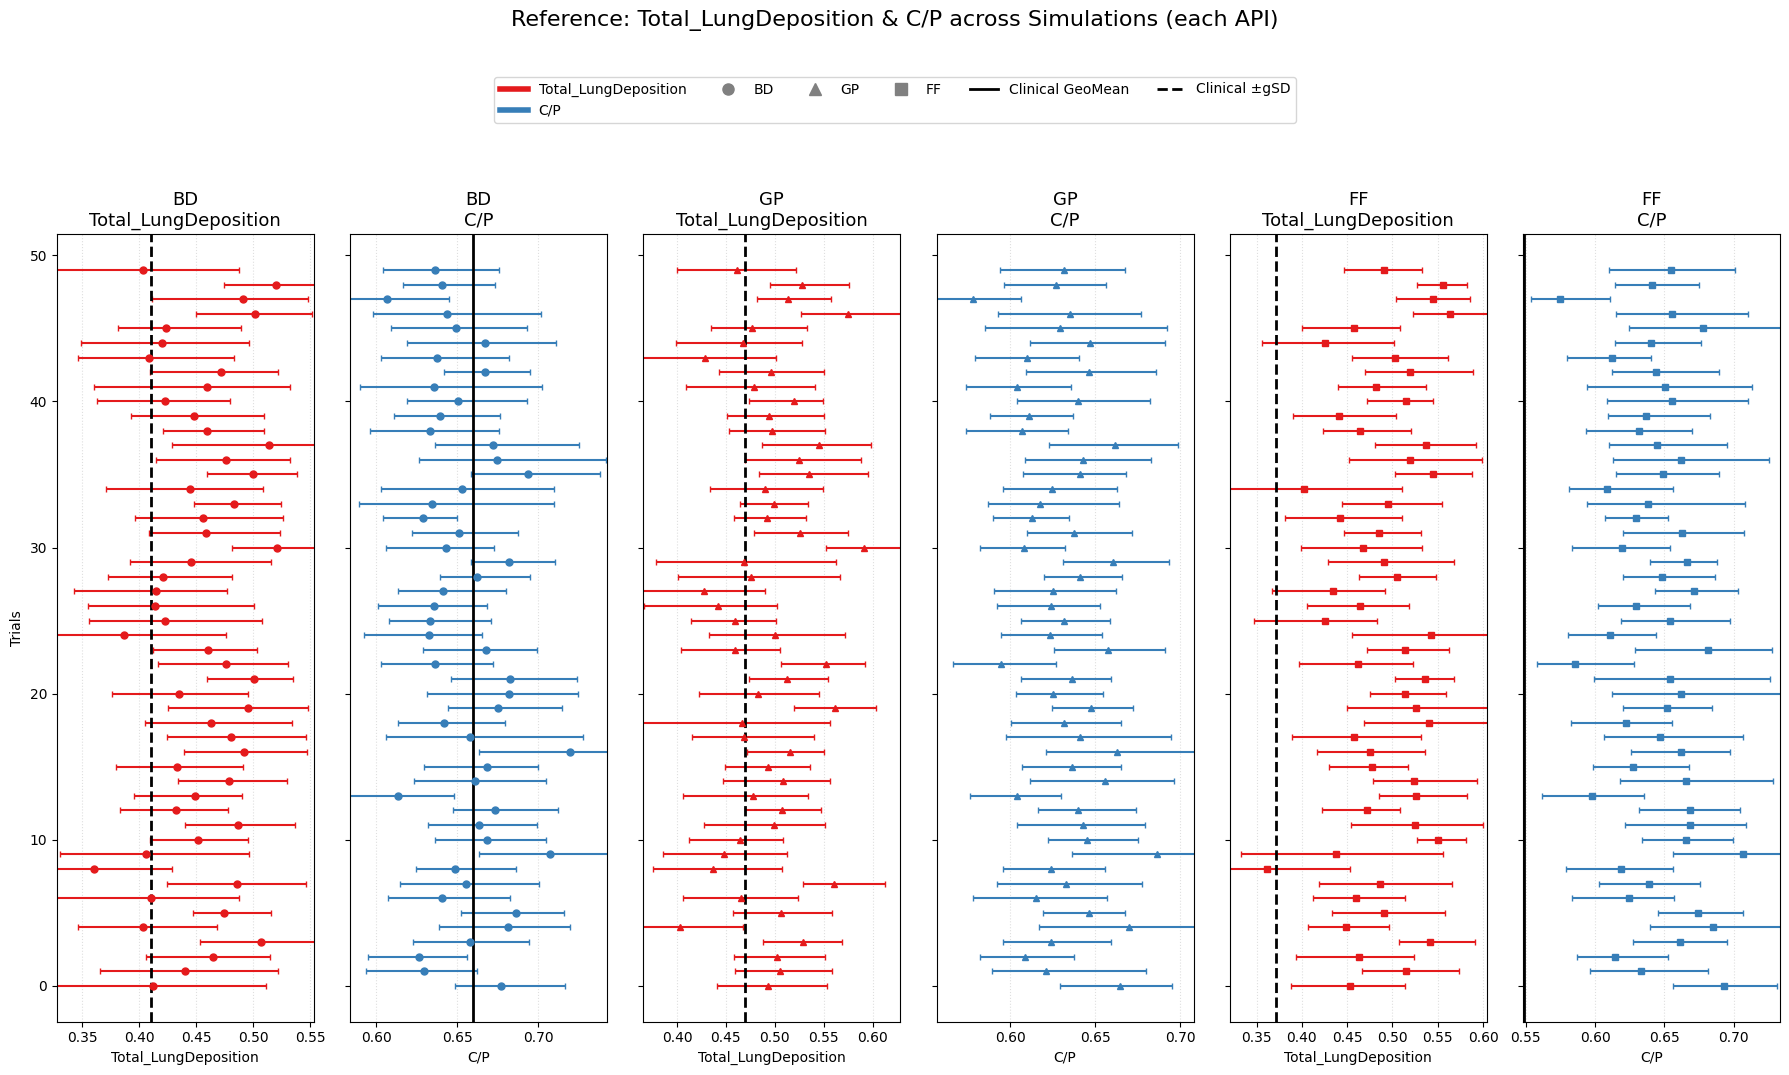

In [189]:
products_summary_scint, products_trials_scint = systemic_product_metrics(PK_BE_Inputs, trial_size=18, n_trials= 50, alpha_pk=0.1)
studycode = 'D5985C00004'

PKDATA_Deposition = {'D5985C00004': {'Total_LungDeposition': {'BD': [29.2 / 100, 0.9695, 1.0443, 40.66],
   'GP': [25.454286 / 100, 0.8913, 1.0284, 84.38],
   'FF': [25.454286 / 100, 0.982, 1.0666, 45.89]},
  'C/P': {'BD': [0.660, 0.9211, 1.0561, 60.79],
   'GP': [0.548571, 0.7778, 0.9379, 87.46],
   'FF': [0.548571, 0.8753, 0.9798, 62.22]}}}
plot_systemic_product_trials(products_trials_scint,product='Reference', apis = ['BD', 'GP', 'FF'],mean_type='GeoMean', parameters=('Total_LungDeposition', 'C/P'), clinical= PKDATA_Deposition, studycode=studycode)

